### NLP Multi-classification Modeling
    Artifacts: Metaverse GitHub Repositories

Created By: Mijail Q. Mariano


---- 

#### ``In Brief: Project Description``


Use README.md text to learn the primary programming language used in "Metaverse" related repos and associated topics. Design an NLP predictive model that accurately identifies the *[programming language]* * used in "metaverse" related repos. 

*The predicted programming language used in this analysis is the primary (in overall repo percentage) that is found in the GitHub repository searched.* *

In [1]:
# notebook dependencies 
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 300

import os
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# regular expression import
import re

# JSON import
import json

# importing BeautifulSoup for parsing HTML/XTML
from bs4 import BeautifulSoup

# request module for connecting to APIs
from requests import get

# text prepare modules
import acquire
import prepare

# uni-code library
import unicodedata

# natural language toolkit library/modules
import nltk
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [2]:
# acquire and data processing

df = pd.read_csv("metaverse.csv")

print(f'initial df shape: {df.shape}')
df.head()

initial df shape: (998, 3)


repo    language  \
0       M3-org/awesome-metaverse         NaN   
1              mvs-org/metaverse         C++   
2                  webaverse/app  JavaScript   
3  shadowcz007/awesome-metaverse         NaN   
4              vircadia/vircadia         C++   

                                     readme_contents  
0  # Awesome Metaverse [![Awesome](https://awesom...  
1  Metaverse Core Integration/staging Tree\n=====...  
2  <img src="docs/banner.jpeg" width=100% />\n\n<...  
3  # awesome-metaverse\n<a href="https://awesome....  
4  <p align="center"><a href="https://vircadia.co...

In [3]:
df["word_count"] = df["readme_contents"].str.split().str.len()
df["word_count"].sum()

254411.0

In [4]:
# cleaning the data object type

df = prepare.clean_data_objects(df)
df.info()

df shape: (998, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             998 non-null    object
 1   language         998 non-null    object
 2   readme_contents  998 non-null    object
dtypes: object(3)
memory usage: 23.5+ KB


In [5]:
# applying the mass_text_clean function on README.md contents

df["readme_contents"] = df["readme_contents"].apply(prepare.mass_text_clean)
df.head() # check out!

repo    language  \
0       M3-org/awesome-metaverse         nan   
1              mvs-org/metaverse         C++   
2                  webaverse/app  JavaScript   
3  shadowcz007/awesome-metaverse         nan   
4              vircadia/vircadia         C++   

                                     readme_contents  
0  awesome awesome awesome badge svg awesome list...  
1  core integration staging tree build status tra...  
2  img src doc banner jpeg width 100 align center...  
3  awesome href awesome target blank img alt awes...  
4  align center href vircadia img src interface r...

In [6]:
# viewing number of unique program languages and frequency in the dataset

print(f'unique language count: {df["language"].nunique()} ')
df["language"].value_counts()

unique language count: 39 


nan                 316
JavaScript          266
C#                   78
HTML                 72
TypeScript           70
Solidity             27
CSS                  23
Python               22
Rust                 16
Go                   15
C++                  14
Jupyter Notebook     11
Java                  7
ShaderLab             7
SCSS                  6
Vue                   5
Shell                 5
PHP                   5
SuperCollider         3
Clojure               3
Batchfile             2
Roff                  2
Swift                 2
C                     2
GLSL                  2
GDScript              2
Objective-C           2
Kotlin                2
HCL                   1
EJS                   1
PowerShell            1
Svelte                1
TeX                   1
Objective-C++         1
Cadence               1
Metal                 1
R                     1
LSL                   1
ASP.NET               1
Name: language, dtype: int64

In [7]:
# bucketing related languages in the dataset for greater programming coverage of Metaverse topics/repos

df = prepare.update_languages(df)

print(f'unique language count: {df["language"].nunique()}')
print("percent change from original: {:.2f}%".format(((39 - df.language.nunique())/df.language.nunique()*100)))
df["language"].value_counts()

unique language count: 11
percent change from original: 254.55%


text          316
Java          284
C             102
HTML           72
TypeScript     71
other          39
Python         33
Solidity       27
CSS            23
Rust           16
Go             15
Name: language, dtype: int64

In [8]:
# breakdown of programming language percentage in dataset

languages = pd.concat([
    df["language"].value_counts(),
    df["language"].value_counts(normalize = True).round(2)],
    axis = 1)

languages.columns = ['frequency', 'df_percentage']
languages

frequency  df_percentage
text              316           0.32
Java              284           0.28
C                 102           0.10
HTML               72           0.07
TypeScript         71           0.07
other              39           0.04
Python             33           0.03
Solidity           27           0.03
CSS                23           0.02
Rust               16           0.02
Go                 15           0.02

In [9]:
# what are "nan" languages?

pd.set_option('display.max_rows', None)

null_language = df[df["language"] == "nan"]
null_language.shape

(0, 3)

In [10]:
# number of repos with no programming language but contain content
# (observation) repos without programming languages, but contain text/README contents

print(f'records with missing language but contain readme contents: {len(null_language[(null_language["readme_contents"] != np.nan) & (null_language["readme_contents"] != "") & (null_language["readme_contents"] != "nan")])}')

records with missing language but contain readme contents: 0


In [11]:
# ok, what percentage of the df has no programming language and no readme content?
# (observation) repos without programming languages or text/README contents

missing_lang_and_readme = len(null_language[(null_language["readme_contents"] == "nan") | (null_language["readme_contents"] == "") | (null_language["readme_contents"] == "nan") | (null_language["readme_contents"] == None)])
print(f'records w/ missing language and readme contents: {missing_lang_and_readme}')
print('percentage of total repos: {:.2f}'.format(missing_lang_and_readme/len(df)))

records w/ missing language and readme contents: 0
percentage of total repos: 0.00


In [12]:
# how many whitespace values are there in readme_contents column?
# (observation) 60 records with blank README contents

len(df[df["readme_contents"] == ""])

60

In [13]:
# for simplicity/ease of understanding the Null/missing values in readme column -- let's convert whitespace to "nan" text
# (observation) challenges in converting & counting whitespace/"nan" values to either np.nan or pd.None

df["readme_contents"] = df["readme_contents"].replace("", "nan")

len(df[df["readme_contents"] == ""]) # checks out! 

0

In [14]:
# ok, what percentage of the df has no programming language and no readme content?
# (observation) repos without programming languages or text/README contents

complete_nulls = df[(df["language"] == "nan") & (df["readme_contents"] == "nan")]

missing_lang_and_readme = len(complete_nulls[complete_nulls["readme_contents"] == "nan"])
print(f'records w/ missing language and readme contents: {missing_lang_and_readme}')
print('percentage of total repos: {:.2f}'.format(missing_lang_and_readme/len(df))) # checks out!

records w/ missing language and readme contents: 0
percentage of total repos: 0.00


In [15]:
# dropping records with missing program language
# (observation) Java becomes primary scripting language

df["langauge"] = df["language"].replace("nan", "text")
# df = df[df["readme_contents"] != "nan"] (ommitting this line to syncronize with group)

print(f'dataframe shape: {df.shape}')
df["language"].value_counts(normalize = True).round(2)

dataframe shape: (998, 4)


text          0.32
Java          0.28
C             0.10
HTML          0.07
TypeScript    0.07
other         0.04
Python        0.03
Solidity      0.03
CSS           0.02
Rust          0.02
Go            0.02
Name: language, dtype: float64

In [16]:
# README word count for ea. record/repo

df["word_count"] = df["readme_contents"].str.split().str.len()
df["word_count"].sum()

207504

In [17]:
# what are the total number of words by programming language?
# capitalizing "other" language name

df["language"] = df["language"].replace("other", "Other")

sum_of_words = df.groupby("language")["word_count"].agg("sum").sort_values(ascending = False)
sum_of_words

language
text          92625
Java          45457
C             17219
TypeScript    14306
Python        10097
Other          6897
HTML           6226
Rust           5226
Solidity       4421
Go             3404
CSS            1626
Name: word_count, dtype: int64

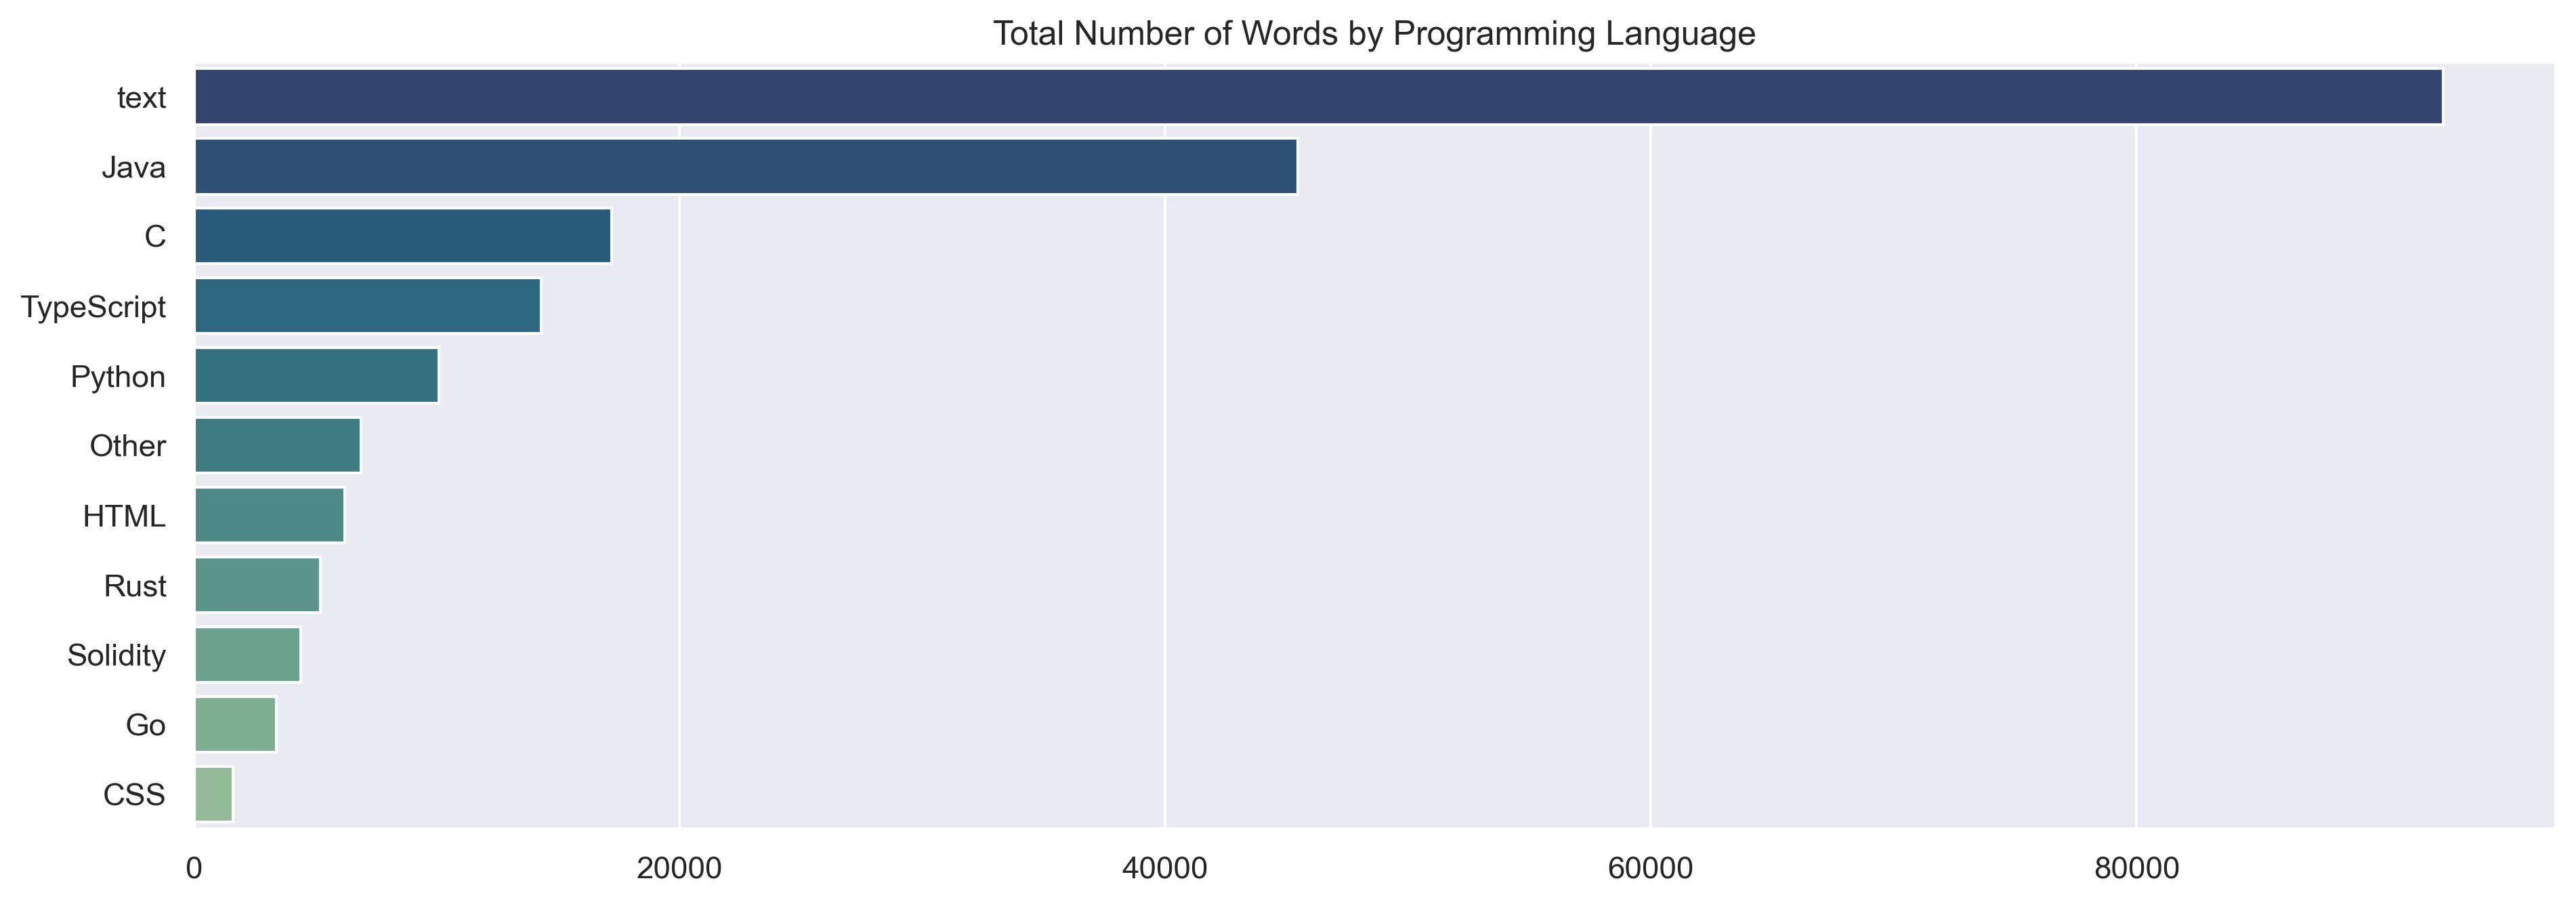

In [18]:
# as a plot?
# (observation) Java, C, TypeScript, Python, and HTML/other = Top 5/6 "metaverse" programming languages by number of words
# consider number count (container) graphing method

plt.figure(figsize = (15, 5))
sns.barplot(x = sum_of_words, y = sum_of_words.index, palette = "crest_r")

plt.ylabel(None)
plt.xlabel(None)
plt.title("Total Number of Words by Programming Language")
plt.show()

In [19]:
# what about average number of words by language?

mean_of_words = df.groupby("language")["word_count"].agg("mean").sort_values(ascending = False).round()
mean_of_words

language
Rust          327.0
Python        306.0
text          293.0
Go            227.0
TypeScript    201.0
Other         177.0
C             169.0
Solidity      164.0
Java          160.0
HTML           86.0
CSS            71.0
Name: word_count, dtype: float64

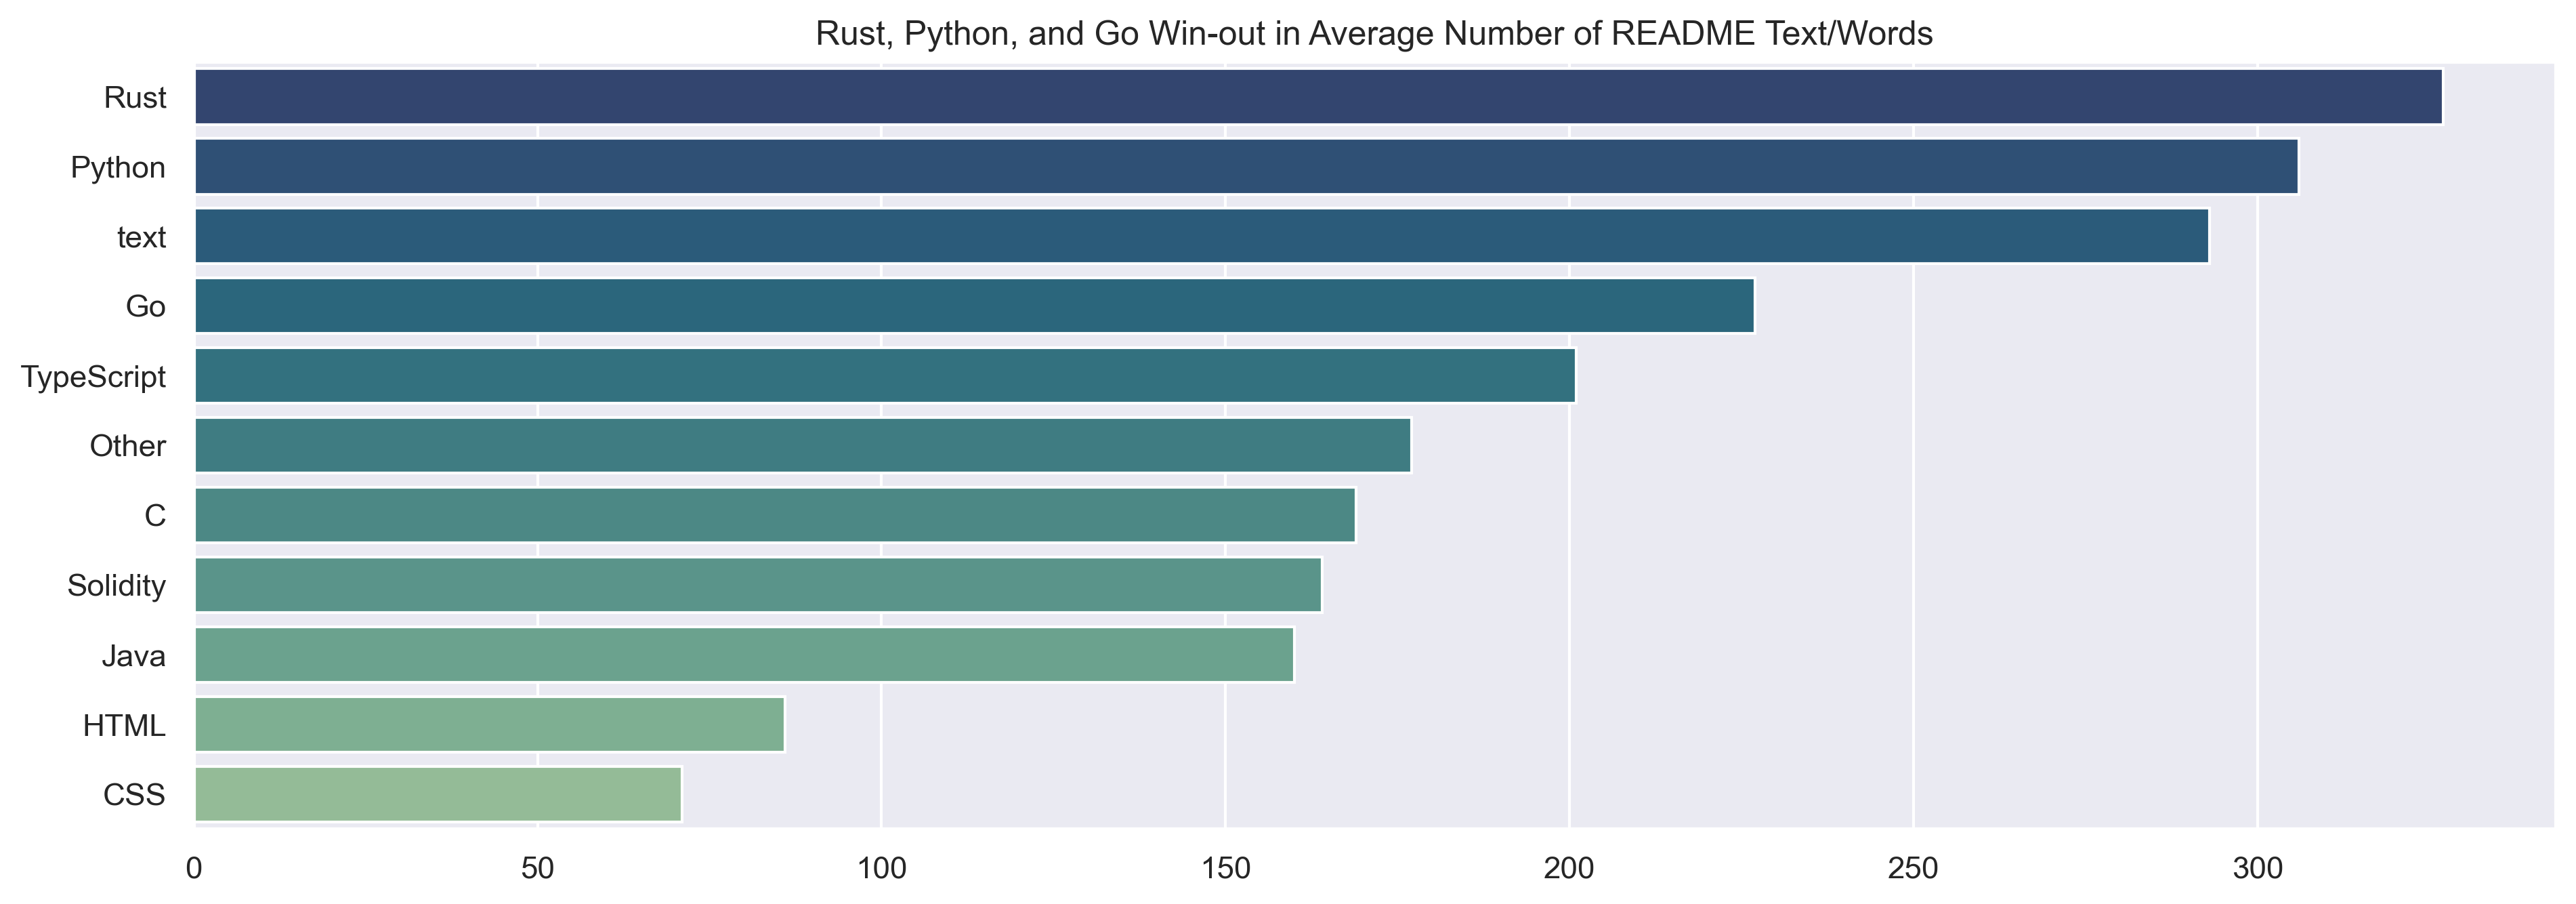

In [20]:
# average README text/words by programming language

plt.figure(figsize = (15, 5))
sns.barplot(x = mean_of_words, y = mean_of_words.index, palette = "crest_r")

plt.ylabel(None)
plt.xlabel(None)
plt.title("Rust, Python, and Go Win-out in Average Number of README Text/Words")
plt.show()

#### **<u>``General Observations:``</u>**

On average, the following primary programming languages tend to contain more text/content in their README files:

- 1. Rust
- 2. Python
- 3. Go

----

In [21]:
# splitting the dataset for exploratory analysis

train, validate, test = prepare.train_validate_test_split(df, "language")

train.head()

train shape: (558, 5)
validate shape: (240, 5)
test shape: (200, 5)


repo    language  \
710                  waste1000/metaverse        text   
469         NatefromNC/MetaverseStandard        text   
157  mvs-org/metaverse-vm-graphql-server  TypeScript   
22             funny-nation/Funny-Nation  TypeScript   
827                trilamanila/metaverse        Java   

                                       readme_contents    langauge  word_count  
710                                                nan        text           1  
469                                               text        text           1  
157  graphql server playground available explorer m...  TypeScript         145  
22   funny nation money centric meta verse discord ...  TypeScript         373  
827  next tailwind cs show tailwind cs tailwindcss ...        Java         131

In [22]:
# splitting larger dataset by specific programming language text/words

C_words = (" ".join(train[train["language"] == "C"]["readme_contents"])).split()
css_words = (" ".join(train[train["language"] == "CSS"]["readme_contents"])).split()

go_words = (" ".join(train[train["language"] == "Go"]["readme_contents"])).split()
html_words = (" ".join(train[train["language"] == "HTML"]["readme_contents"])).split()

java_words = (" ".join(train[train["language"] == "Java"]["readme_contents"])).split()
other_words = (" ".join(train[train["language"] == "Other"]["readme_contents"])).split()

python_words = (" ".join(train[train["language"] == "Python"]["readme_contents"])).split()
rust_words = (" ".join(train[train["language"] == "Rust"]["readme_contents"])).split()

solidity_words = (" ".join(train[train["language"] == "Solidity"]["readme_contents"])).split()
typescript_words = (" ".join(train[train["language"] == "TypeScript"]["readme_contents"])).split()

text_words = (" ".join(train[train["language"] == "text"]["readme_contents"])).split()
all_words = (" ".join(train["readme_contents"])).split()

In [23]:
# total number of words/elements in all_words_df

len(all_words)

128362

In [24]:
# returning unique words in ea. dataset

# Python code to find frequency of each word
def freq(lst):
    # container to hold unique values
    container = []

    # loop till string values present in list str
    for ele in lst:            

        # checking for the duplicacy
        if ele not in container:

            # insert value in str2
            container.append(ele)
    
    # returning the count of unique words
    return len(container)

In [25]:
# dataframe of ea. language, word counts, and number of unique values

count_df = pd.DataFrame({"language": ["All", 'C', 'CSS', 'Go', 'HTML', 'Java', 'Other', 'Python', 'Rust', 'Solidity', 'Text', 'TypeScript'],
"word_count": [len(all_words), len(C_words), len(css_words), len(go_words), len(html_words), len(java_words), len(other_words), len(python_words), len(rust_words), len(solidity_words), len(text_words), len(typescript_words)],
"unique_words": [freq(all_words), freq(C_words), freq(css_words), freq(go_words), freq(html_words), freq(java_words), freq(other_words), freq(python_words), freq(rust_words), freq(solidity_words), freq(text_words), freq(typescript_words)]}).sort_values("word_count", ascending = False).reset_index(drop = True)

count_df

language  word_count  unique_words
0          All      128362         12891
1         Text       70043          7577
2         Java       26452          4140
3            C       10624          2818
4   TypeScript        7771          1901
5        Other        3974          1518
6         Rust        2970          1152
7       Python        2165           812
8         HTML        1989           729
9     Solidity        1115           404
10         CSS         740           206
11          Go         519           242

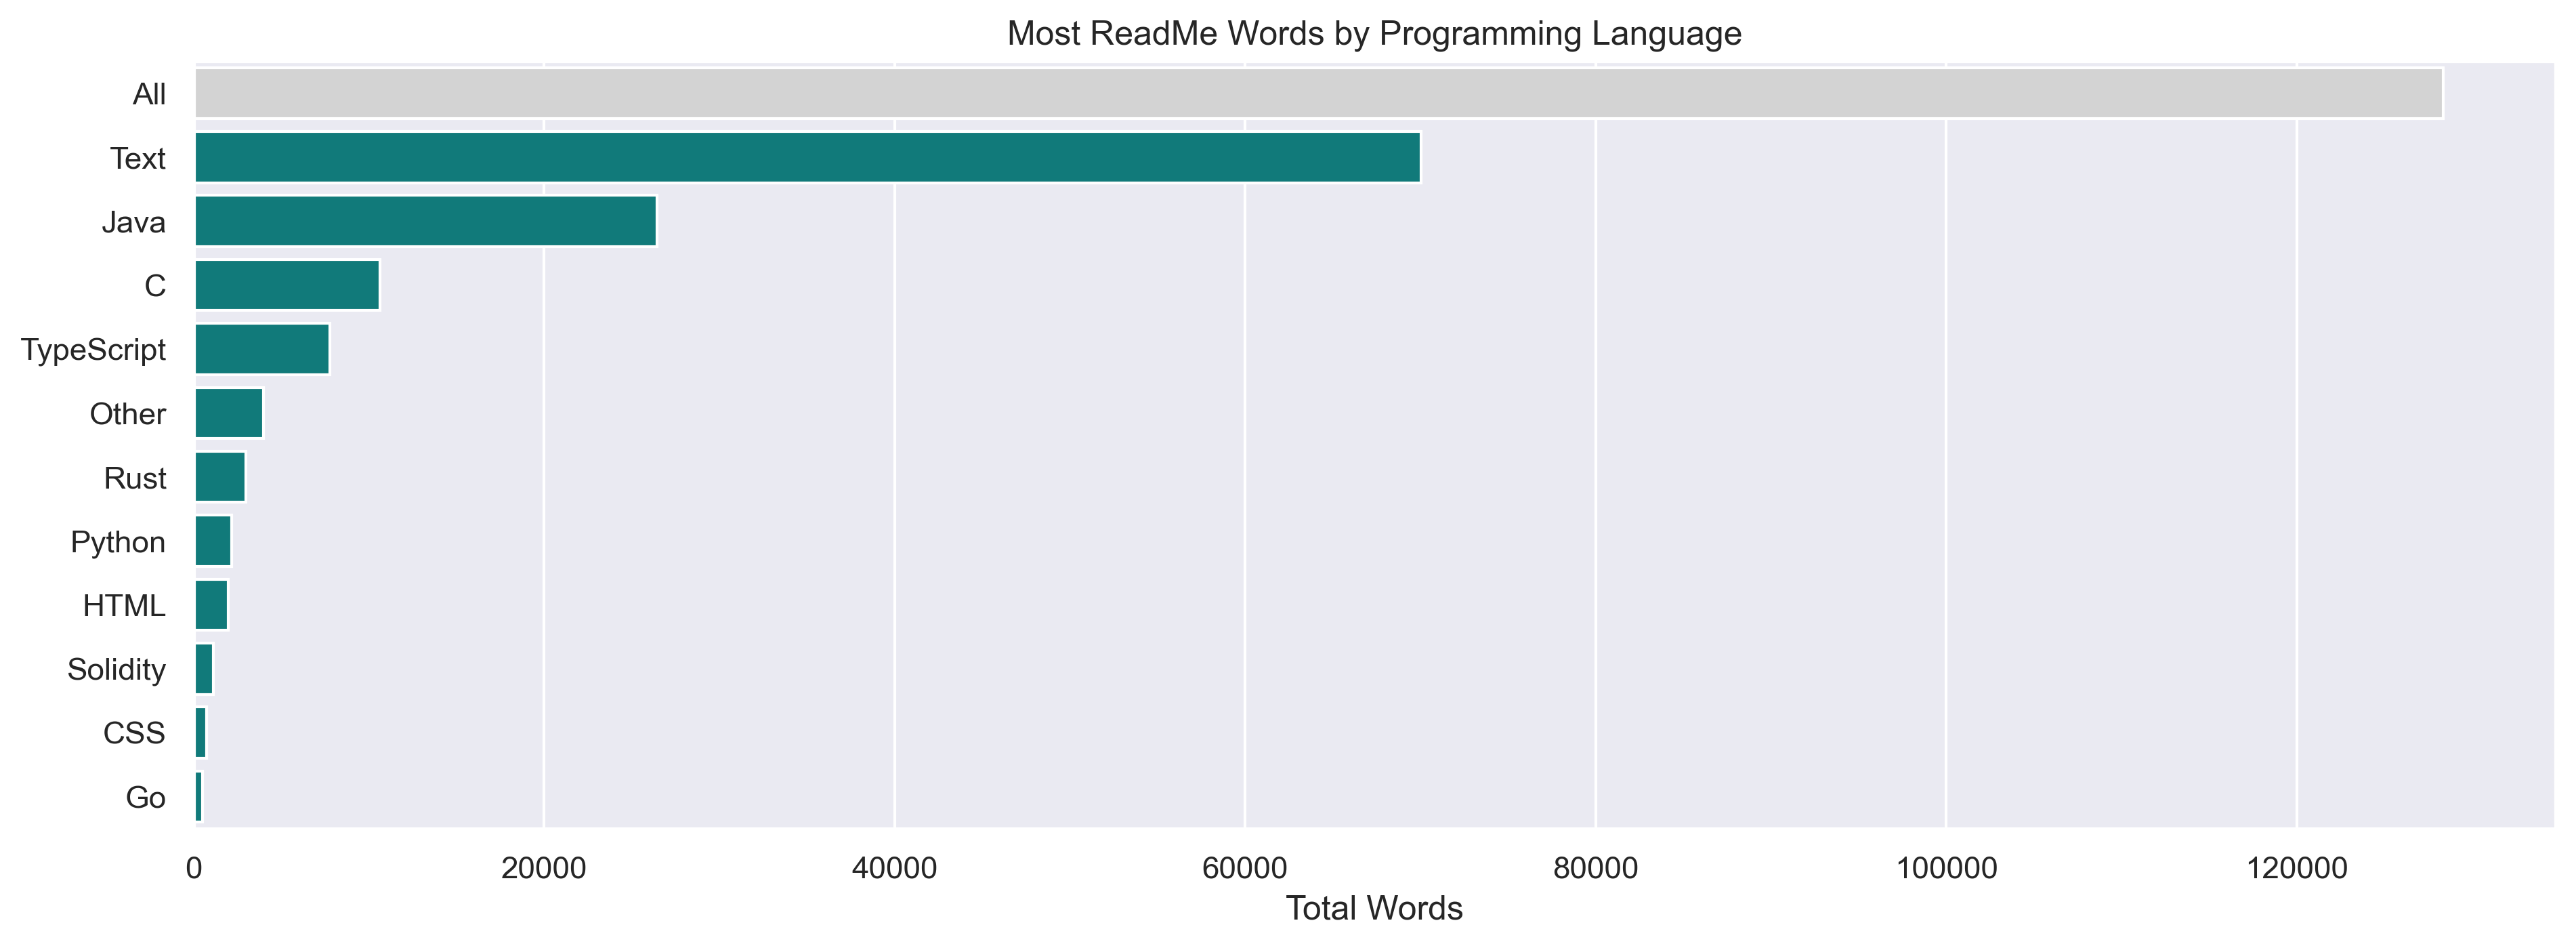

In [26]:
# visualizing the language and word total word counts

plt.figure(figsize = (15, 5))

colors = ["lightgrey" if x == "All" else "darkcyan" for x in count_df["language"]]

ax = sns.barplot(
    x = count_df["word_count"],
    y = count_df["language"],
    palette = colors)

plt.ylabel(None)
plt.xlabel("Total Words")
plt.title("Most ReadMe Words by Programming Language")

plt.show()

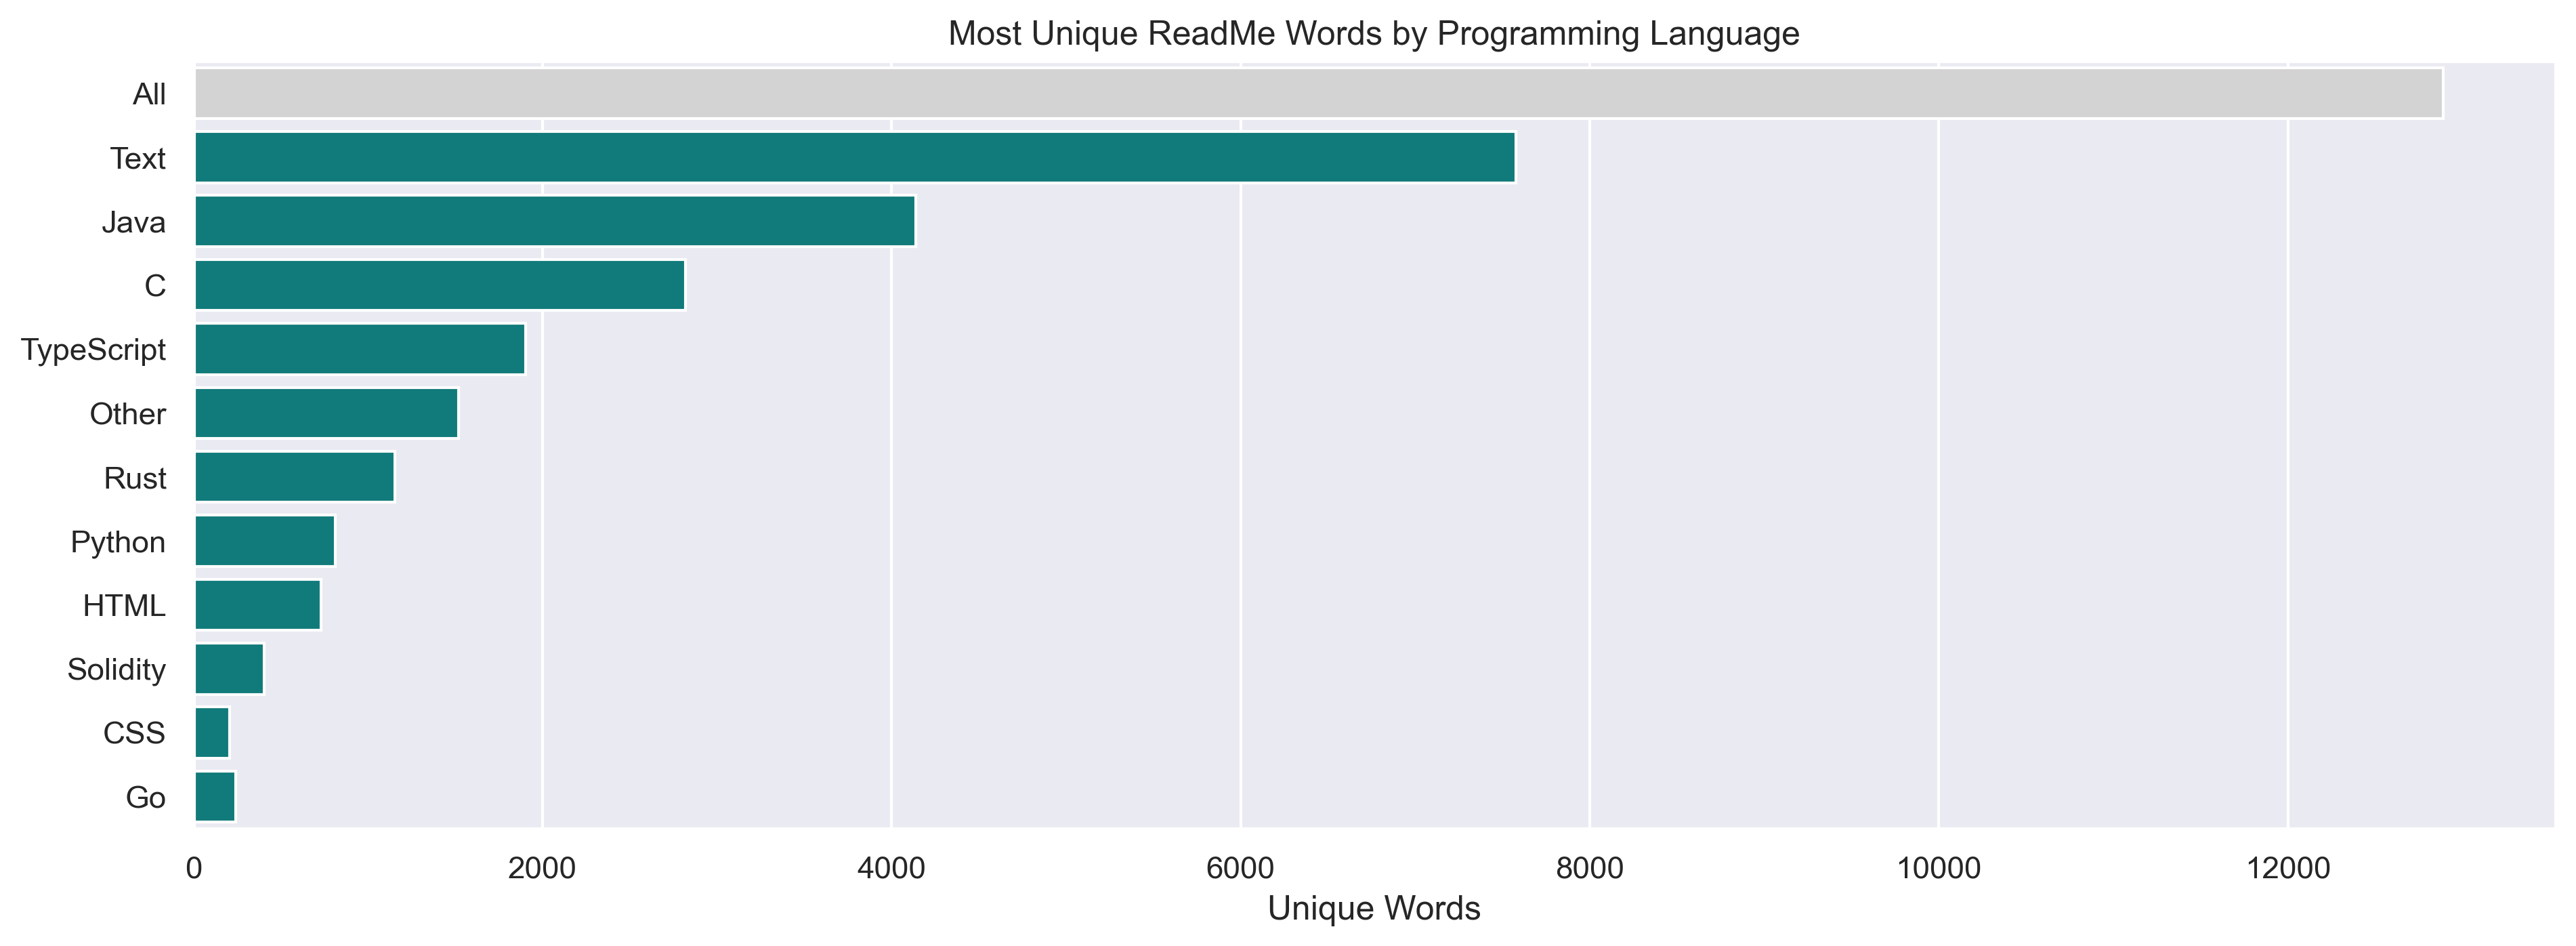

In [27]:
# visualizing total number of unique words by language

plt.figure(figsize = (15, 5))

colors = ["lightgrey" if x == "All" else "darkcyan" for x in count_df["language"]]

ax = sns.barplot(
    x = count_df["unique_words"],
    y = count_df["language"],
    palette = colors)

plt.ylabel(None)
plt.xlabel("Unique Words")
plt.title("Most Unique ReadMe Words by Programming Language")

plt.show()

In [28]:
# extracting word value counts by programming language README contents

C_freq = pd.Series(C_words, name = "C").value_counts()
css_freq = pd.Series(css_words, name = "CSS").value_counts()

go_freq = pd.Series(go_words, name = "Go").value_counts()
html_freq = pd.Series(html_words, name = "HTML").value_counts()

java_freq = pd.Series(java_words, name = "Java").value_counts()
other_freq = pd.Series(other_words, name = "Other").value_counts()

python_freq = pd.Series(python_words, name = "Python").value_counts()
rust_freq = pd.Series(rust_words, name = "Rust").value_counts()

solidity_freq = pd.Series(solidity_words, name = "Solidity").value_counts()
typescript_freq = pd.Series(typescript_words, name = "TypeScript").value_counts()

text_freq = pd.Series(text_words, name = "Text").value_counts()
all_freq = pd.Series(all_words, name = "all").value_counts()

In [29]:
# mass frequency dataframe

mass_count = (pd.concat([
                all_freq, 
                C_freq,
                css_freq,
                go_freq,
                html_freq,
                java_freq, 
                other_freq,
                python_freq, 
                rust_freq,
                solidity_freq,
                text_freq,
                typescript_freq], axis = 1, sort = True)
                    .set_axis(["all", "C", "CSS", "Go", "HTML", "Java", "Other", "Python", "Rust", "Solidity", "Text", "TypeScript"], axis = 1)
                    .fillna(False)
                    .apply(lambda s: s.astype(int)))

mass_count.sort_values(by = "all", ascending = False).head(25)

all   C  CSS  Go  HTML  Java  Other  Python  Rust  Solidity  Text  \
href     2154  16    1   0     0   107      1       4    48         0  1918   
detail   1991  26    3   4     0    13      2       0     3         0  1935   
summary  1944  12    0   0     0     0      1       0     0         0  1931   
git      1167  27    0   1     5    59      4       3     5         0  1051   
13        973   2    0   0     0     1      6       1     0         0   963   
open      969  47    5   0    12   106     14       1     6         1   746   
project   852  77    4   1     3   135      8       4     9         8   564   
img       831  47   10   0    12   147      1       6    29         0   509   
2022      806   5    0   0     0    23      1       1     0         0   772   
src       706  28    4   0     8   115      1       6    17         2   475   
clone     681  10    0   2     1    31      3       3     1         0   621   
app       673  26   17   0     0   493     17       1     0         0    66   
npm       671   3    3   0     6   242      7       0     2         2   293   
2         659  66    1   0     9    52     11      23    11         4   465   
width     592  21    0   0     7    59      2       5    16         0   462   
www       588  53    3   0    31    66     17       3     0        12   375   
doc       581  48   12   0     1   441      4       0     4         0    32   
bit       566   3    0   0     0     0      0       0     7         0   556   
08        557   0    0   0     0     3      1       0     0         0   553   
install   555  45    1   1    16   118     11       9     6         2   302   
0         543  84    0   2     6   106     15      12     8         4   294   
create    526  18   12   0     2   382      2       3     5         5    63   
style     503   7    7   0     2    24      0       0     3         1   450   
height    502   9    0   0     7    25      1       1     0         0   449   
next      497   3   51   0     0   385      2       0     2         0    26   

         TypeScript  
href             59  
detail            5  
summary           0  
git              12  
13                0  
open             31  
project          39  
img              70  
2022              4  
src              50  
clone             9  
app              53  
npm             113  
2                17  
width            20  
www              28  
doc              39  
bit               0  
08                0  
install          44  
0                12  
create           34  
style             9  
height           10  
next             28

In [30]:
len(all_words)

128362

In [31]:
# what about cleaning for "single" numerical values? (e.g., "0", "2", etc.)

def remove_nums(list):
    # pattern to search for
    pattern = '[0-9]'

    # creating the new list with removed numerical elements
    new_list = [re.sub(pattern, '', ele) for ele in list]

    # removing any word/ele <= 2 letters
    new_list = [re.sub(r'\b[a-z]{,2}\b', '', ele) for ele in new_list]
    
    # removing empty strings
    new_list = [ele for ele in new_list if ele]

    # return new list of accepted elements
    return new_list


test = remove_nums(all_words)

print(f'total words in test: {len(test)}')
print('percent change after clean: {:.2f}'.format((len(all_words)-len(test))/len(test)))

total words in test: 111424
percent change after clean: 0.15


In [32]:
# applying function to word dfs

C_words = remove_nums(C_words)
css_words = remove_nums(css_words)

go_words = remove_nums(go_words)
html_words = remove_nums(html_words)

java_words = remove_nums(java_words)
other_words = remove_nums(other_words)

python_words = remove_nums(python_words)
rust_words = remove_nums(rust_words)

solidity_words = remove_nums(solidity_words)
typescript_words = remove_nums(typescript_words)

text_words = remove_nums(text_words)
all_words = remove_nums(all_words)

In [33]:
# updating the word value counts by programming language README contents

C_freq = pd.Series(C_words, name = "C").value_counts()
css_freq = pd.Series(css_words, name = "CSS").value_counts()

go_freq = pd.Series(go_words, name = "Go").value_counts()
html_freq = pd.Series(html_words, name = "HTML").value_counts()

java_freq = pd.Series(java_words, name = "Java").value_counts()
other_freq = pd.Series(other_words, name = "Other").value_counts()

python_freq = pd.Series(python_words, name = "Python").value_counts()
rust_freq = pd.Series(rust_words, name = "Rust").value_counts()

solidity_freq = pd.Series(solidity_words, name = "Solidity").value_counts()
typescript_freq = pd.Series(typescript_words, name = "TypeScript").value_counts()

text_freq = pd.Series(text_words, name = "text").value_counts()
all_freq = pd.Series(all_words, name = "all").value_counts()

In [34]:
# updating frequency dataframe

mass_count = (pd.concat([
                all_freq, 
                C_freq,
                css_freq,
                go_freq,
                html_freq,
                java_freq, 
                other_freq,
                python_freq, 
                rust_freq,
                solidity_freq,
                text_freq,
                typescript_freq], axis = 1, sort = True)
                    .set_axis(["all", "C", "CSS", "Go", "HTML", "Java", "Other", "Python", "Rust", "Solidity", "Text", "TypeScript"], axis = 1)
                    .fillna(False)
                    .apply(lambda s: s.astype(int)))

mass_count.sort_values(by = "all", ascending = False).head(50)

mass_count.to_csv("/Users/mijailmariano/Desktop/mass_count.csv")

In [35]:
# testing out the groupby method for top 20 words

top_20 = mass_count.sort_values("all", ascending = False).head(20)
top_20 = top_20.sort_values(by = "all", ascending = False)
top_20 = top_20.drop(columns = "all")

s = top_20.groupby(top_20.index)[["C", "CSS", "Go", "HTML", "Java", "Other", "Python", "Rust", "Solidity", "Text", "TypeScript"]].mean()

# add the row wise sum for each programming language
s["total"] = s.sum(axis = 1)

# sort
s.sort_values('total', inplace=True)

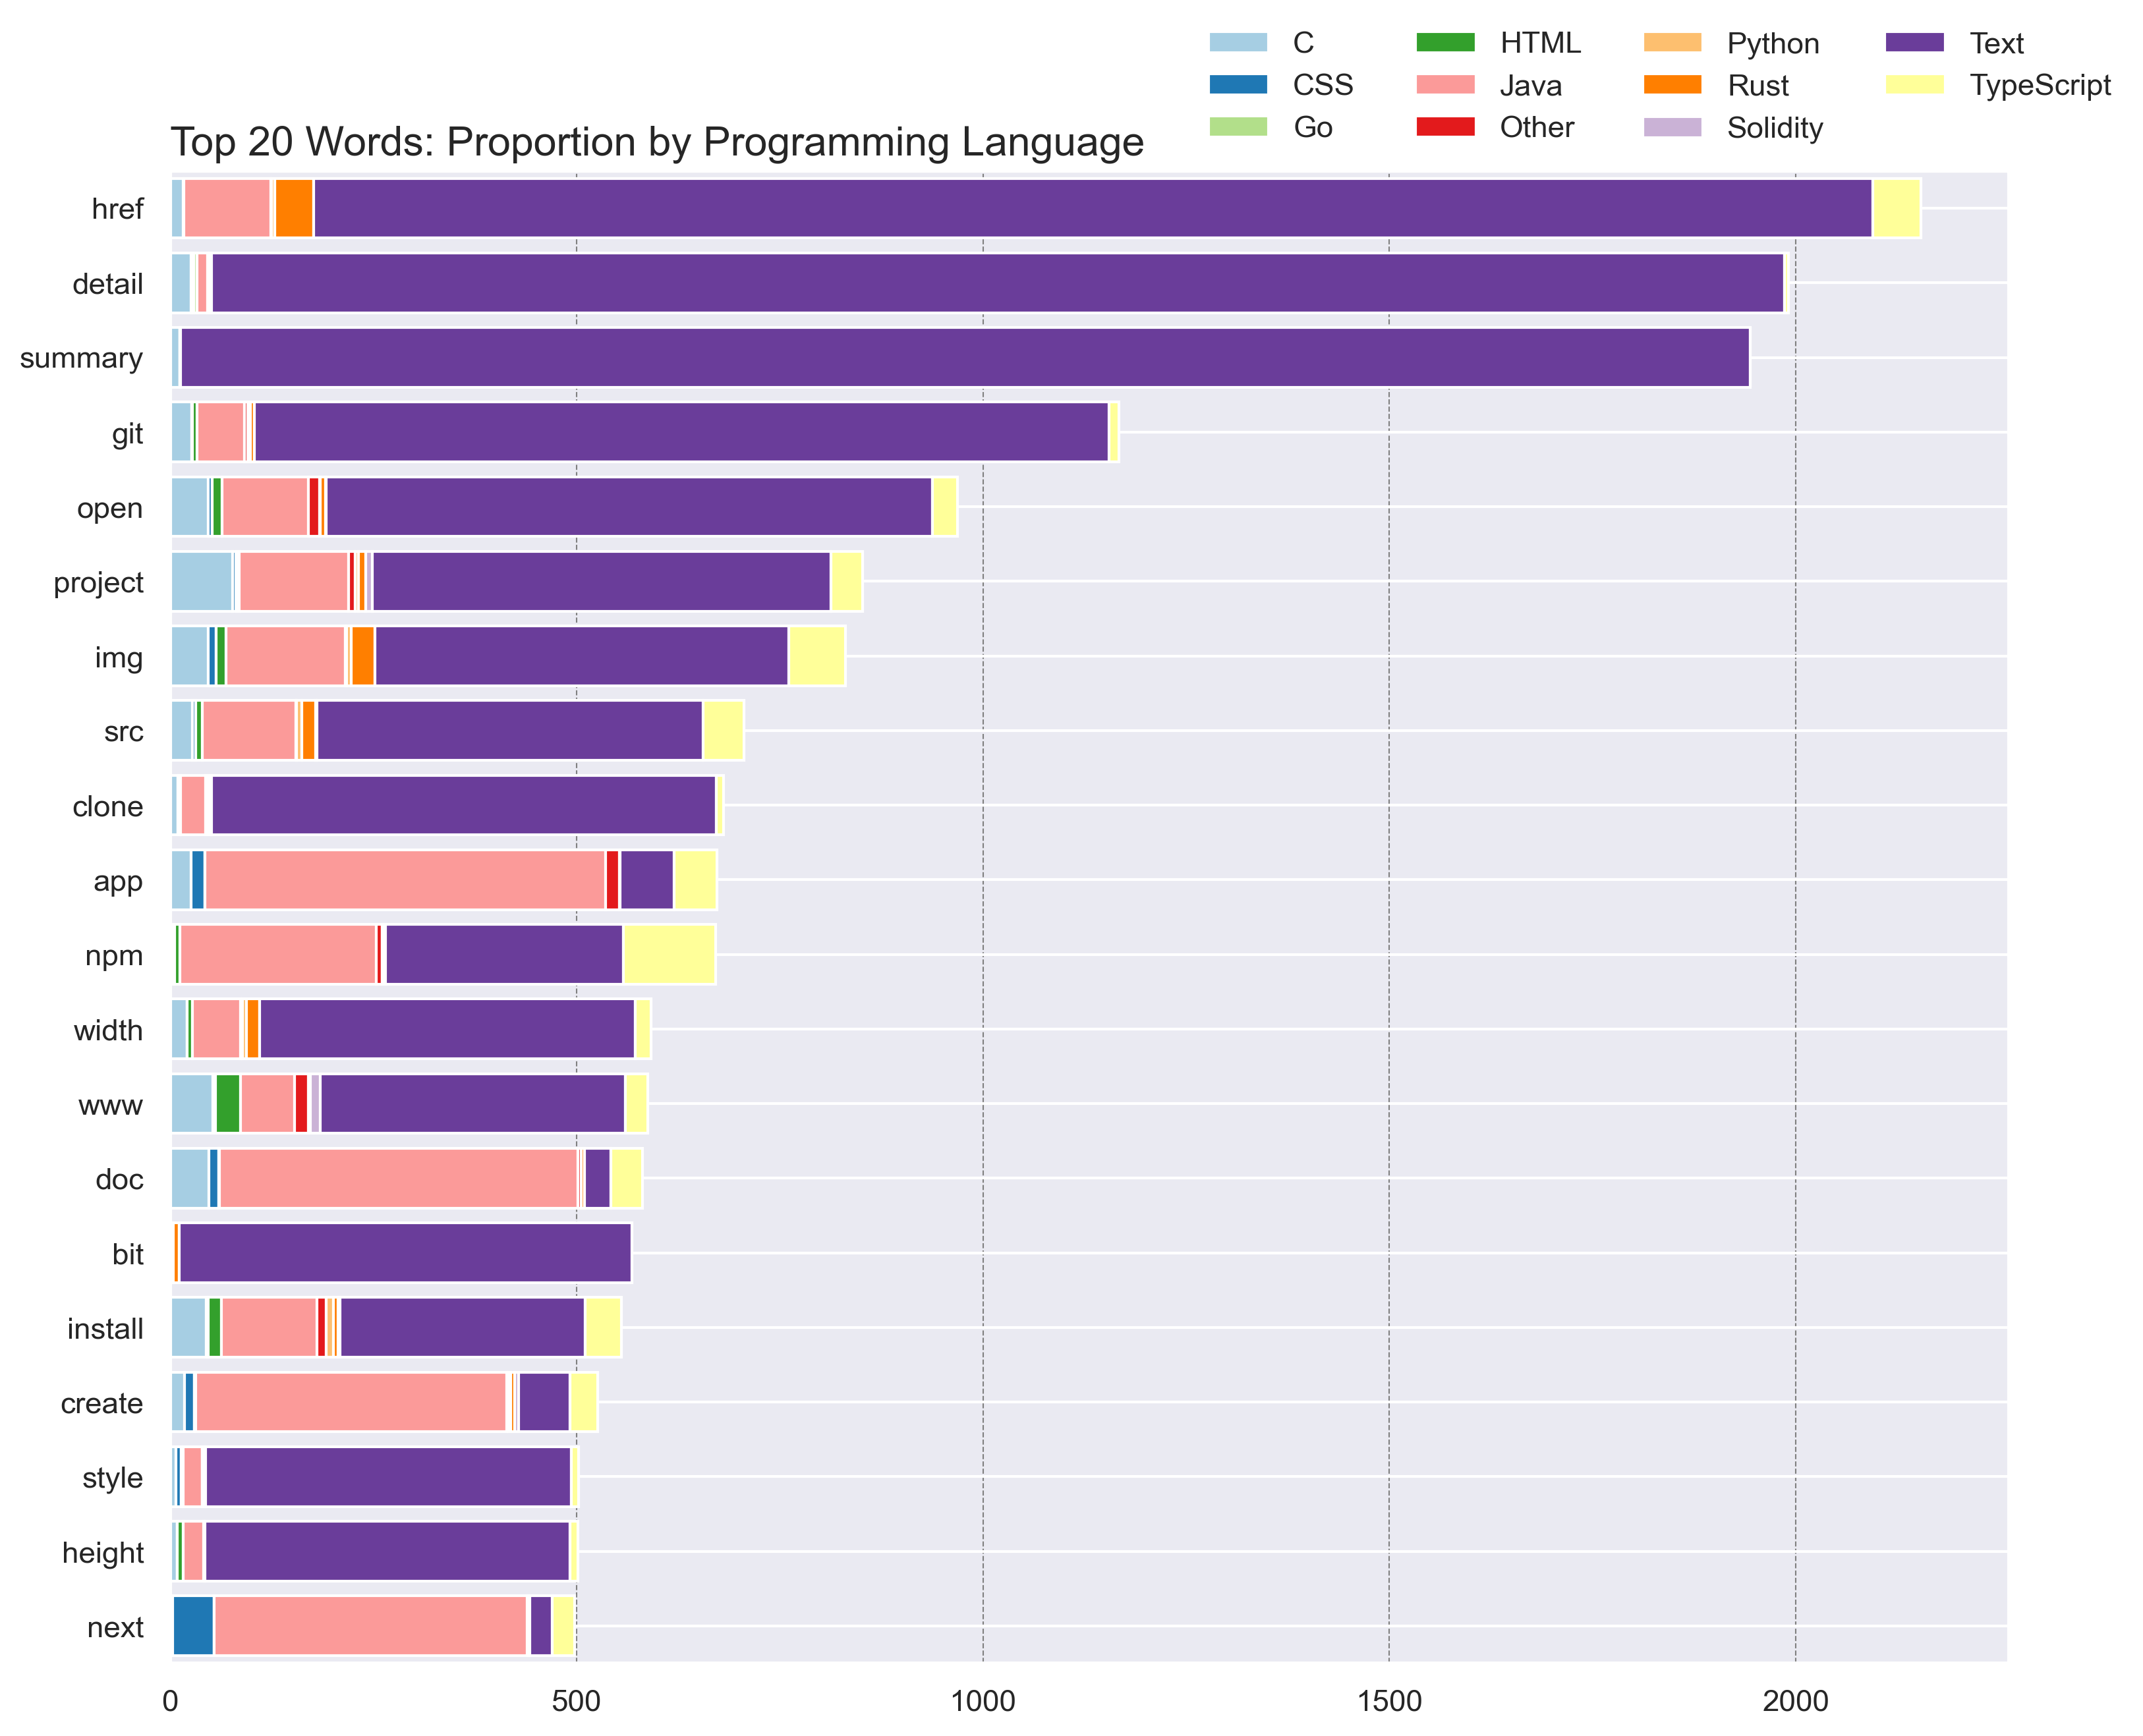

In [36]:
# let's plot word proportions!

languages = ["C", "CSS", "Go", "HTML", "Java", "Other", "Python", "Rust", "Solidity", "Text", "TypeScript"]
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
words = s.index.tolist()

# figure and axis
fig, ax = plt.subplots(1, figsize = (12, 10))

# plot bars
left = len(s) * [0]

for idx, name in enumerate(languages):

    plt.barh(s.index, s[name], left = left, color = colors[idx])
    left = left + s[name]

# title, legend, words
plt.title('Top 20 Words: Proportion by Programming Language', loc='left', fontsize = 15)
plt.legend(languages, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel(None)


# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color = 'gray', linewidth = 0.5, linestyle = 'dashed')

plt.show()

----
#### ``3. (out of order, but it's ok!) Do different programming languages use a different number of unique words?``

#### ``Bigrams: Top 25 most Frequent Bigrams by Programming Language``

In [37]:
# creating a language variable to iterate through and plot bigrams/trigrams
languages = [ 
    'All Words',
    'C',
    'CSS',
    'Go',
    'HTML',
    'Java',
    'Other',
    'Python',
    'Rust',
    'Solidity',
    'Text',
    'TypeScript']

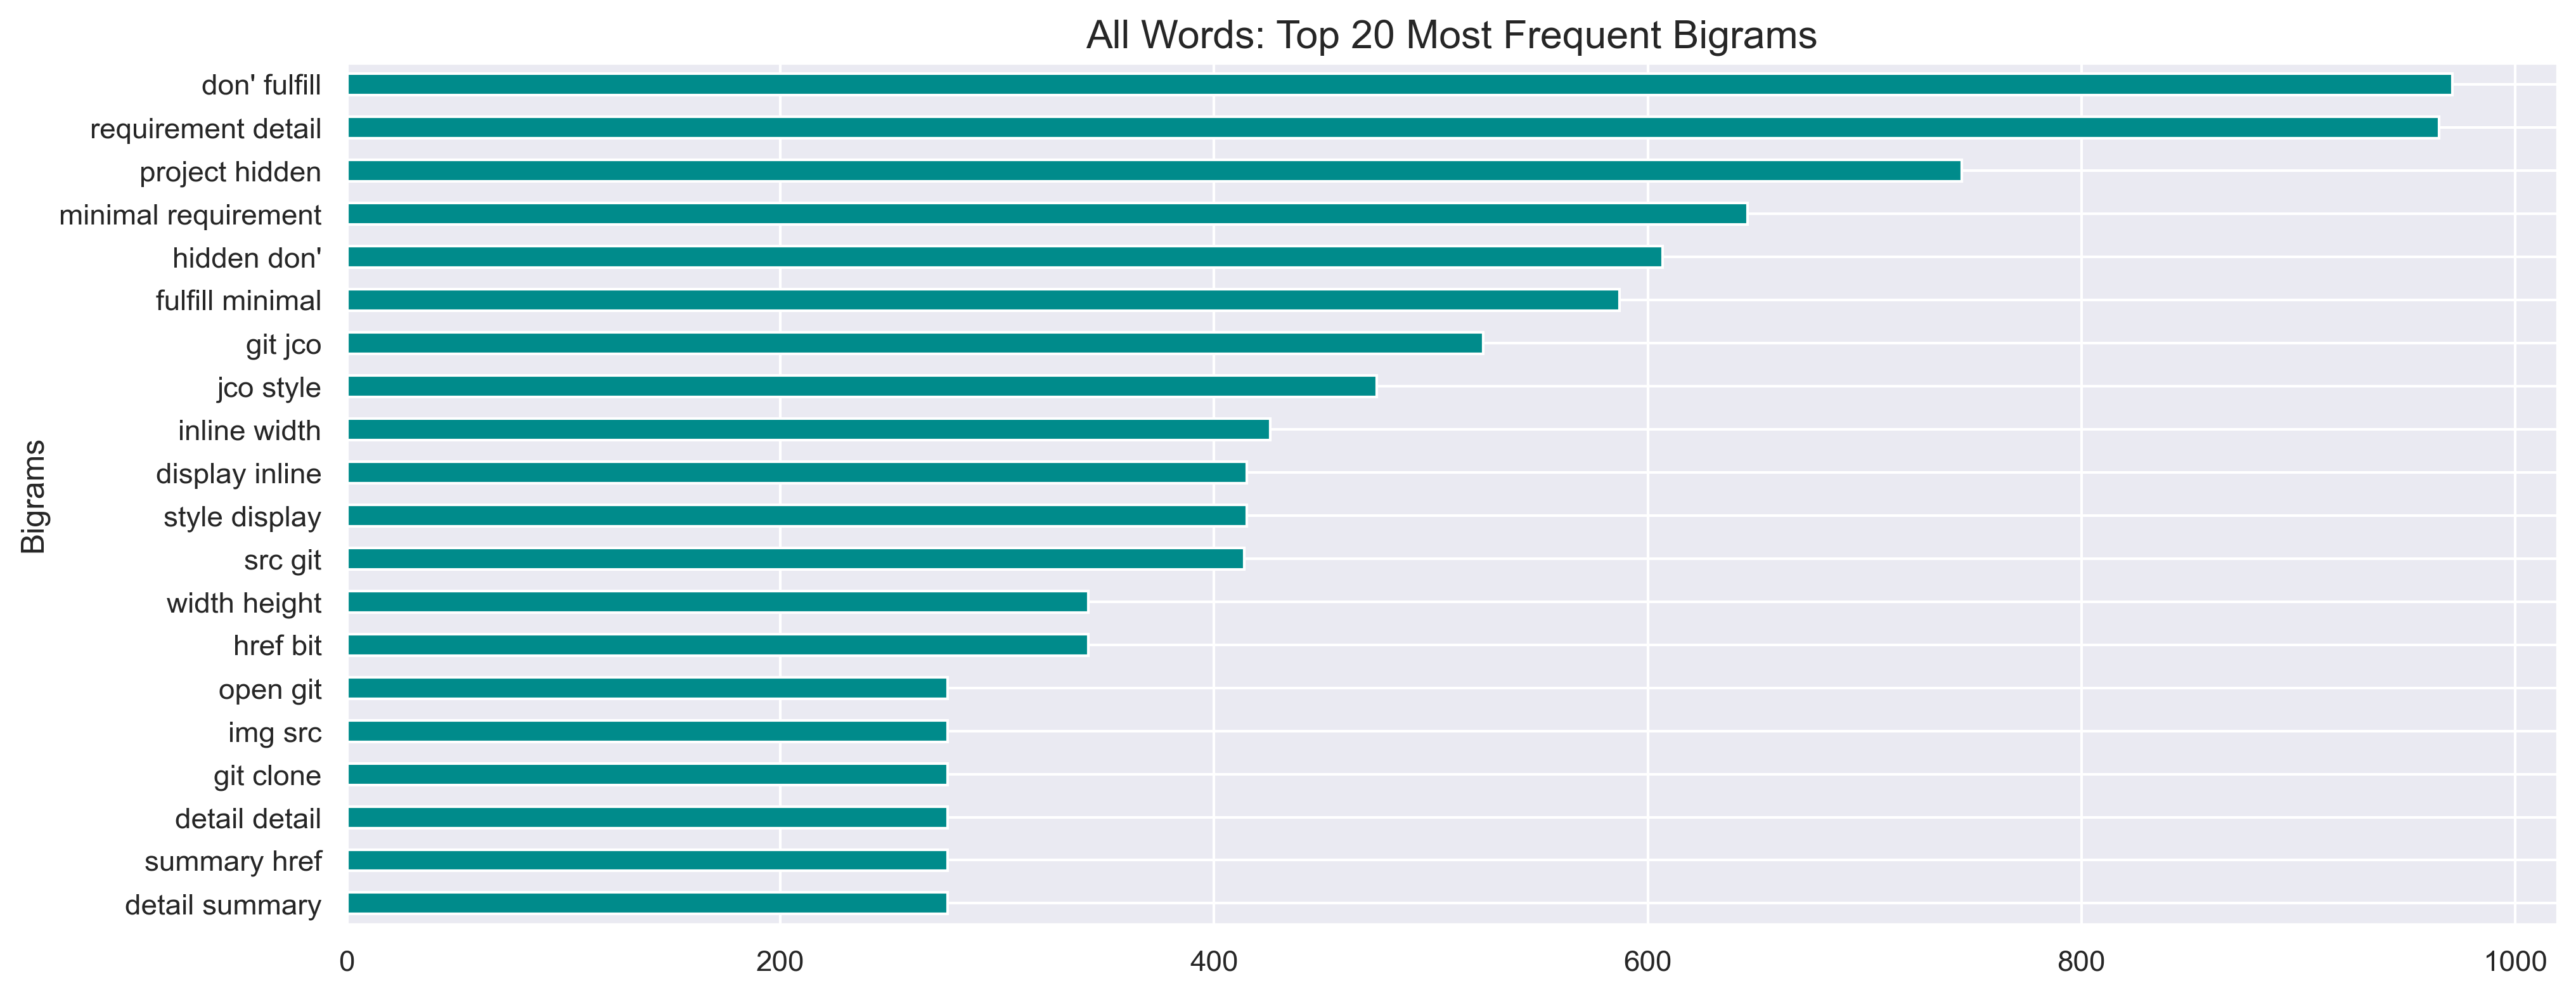

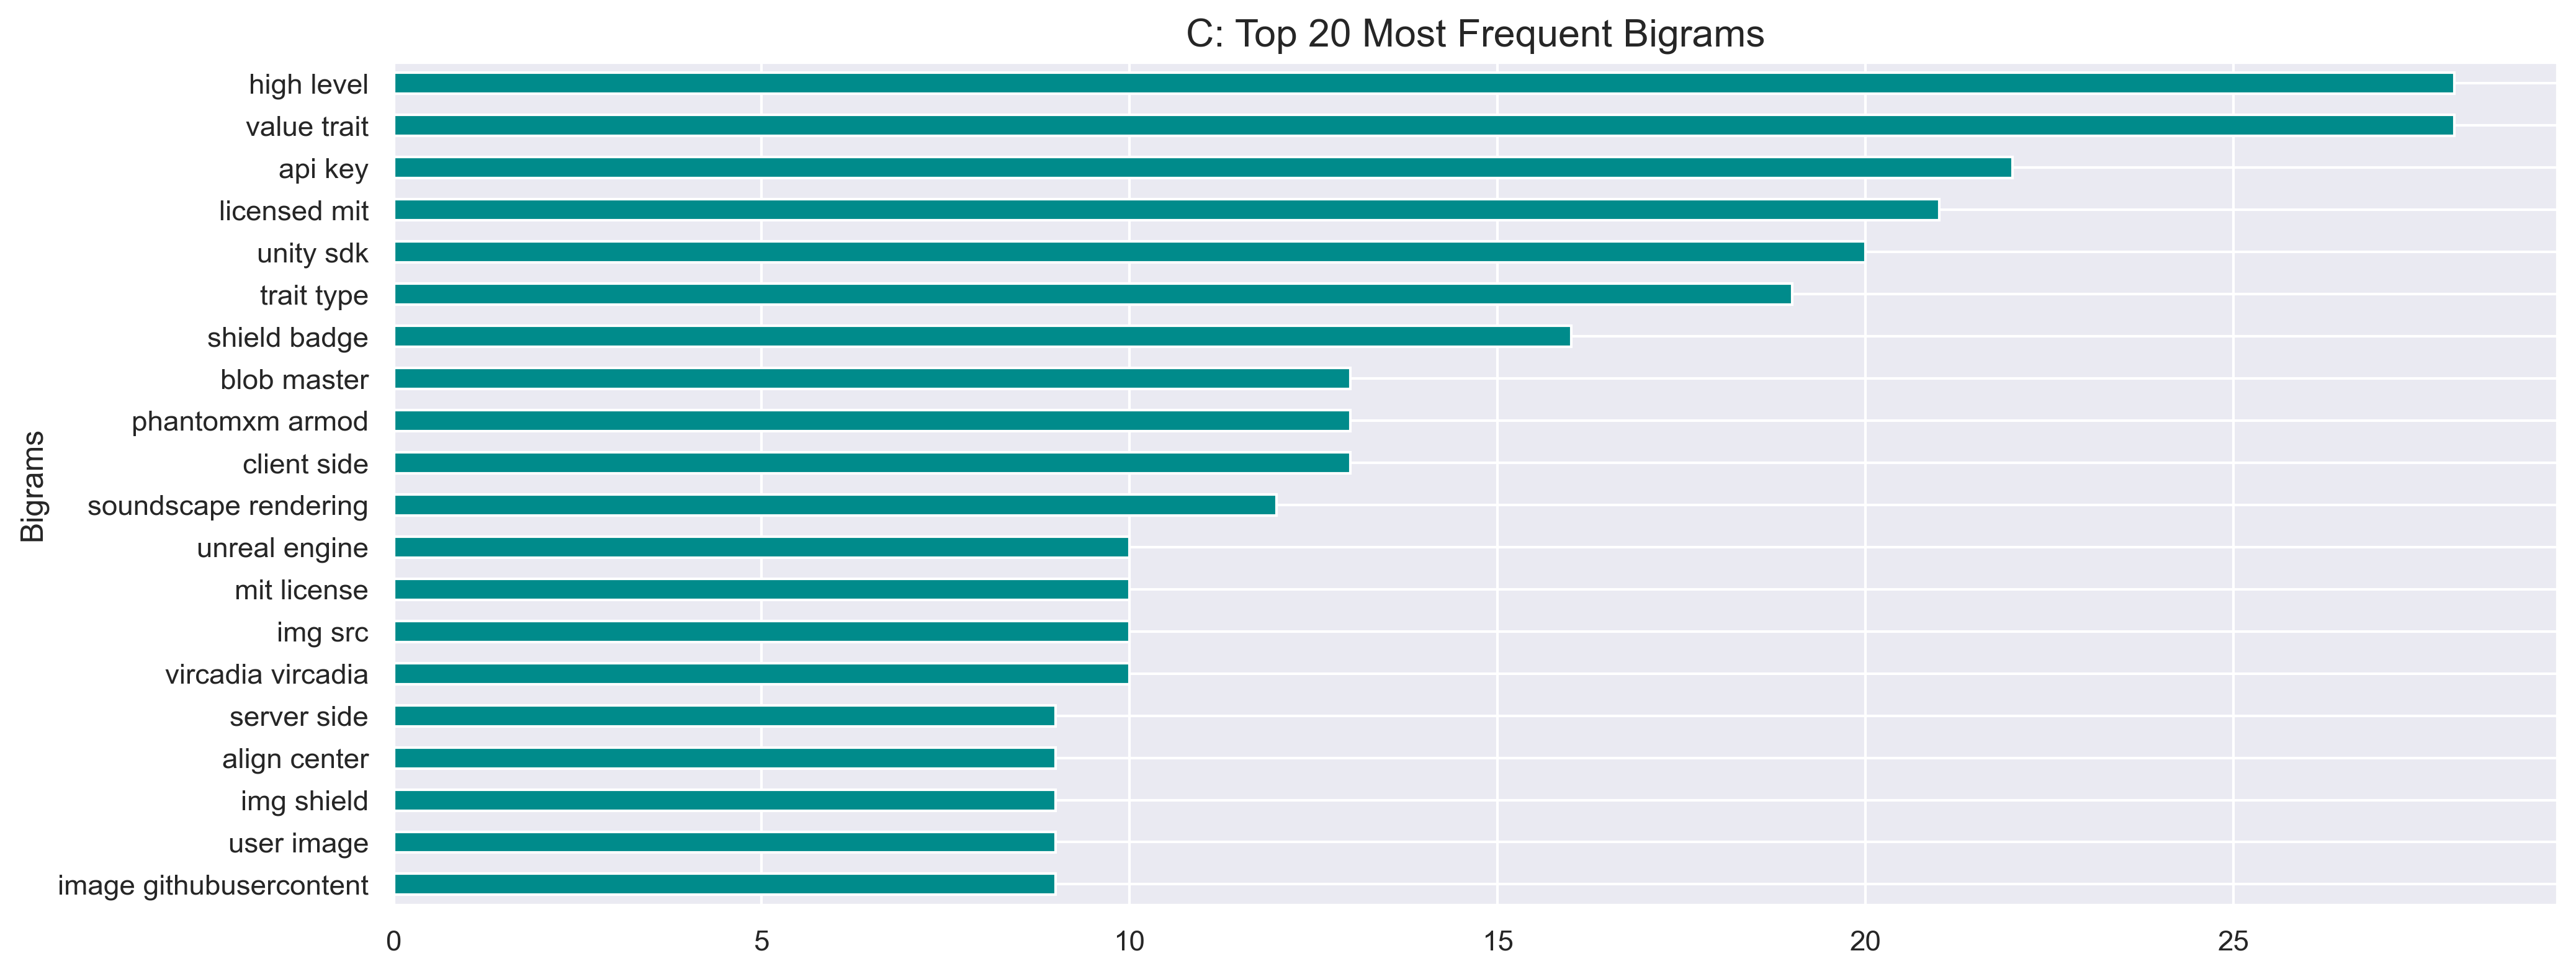

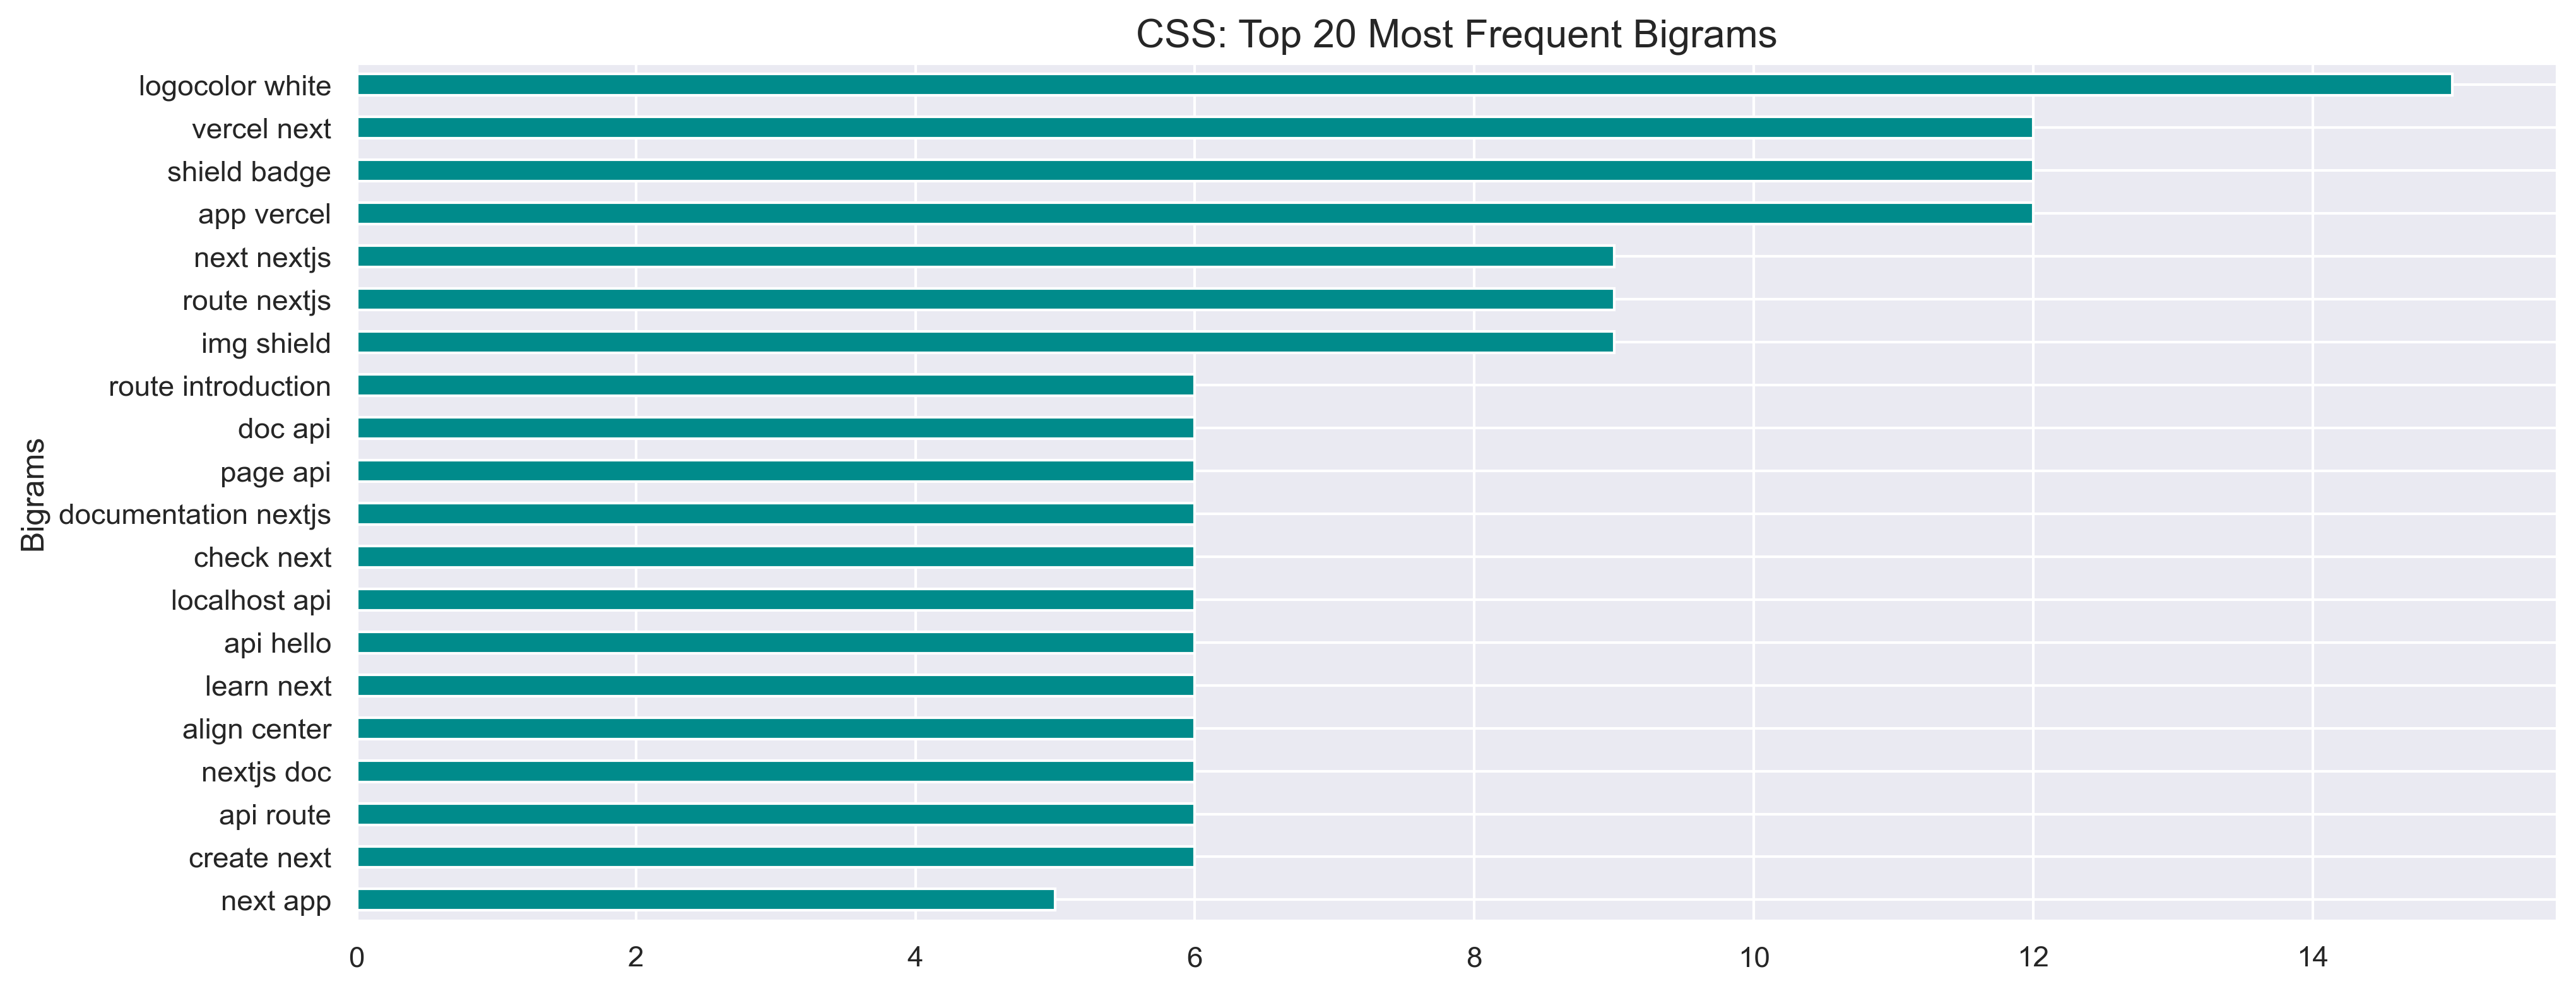

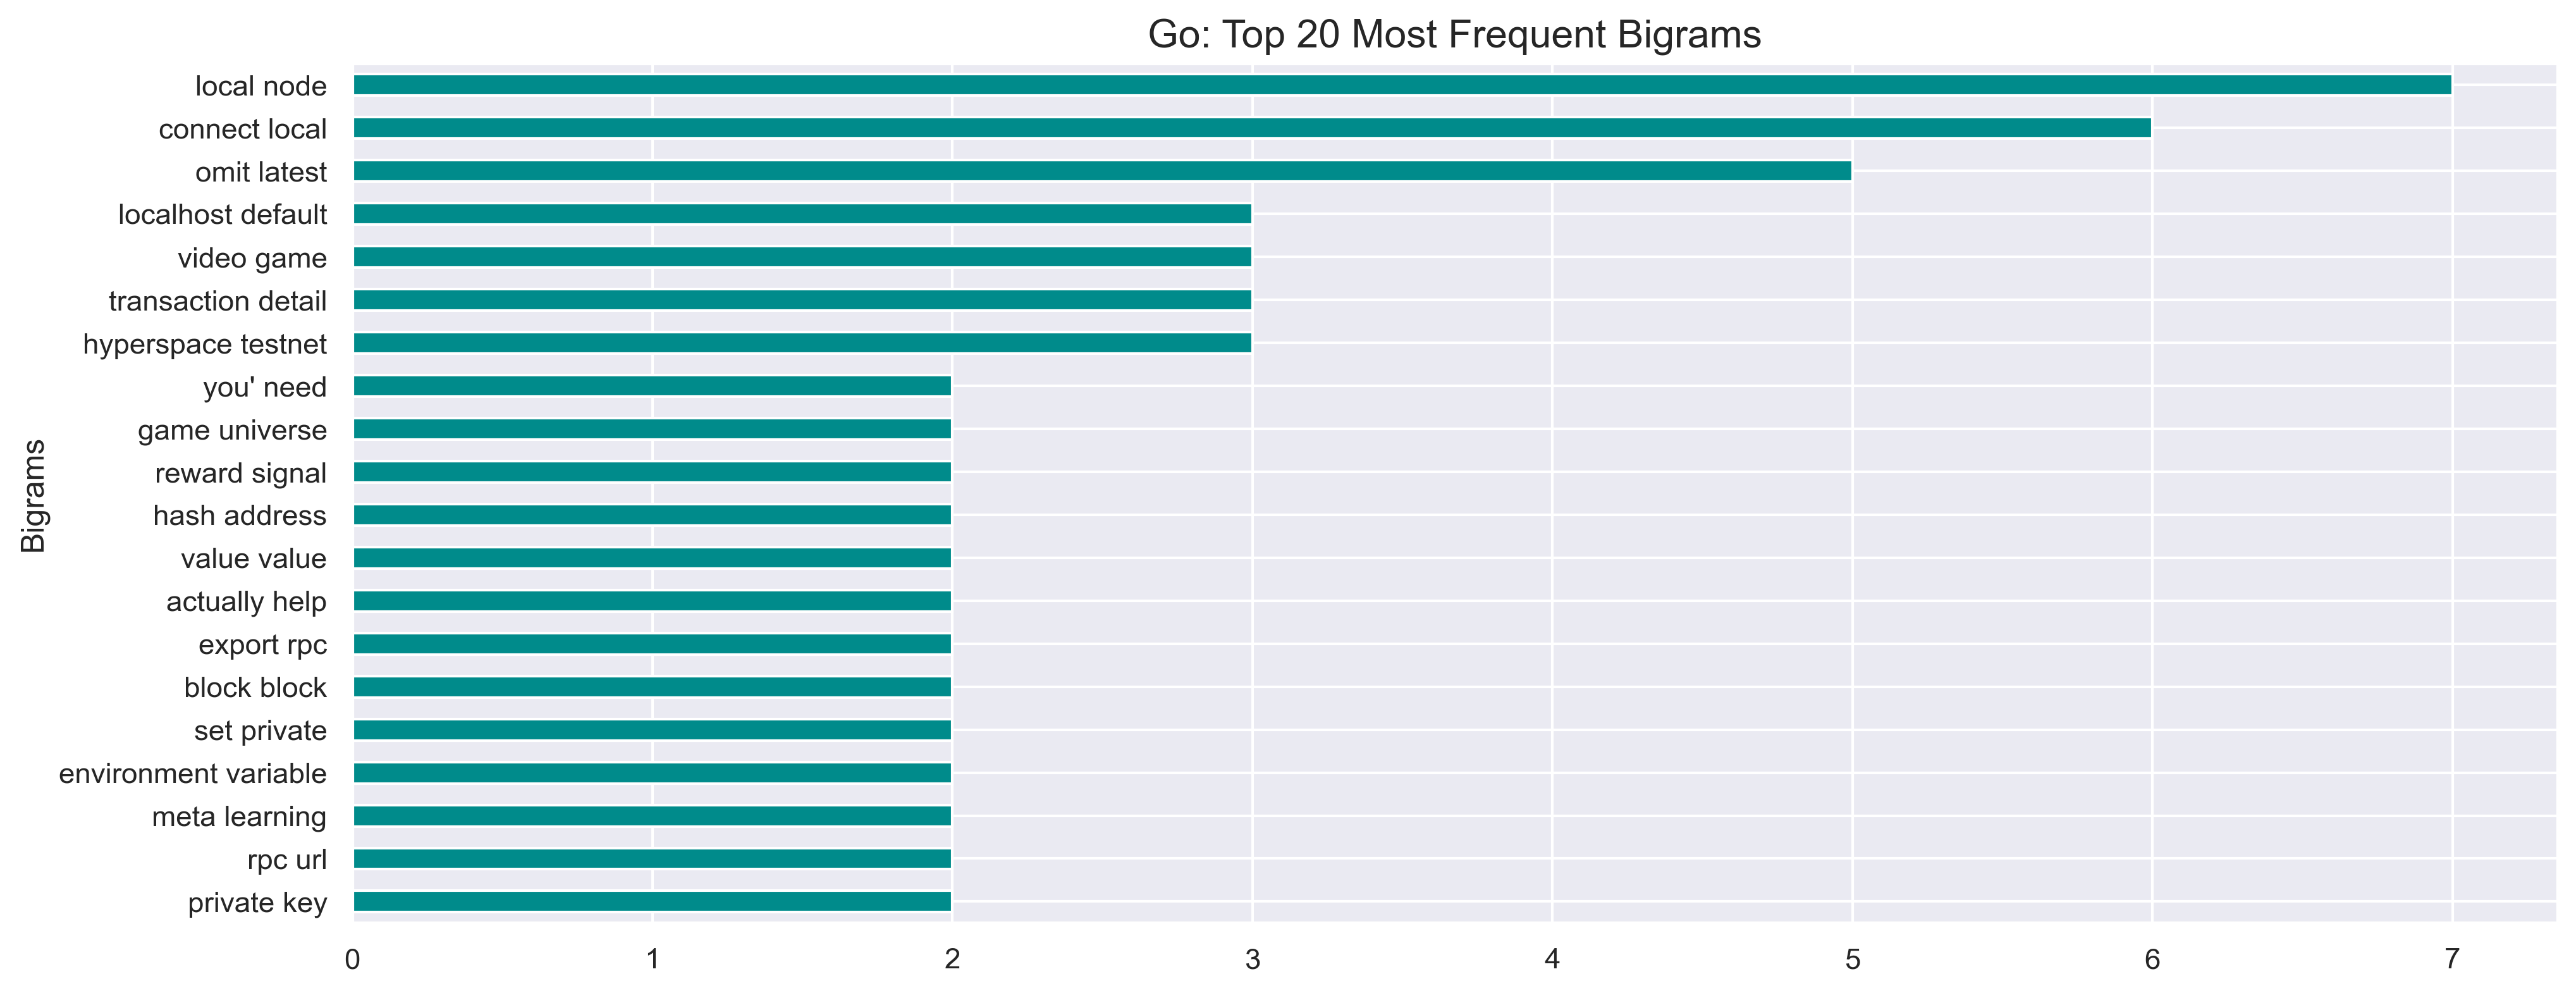

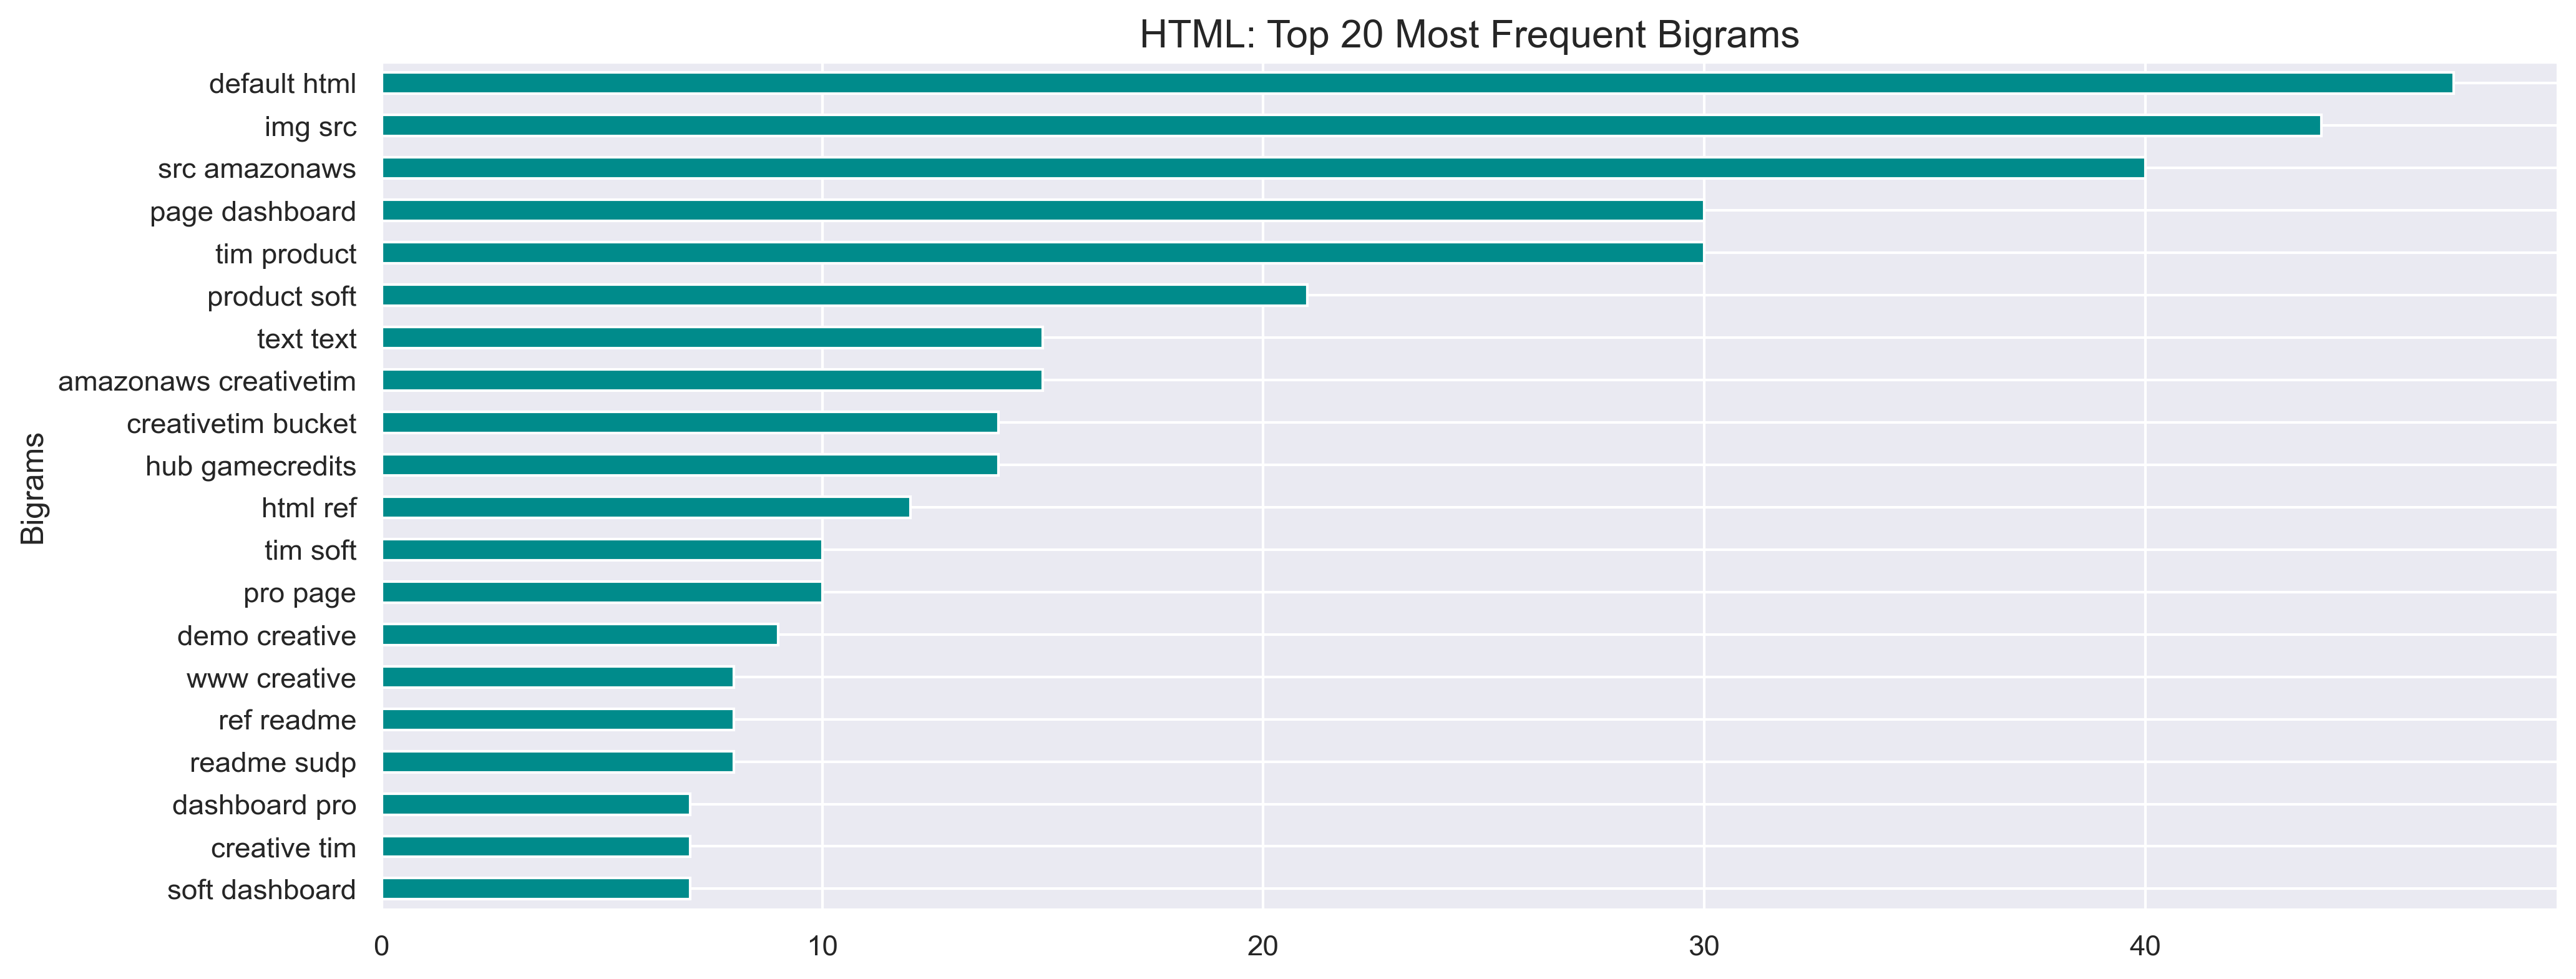

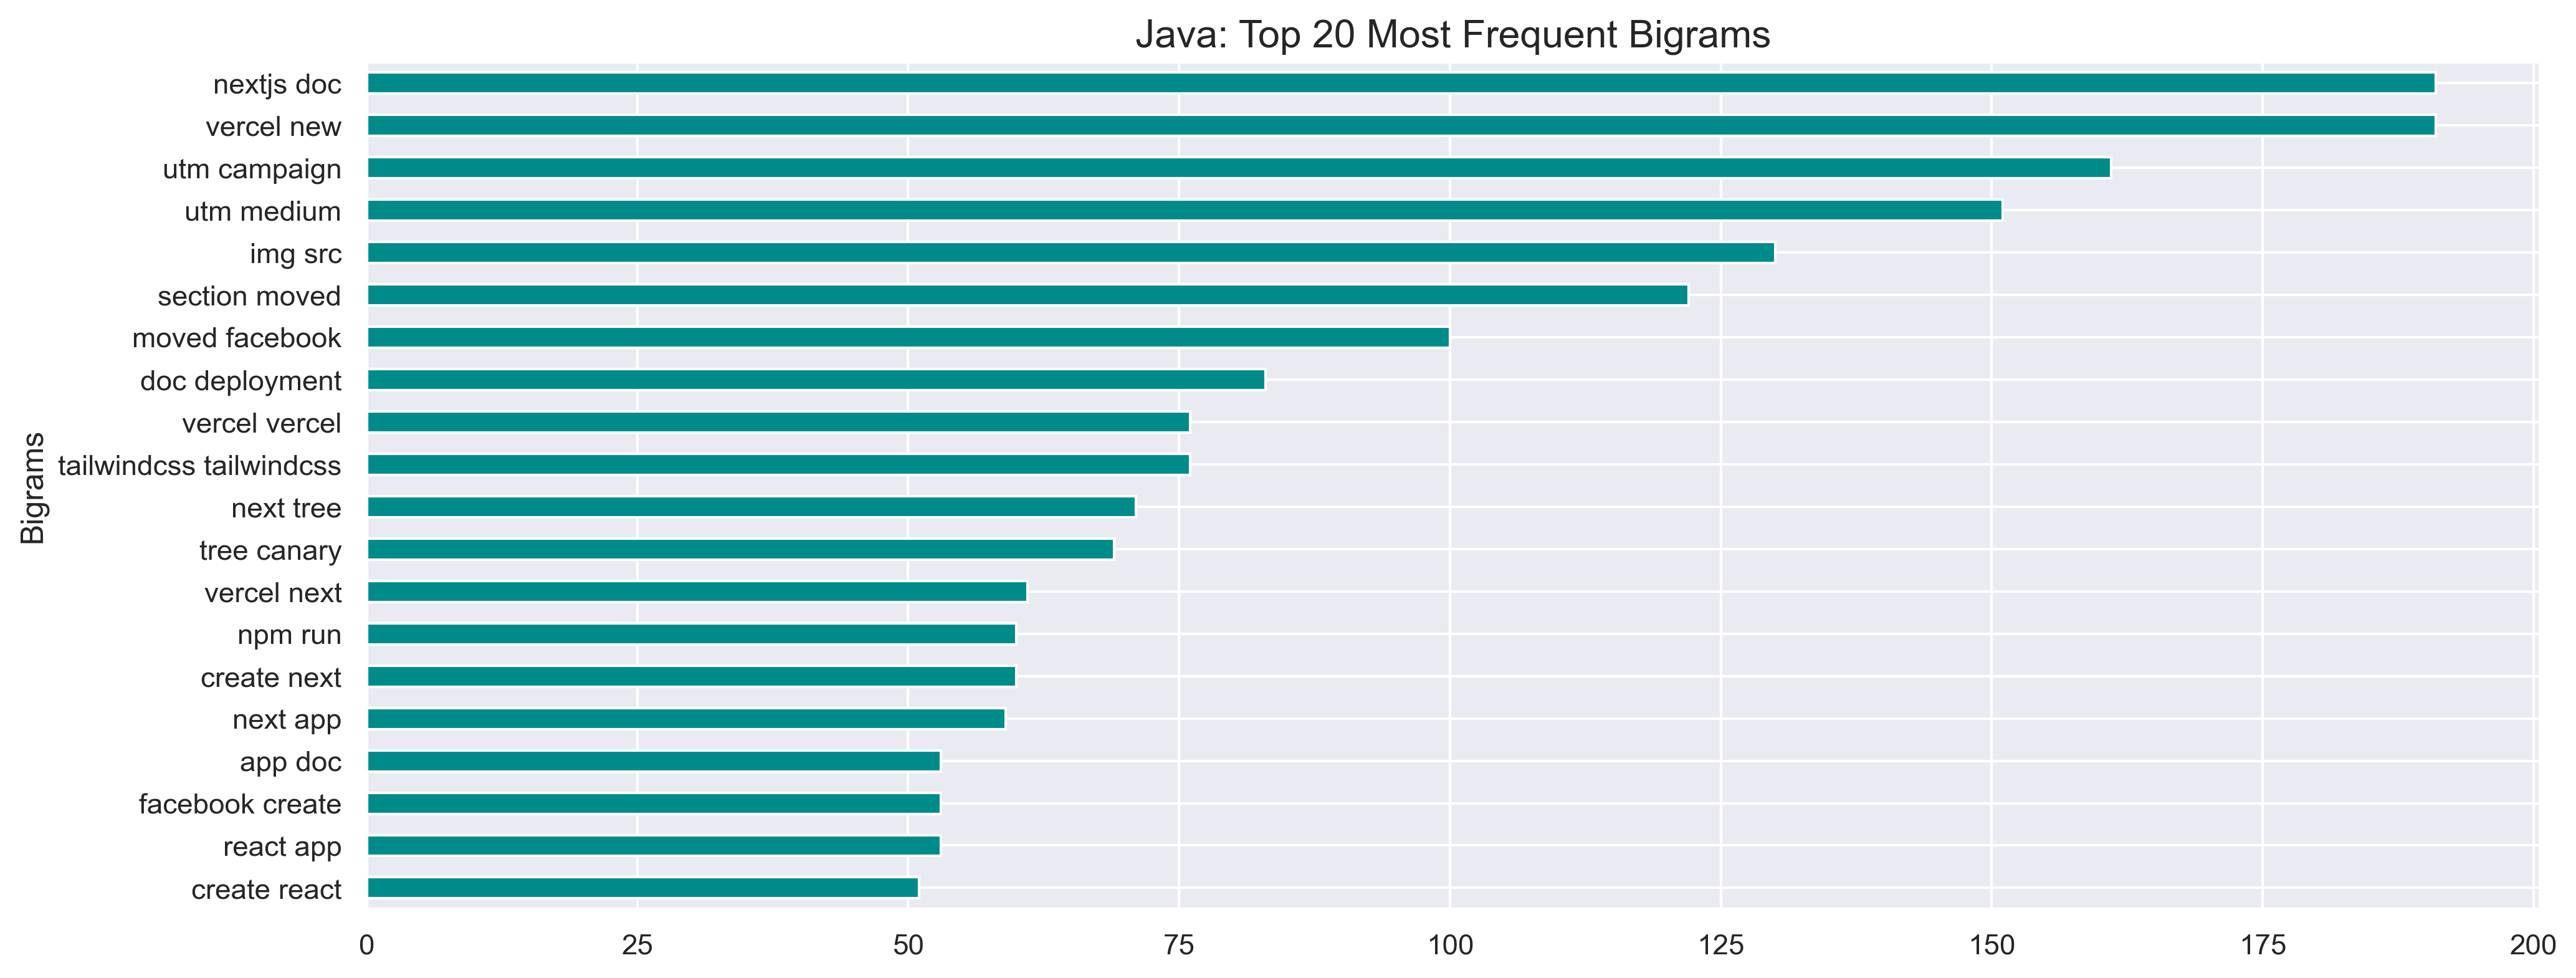

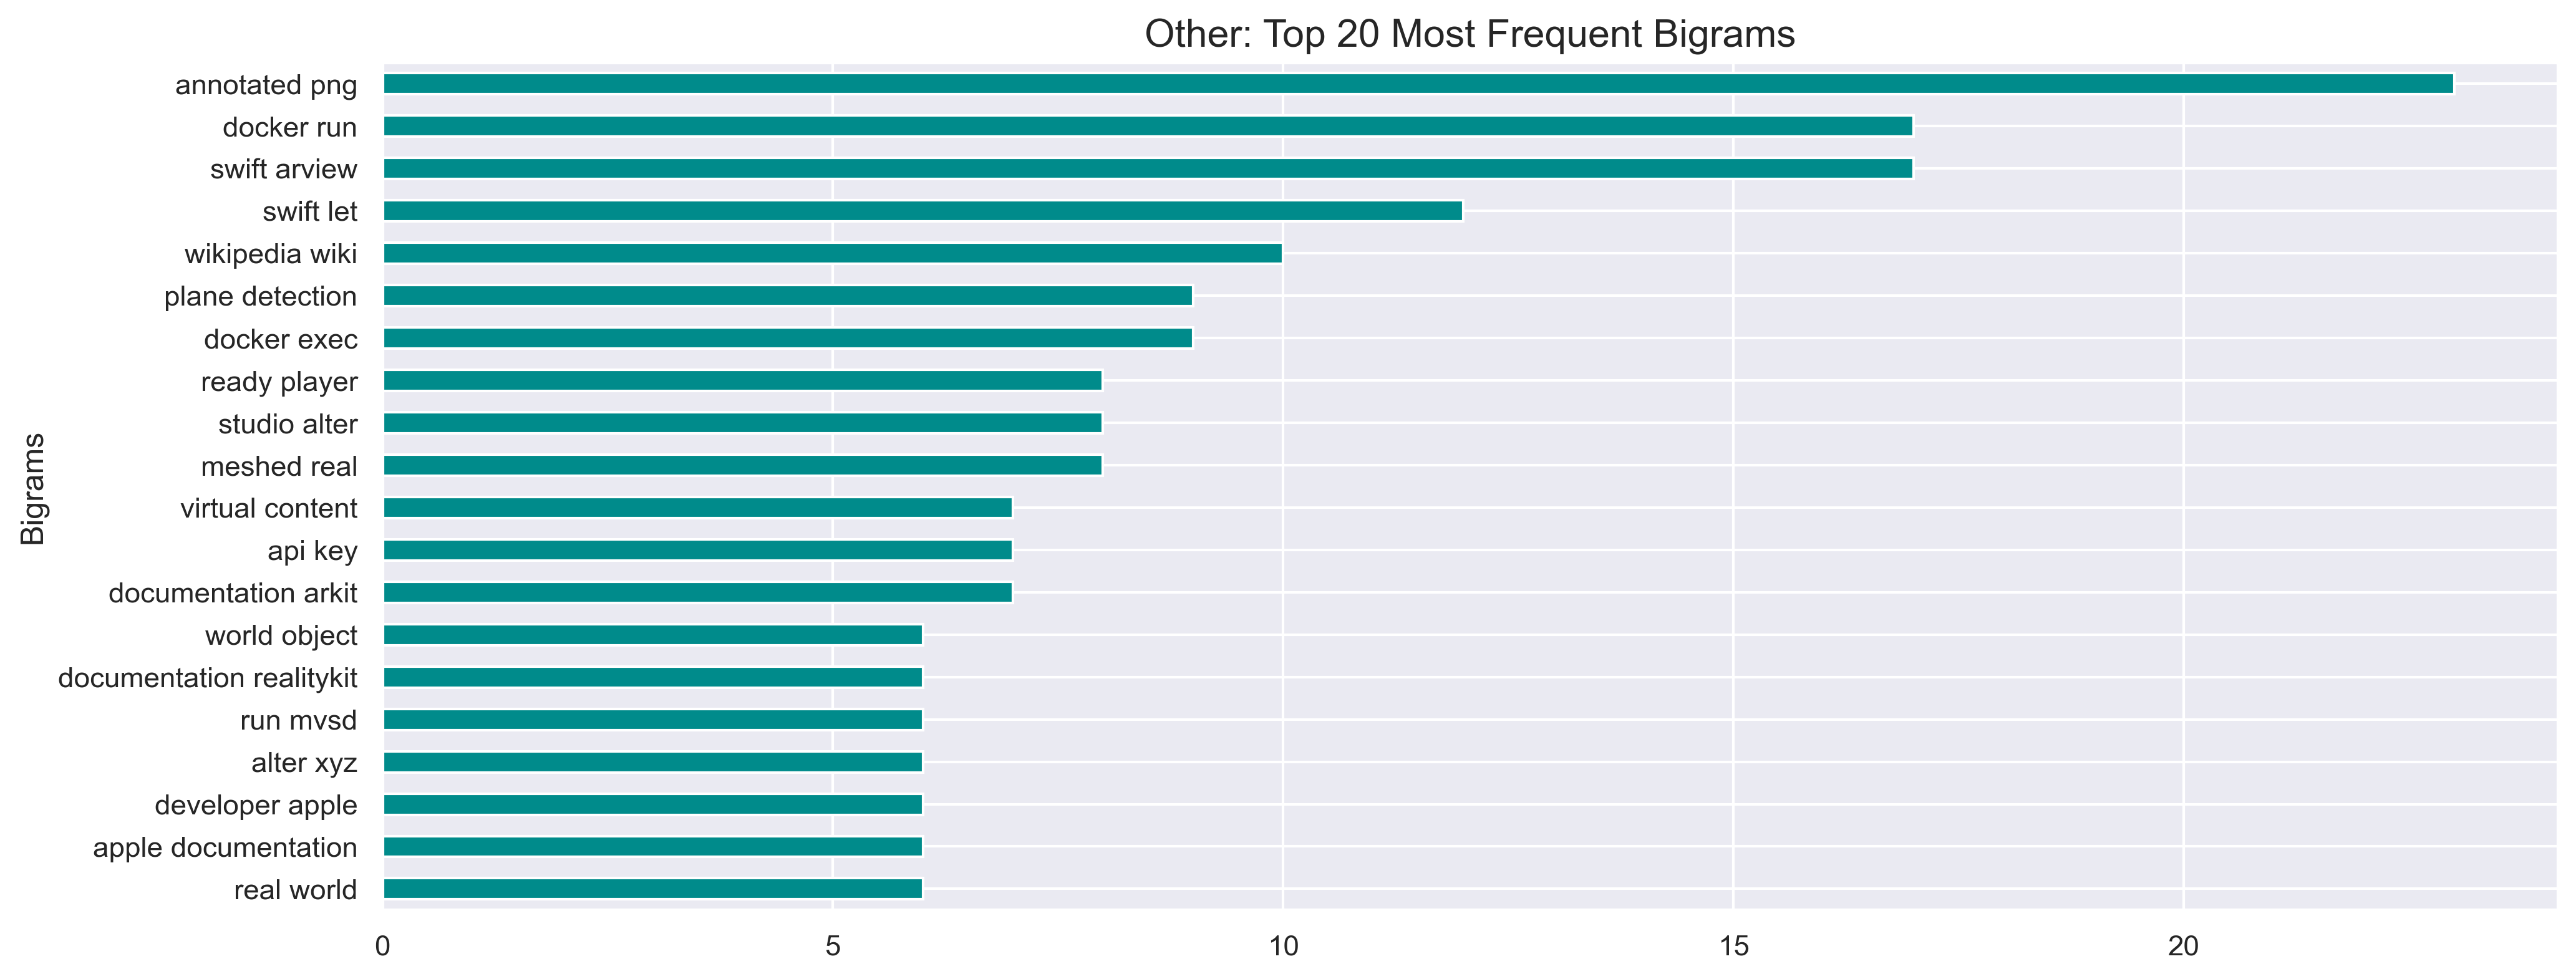

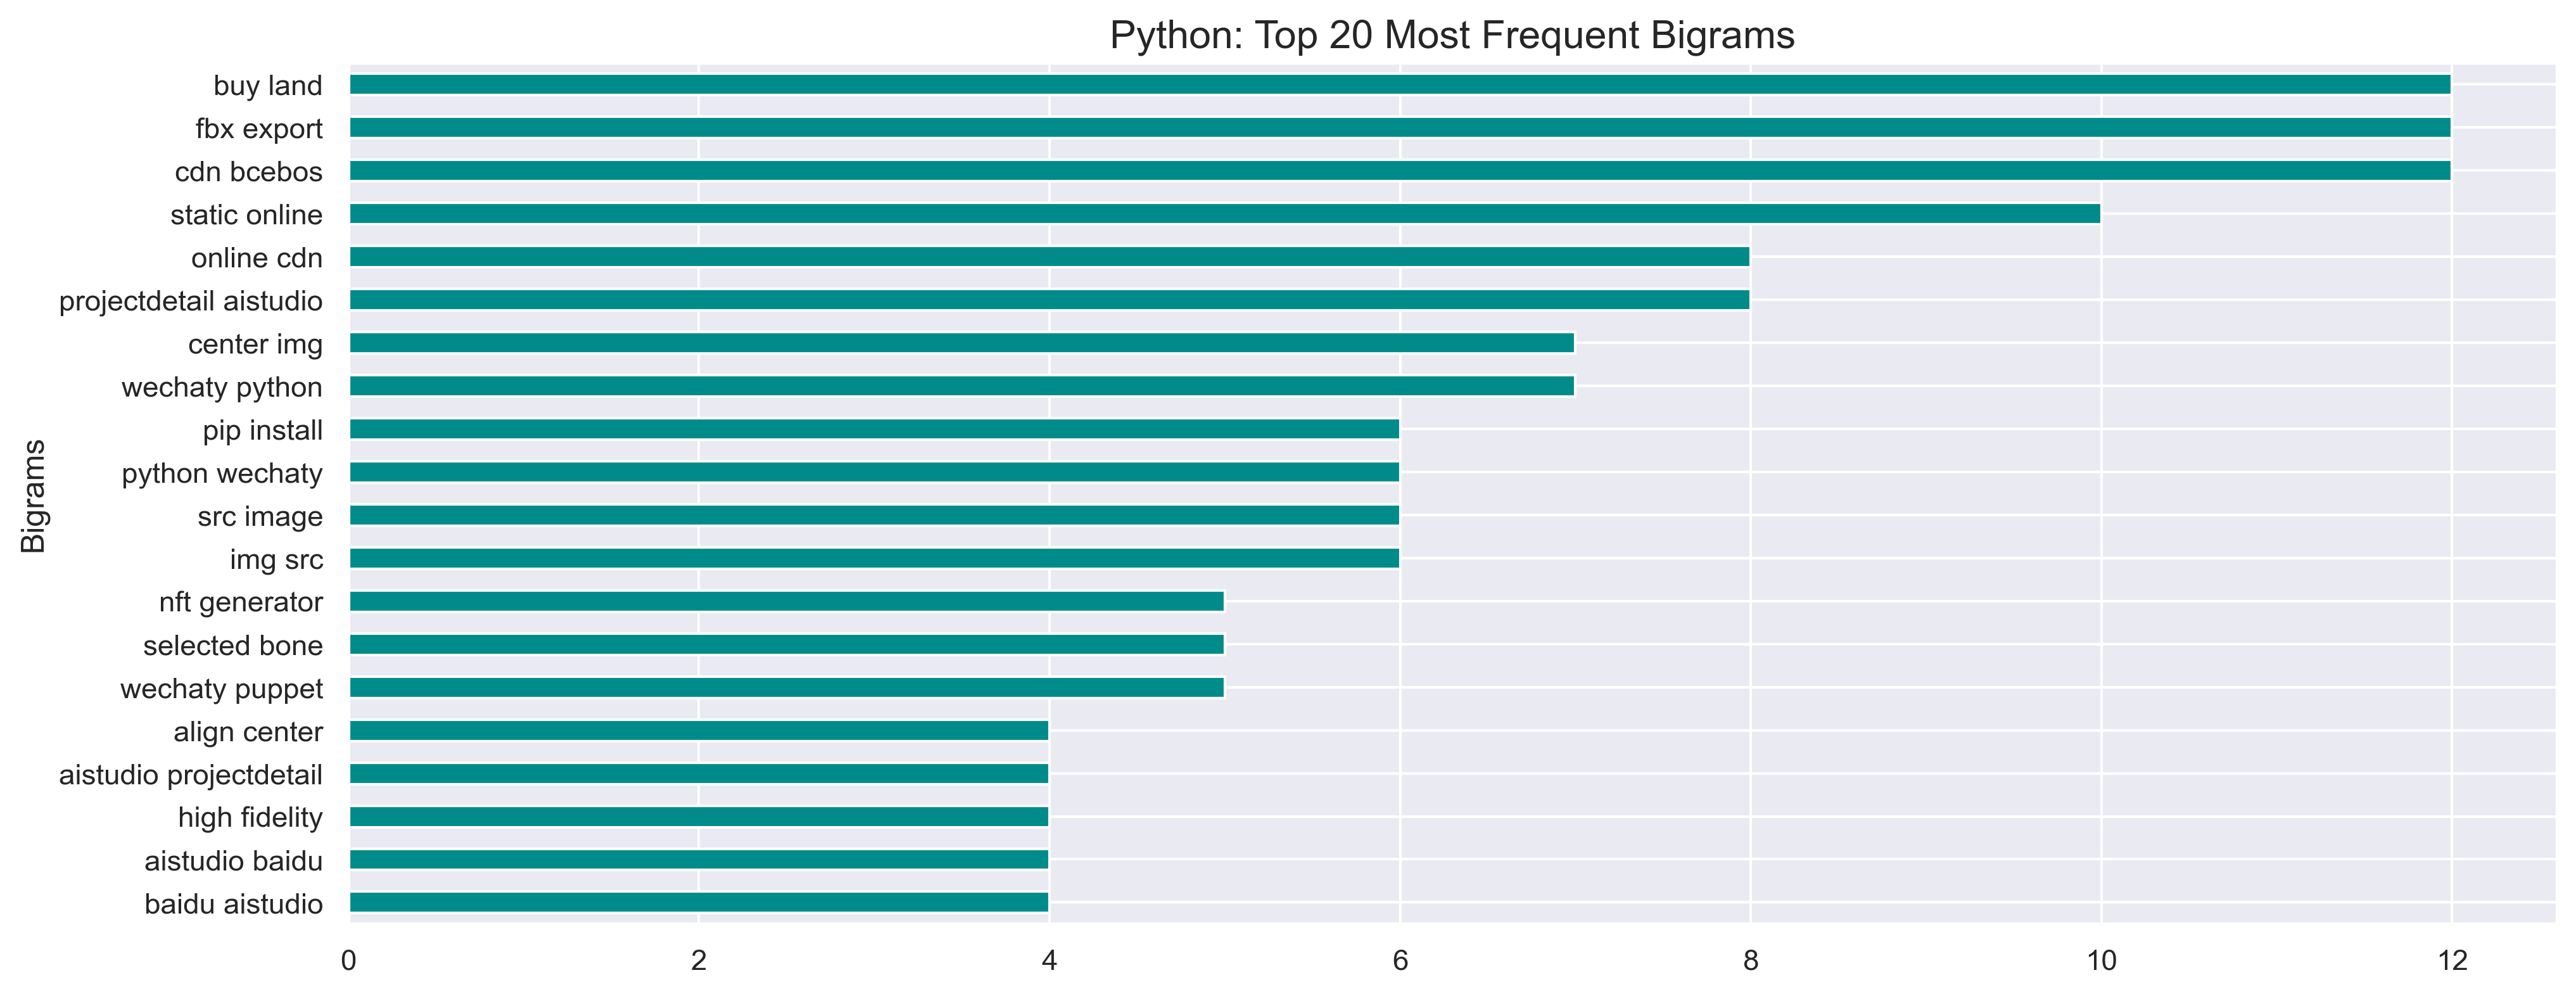

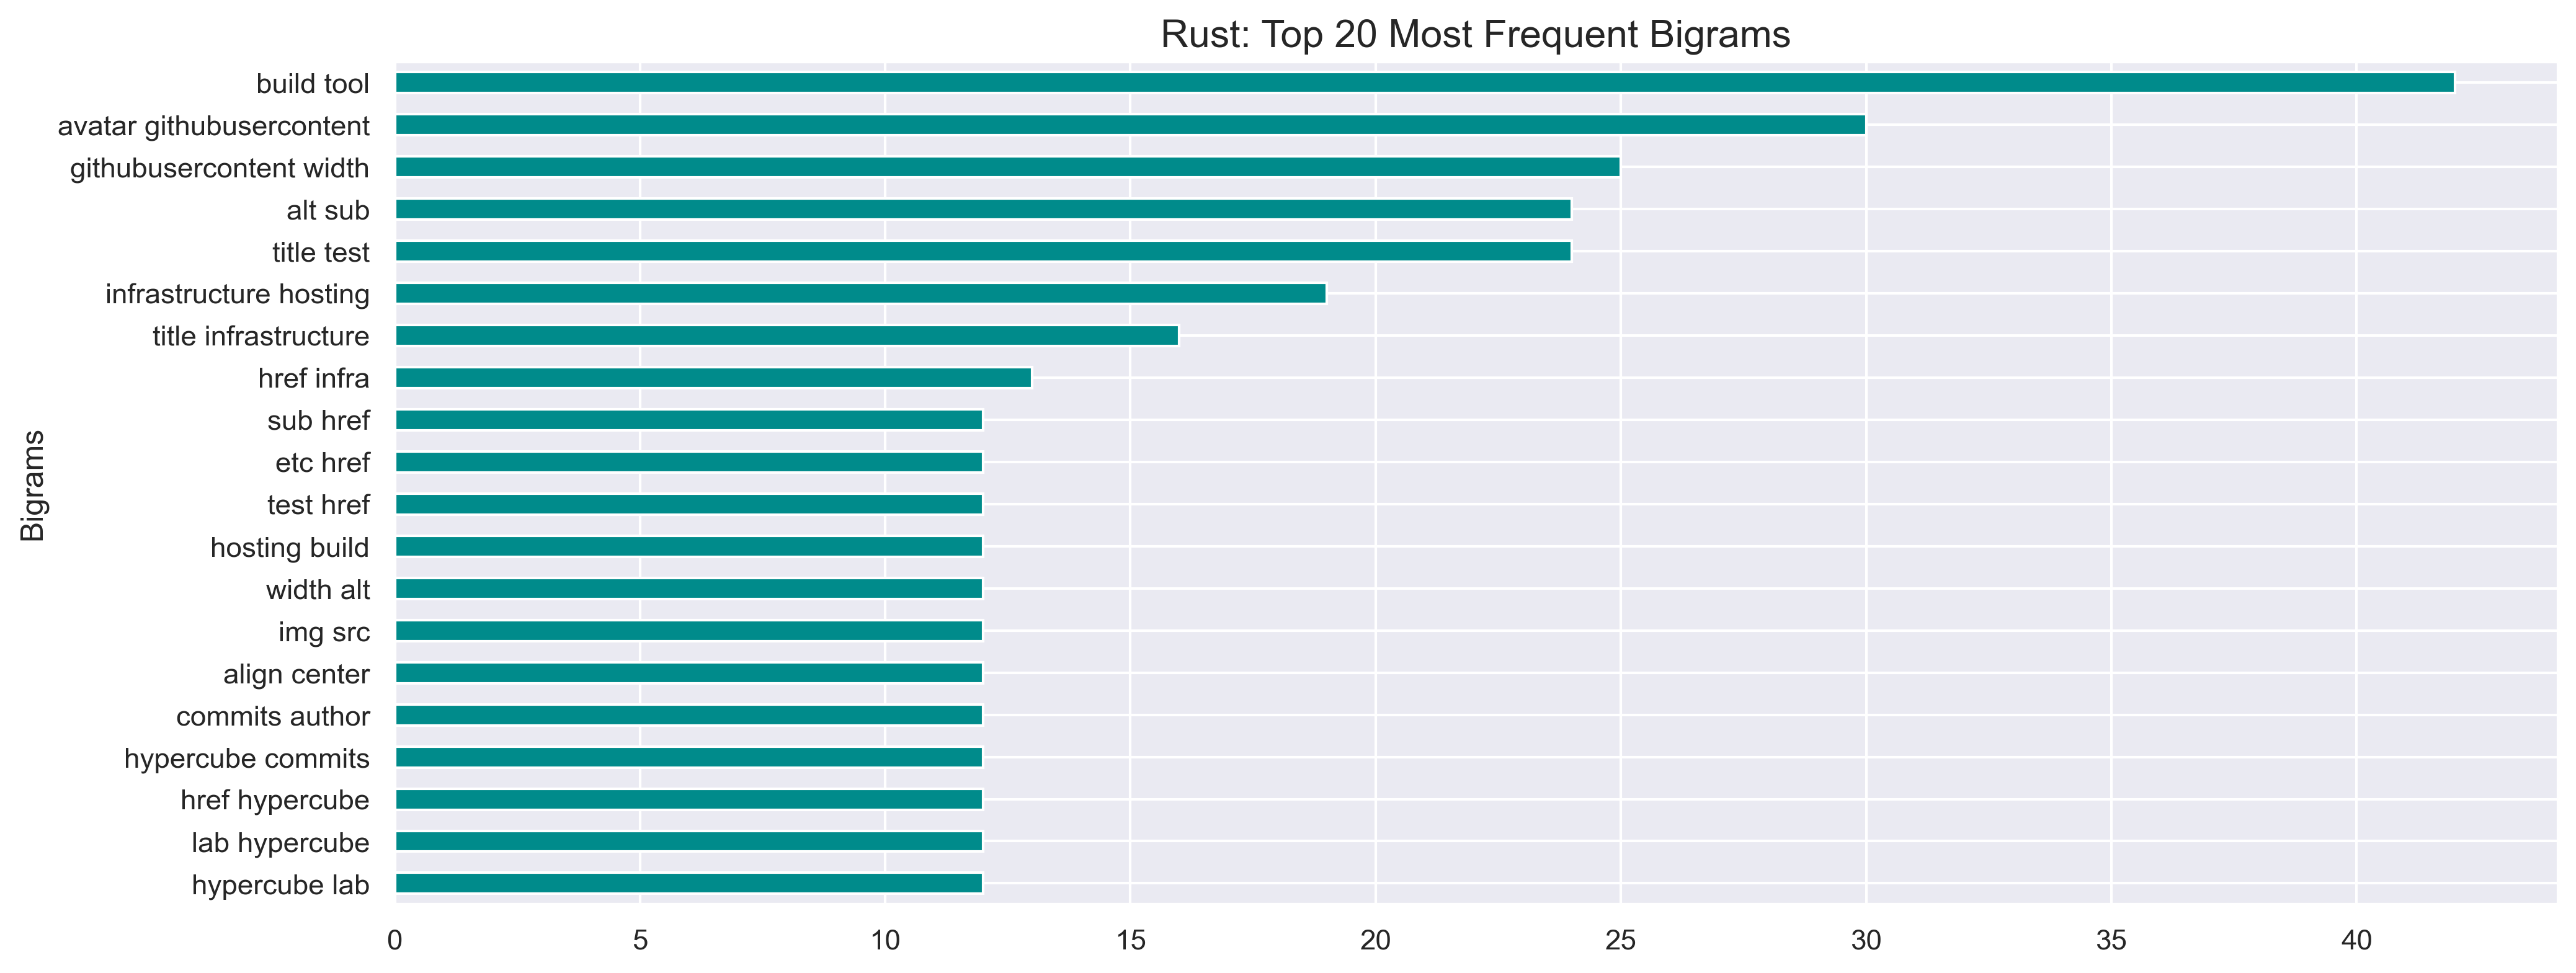

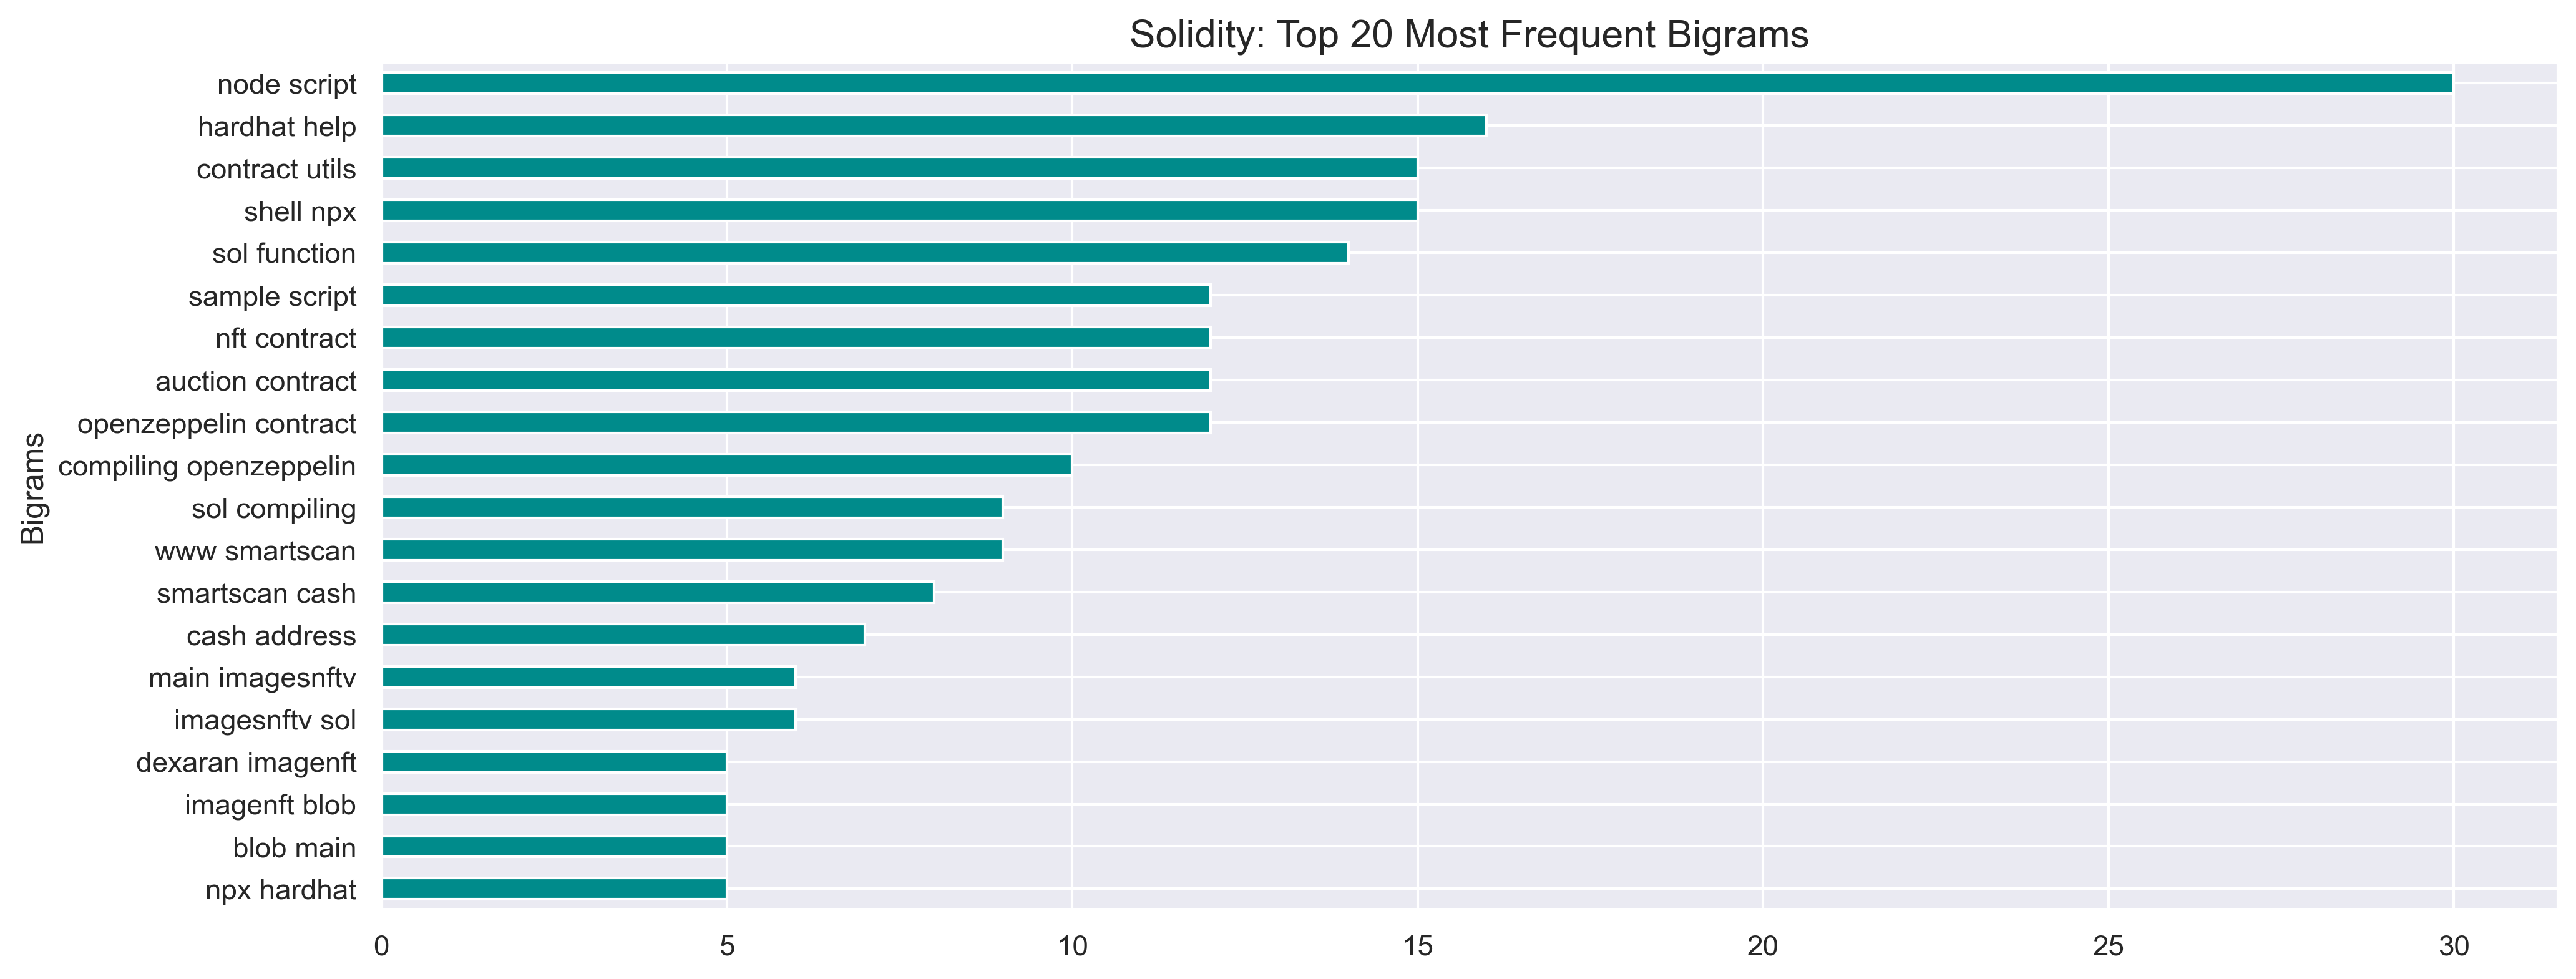

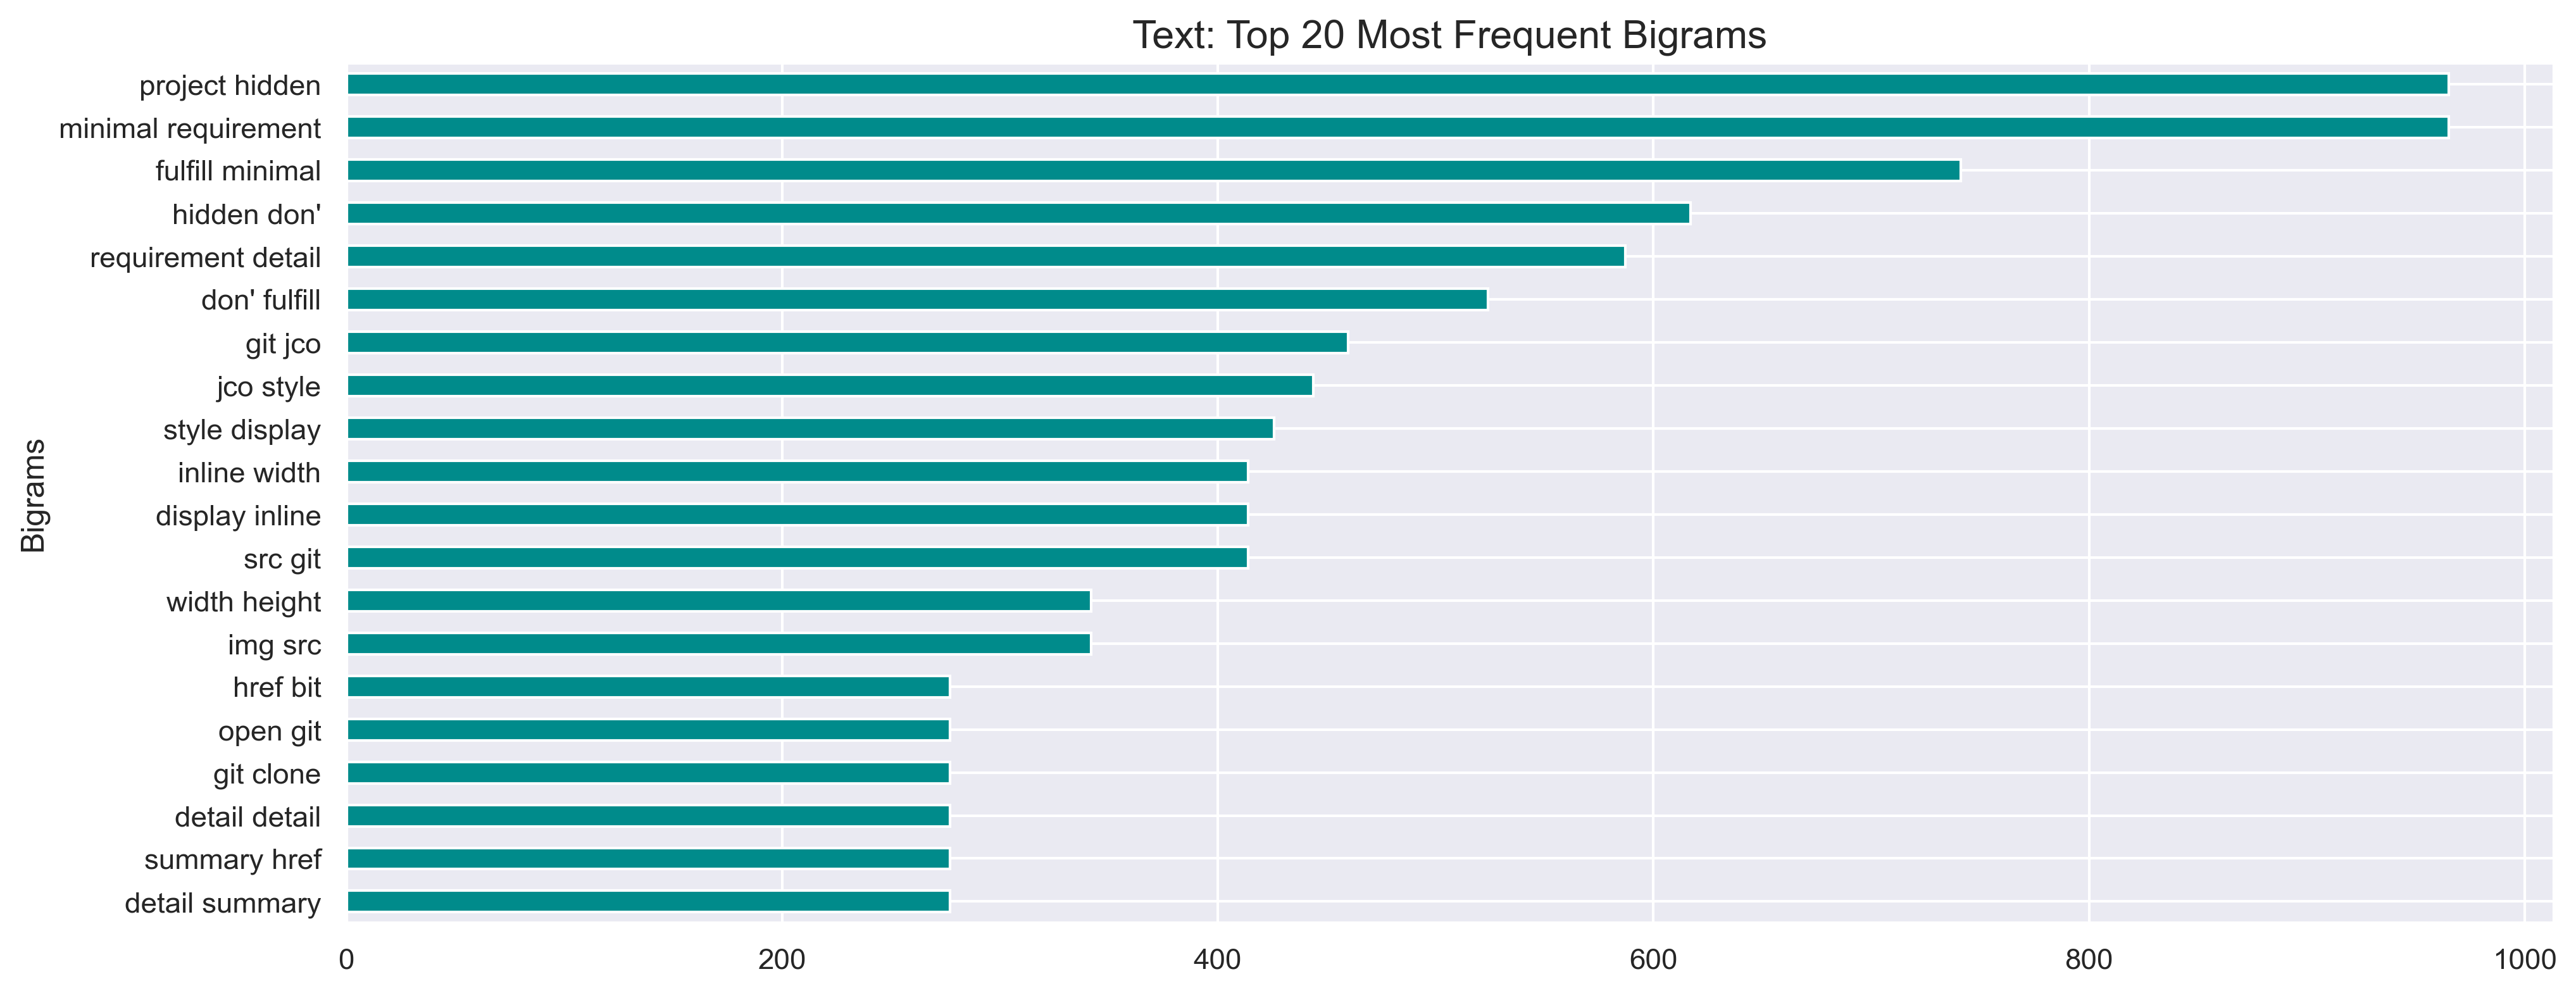

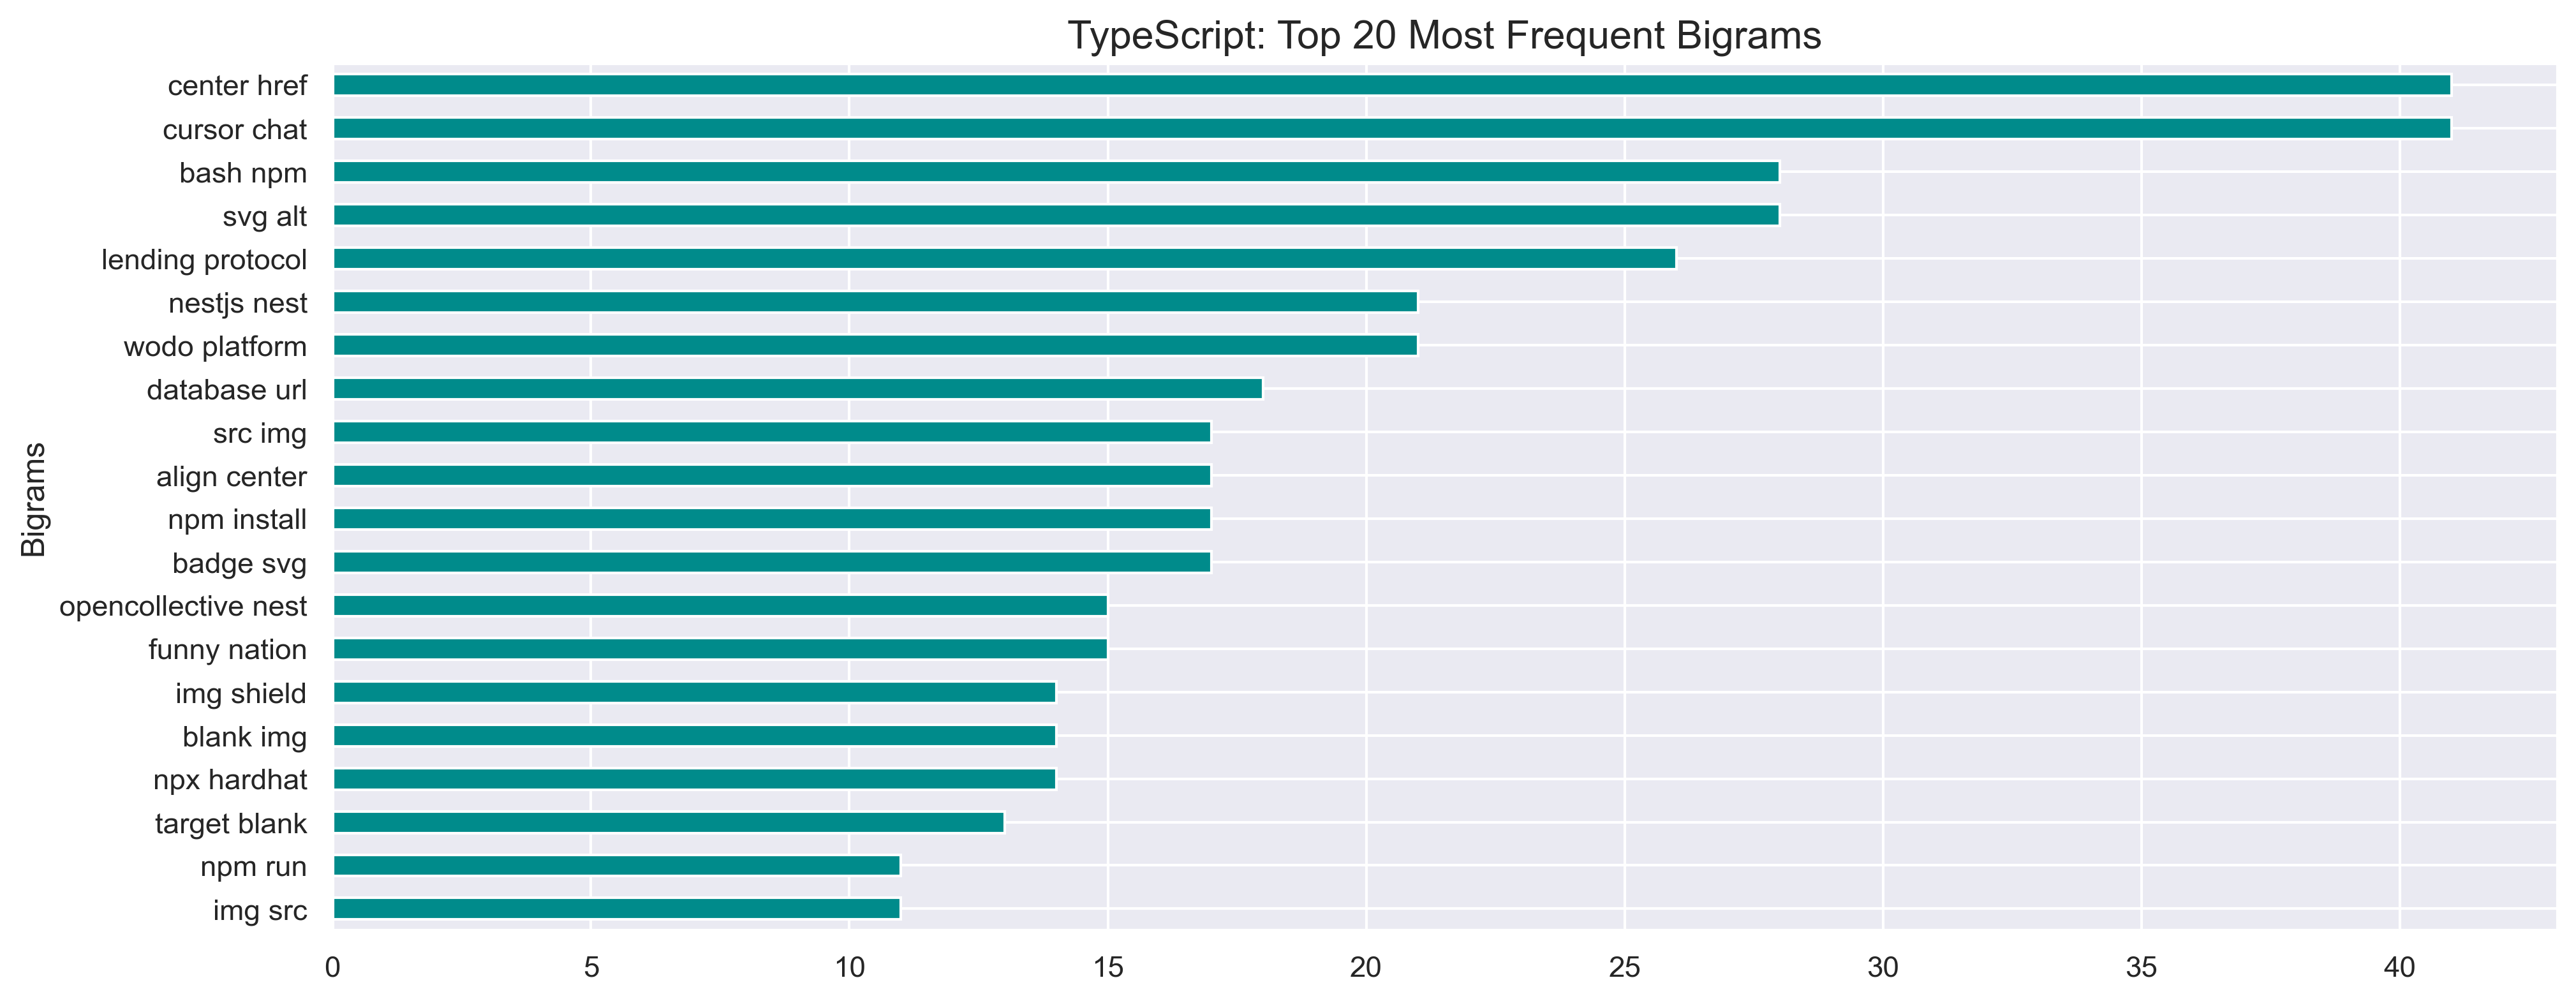

In [38]:
# visualizing bigrams by programming language

frames = [
        all_words, 
        C_words, 
        css_words, 
        go_words, 
        html_words, 
        java_words, 
        other_words, 
        python_words, 
        rust_words, 
        solidity_words,
        text_words,
        typescript_words]

counter = 0

for frame in frames:
        
    # creating the top 20 bigrams for ea. program language
    bigrams = (pd.Series(nltk.ngrams(frame, 2))
                .value_counts()
                .head(20))
    
    # sorting and plotting the bigrams
    bigrams.sort_values().plot.barh(figsize=(15, 6), color = "darkcyan")

    plt.title(f'{languages[counter]}: Top 20 Most Frequent Bigrams', fontsize = 15)
    plt.ylabel('Bigrams')
    plt.xlabel(None)

    # cleaning the bigram labels
    ticks, _ = plt.yticks()
    labels = bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)

    # update counter 
    counter += 1

    plt.show()

In [39]:
languages

['All Words',
 'C',
 'CSS',
 'Go',
 'HTML',
 'Java',
 'Other',
 'Python',
 'Rust',
 'Solidity',
 'Text',
 'TypeScript']

In [40]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.

frames = [
        all_words, 
        C_words, 
        css_words, 
        go_words, 
        html_words, 
        java_words, 
        other_words, 
        python_words, 
        rust_words, 
        solidity_words, 
        text_words,
        typescript_words]

languages = [ 
    'All Words',
    'C',
    'CSS',
    'Go',
    'HTML',
    'Java',
    'Other',
    'Python',
    'Rust',
    'Solidity',
    'Text',
    'TypeScript']

#%%
# for i in range(len(frames)):
        
#     # creating the top 20 bigrams for ea. program language
#     top_20_bigrams = (pd.Series(nltk.ngrams(frames[i], 2))
#                 .value_counts()
#                 .head(20))
   
#     # extracting top 2 simulataneously seen words in ea. language dataset         
#     data = {k[0] + ' ' + k[1]: v for k, v in top_20_bigrams.to_dict().items()}
    
#     img = WordCloud(
#         background_color='white',
#         collocations = False,
#         colormap = "BuPu_r", 
#         width=3000, height=2000).generate_from_frequencies(data)

#     plt.title(languages[i], loc = "left", fontsize = 10, color = "darkred")
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()


In [41]:
# what about as a dataframe?

----
### ``Trigrams: Top 10 most Frequent Trigrams by Programming Language``

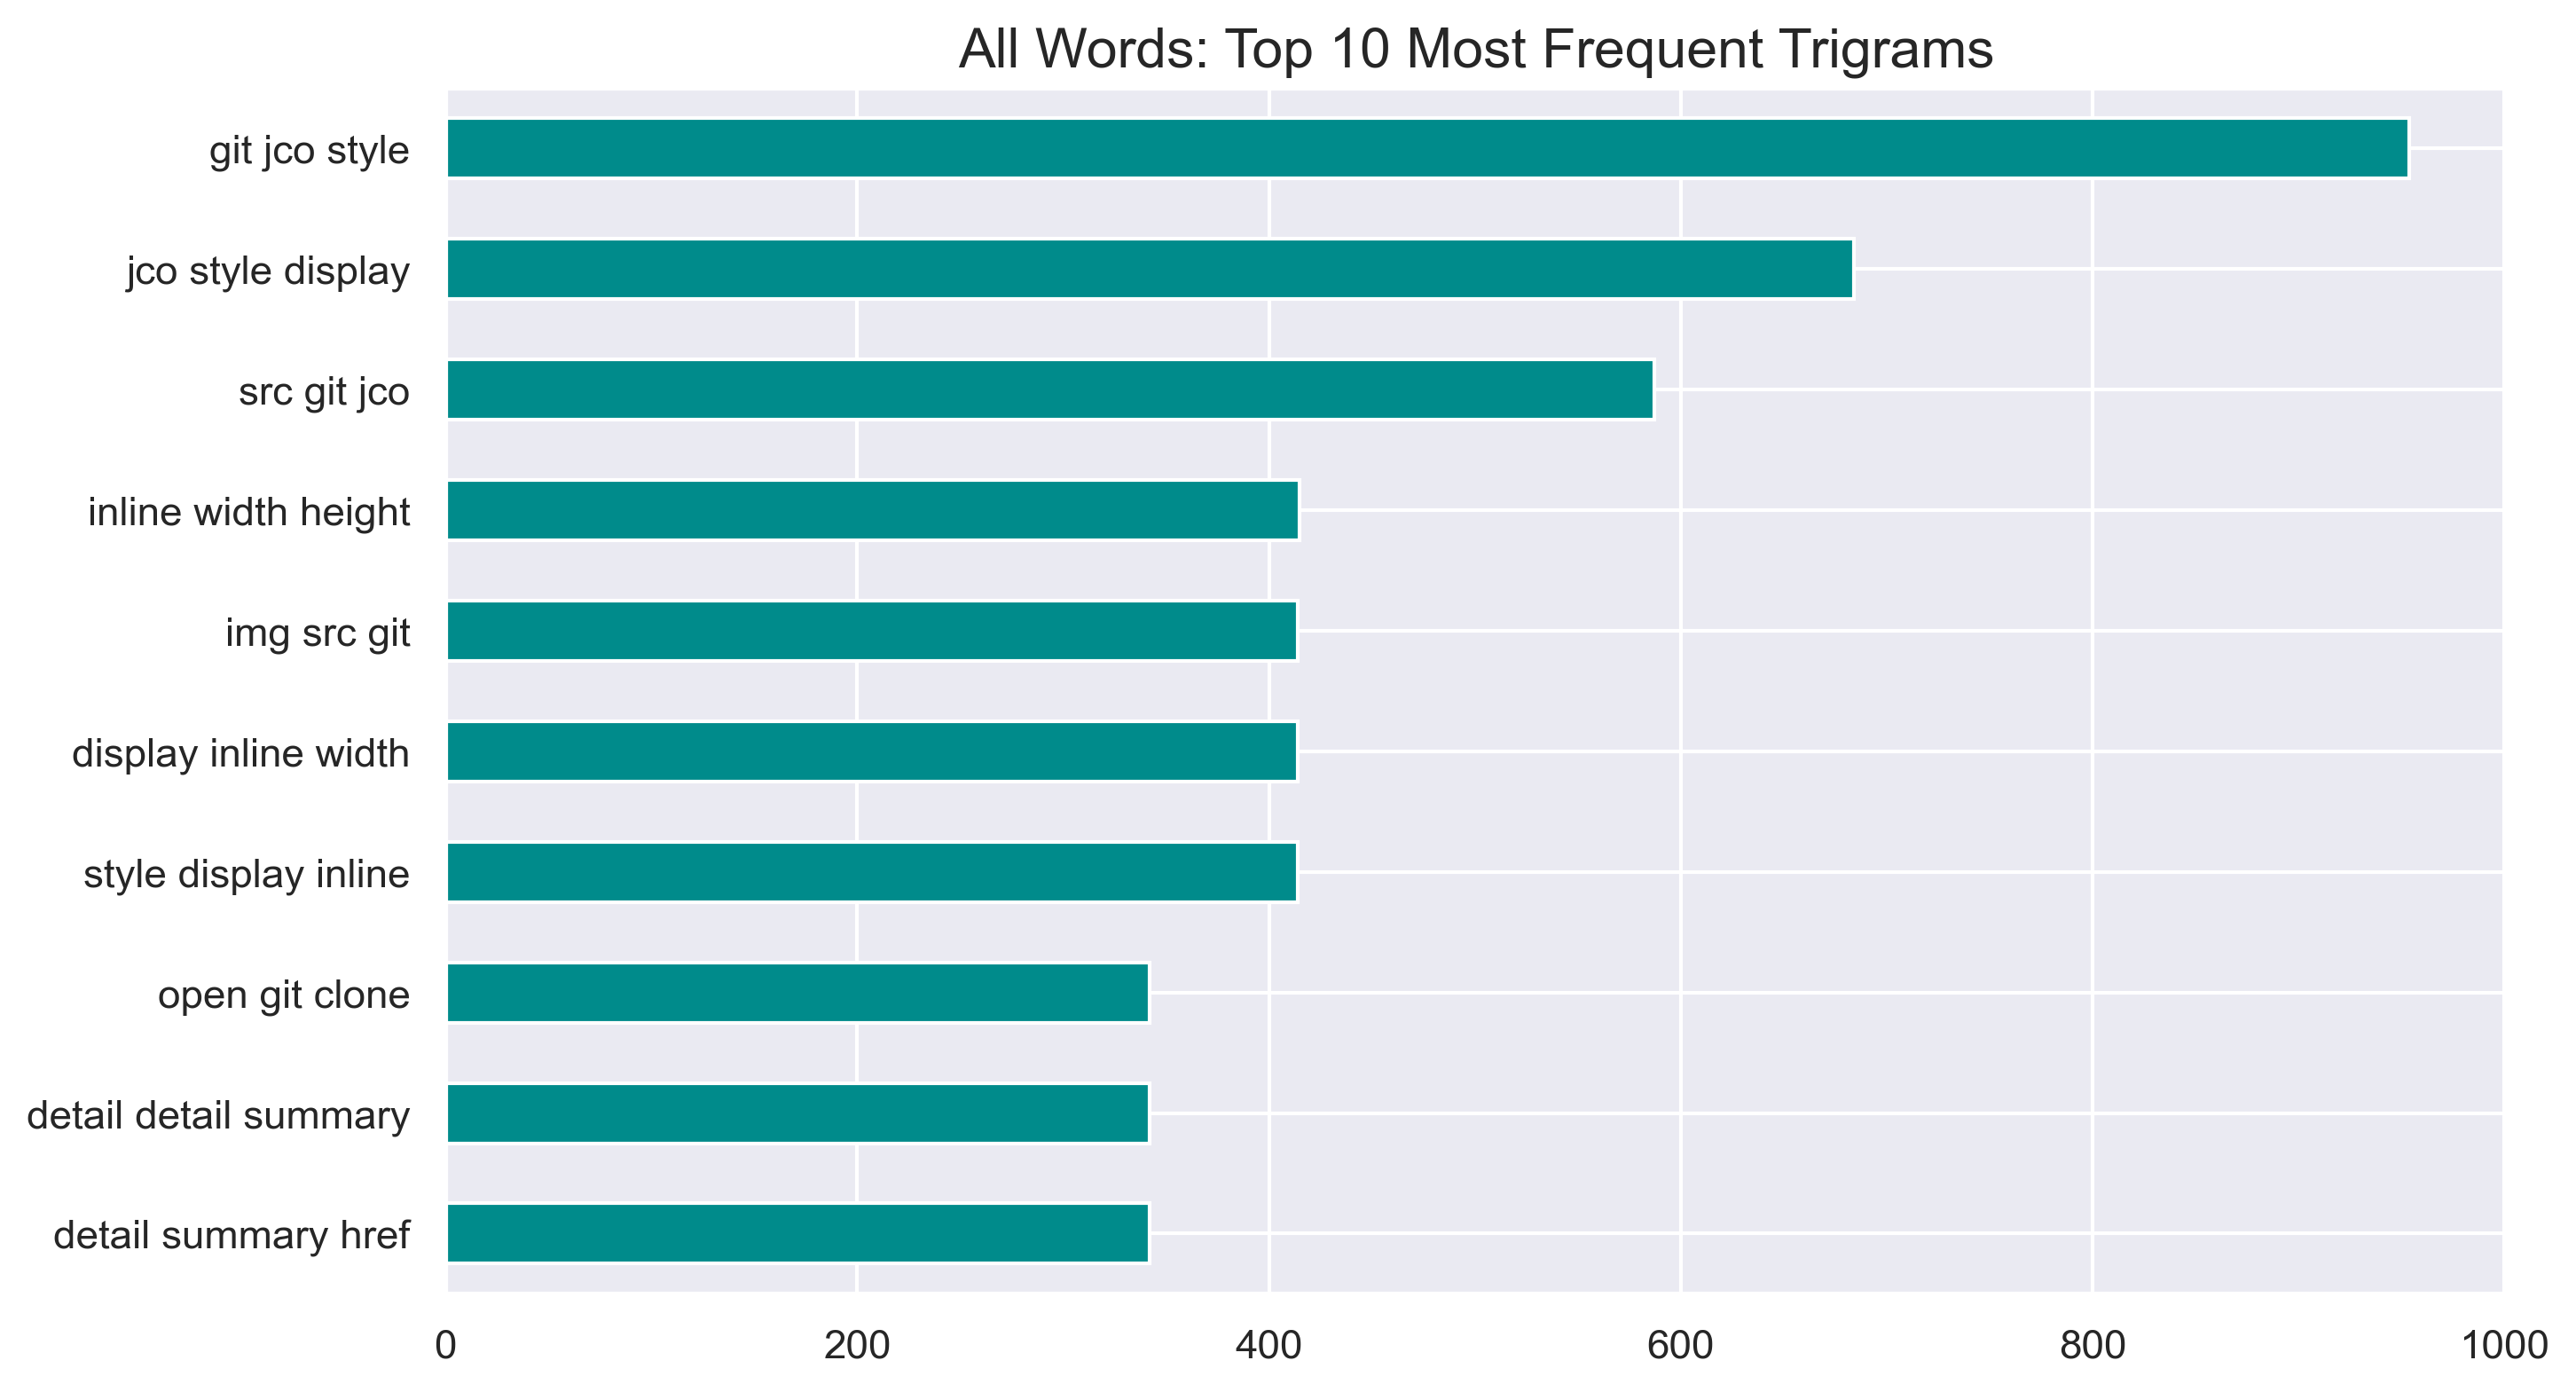

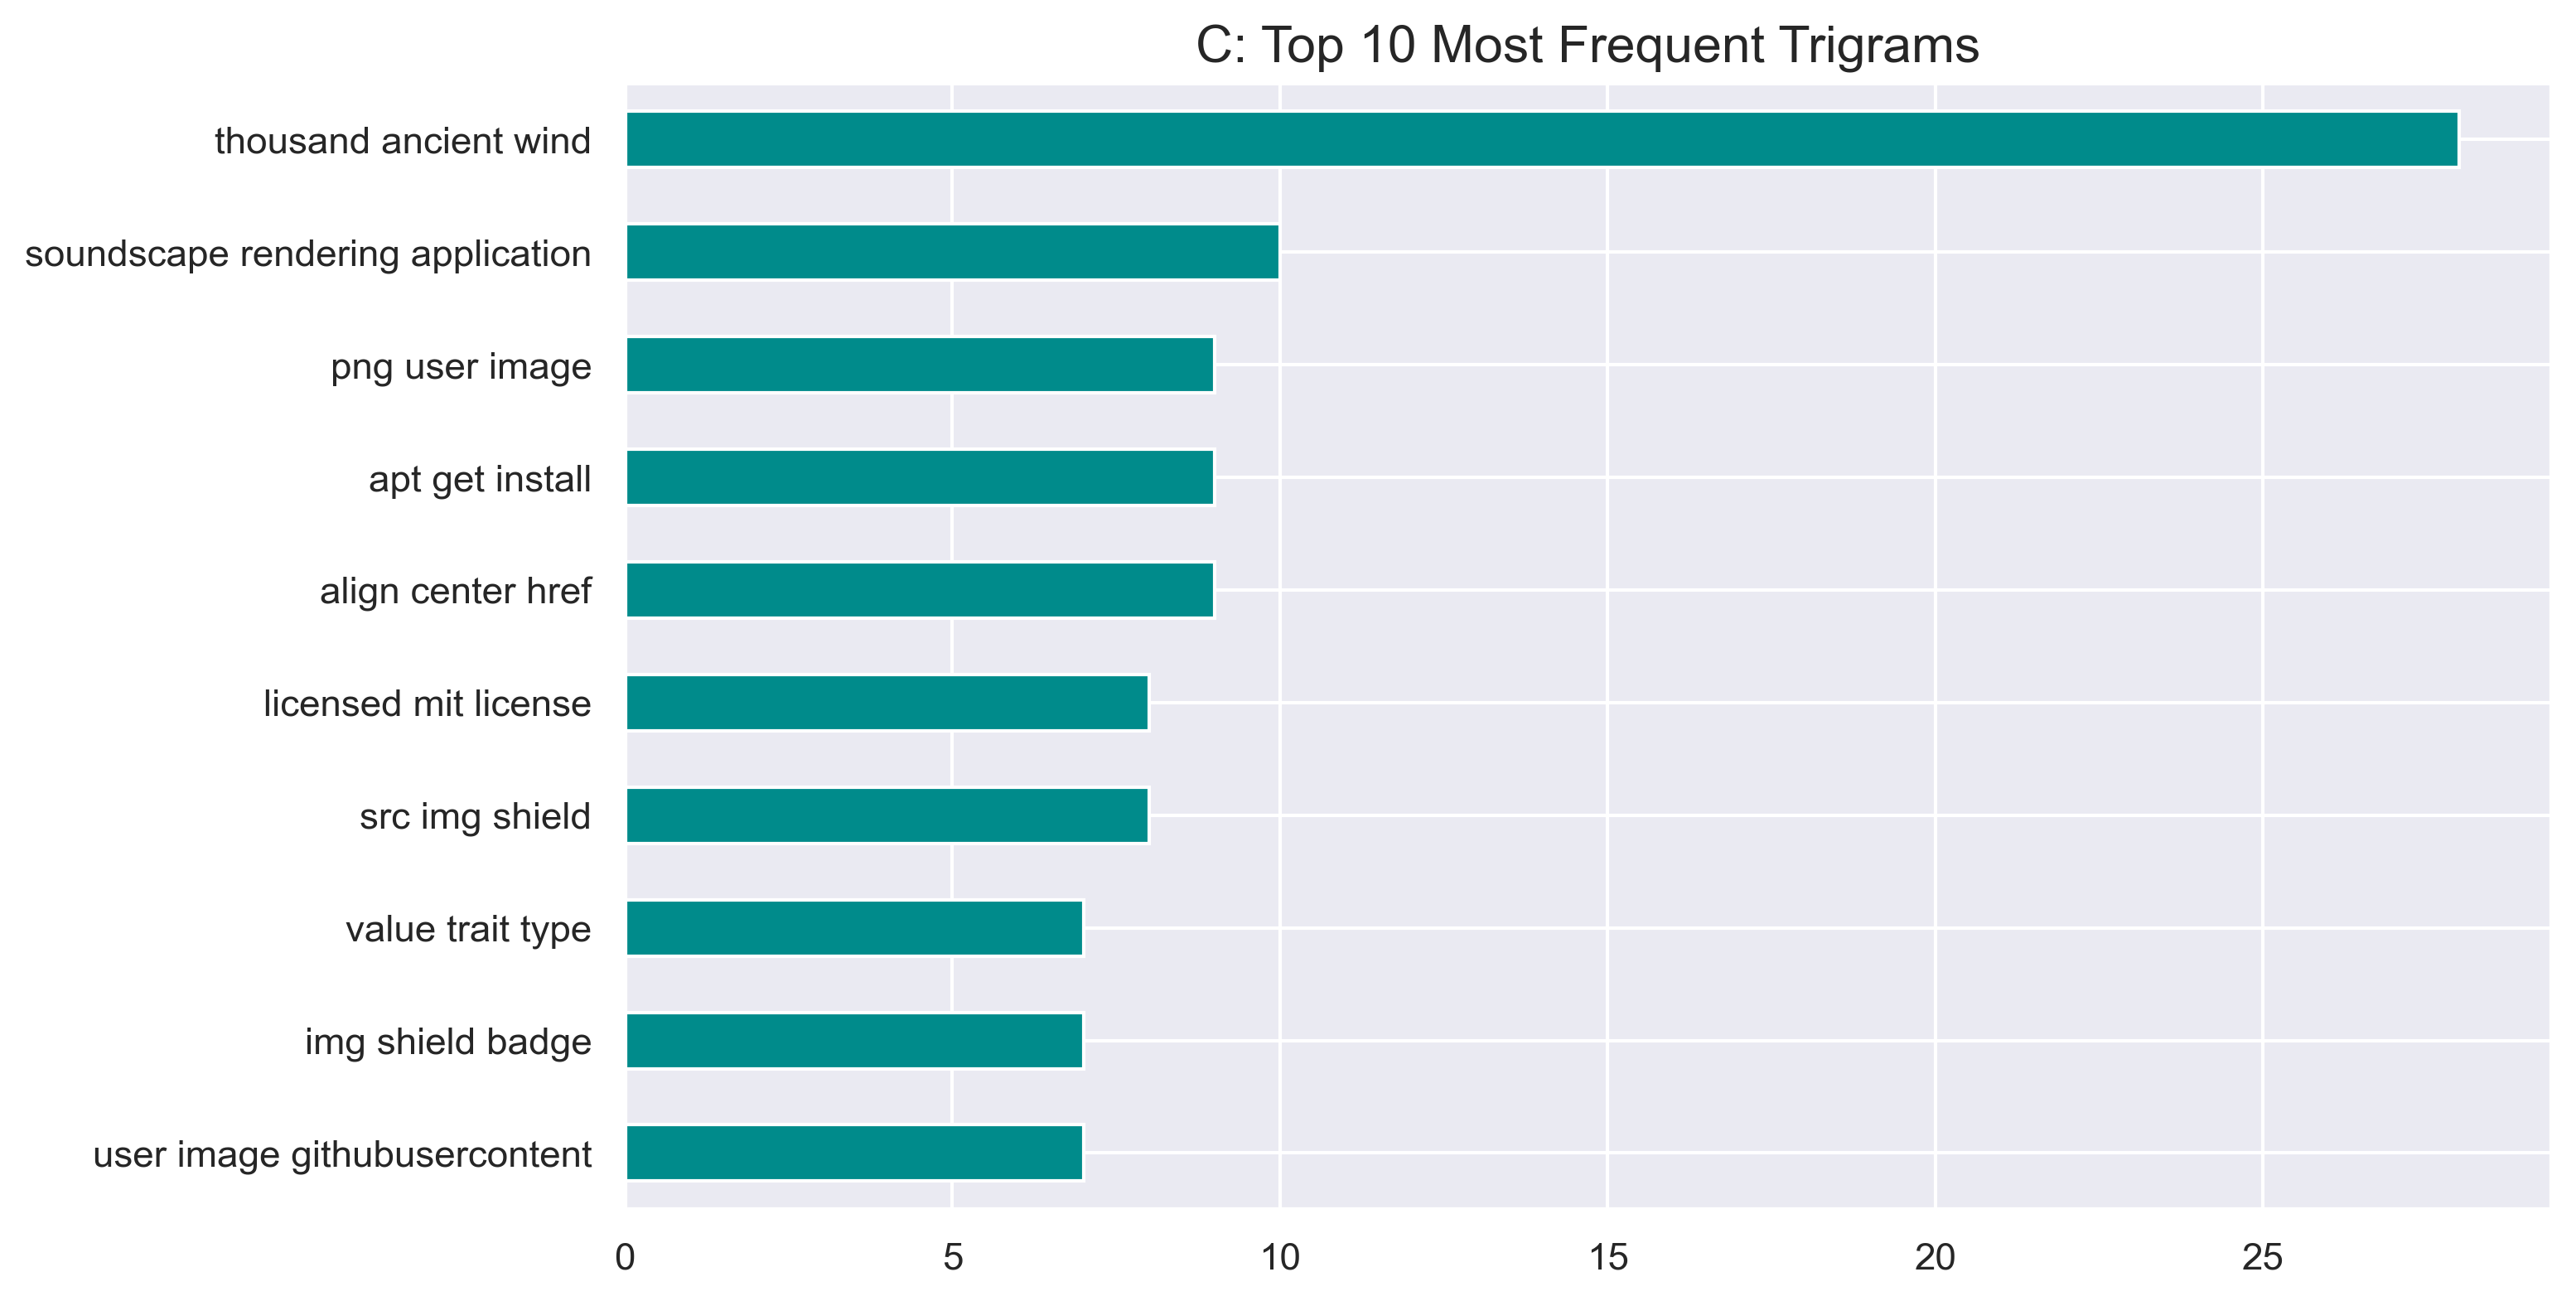

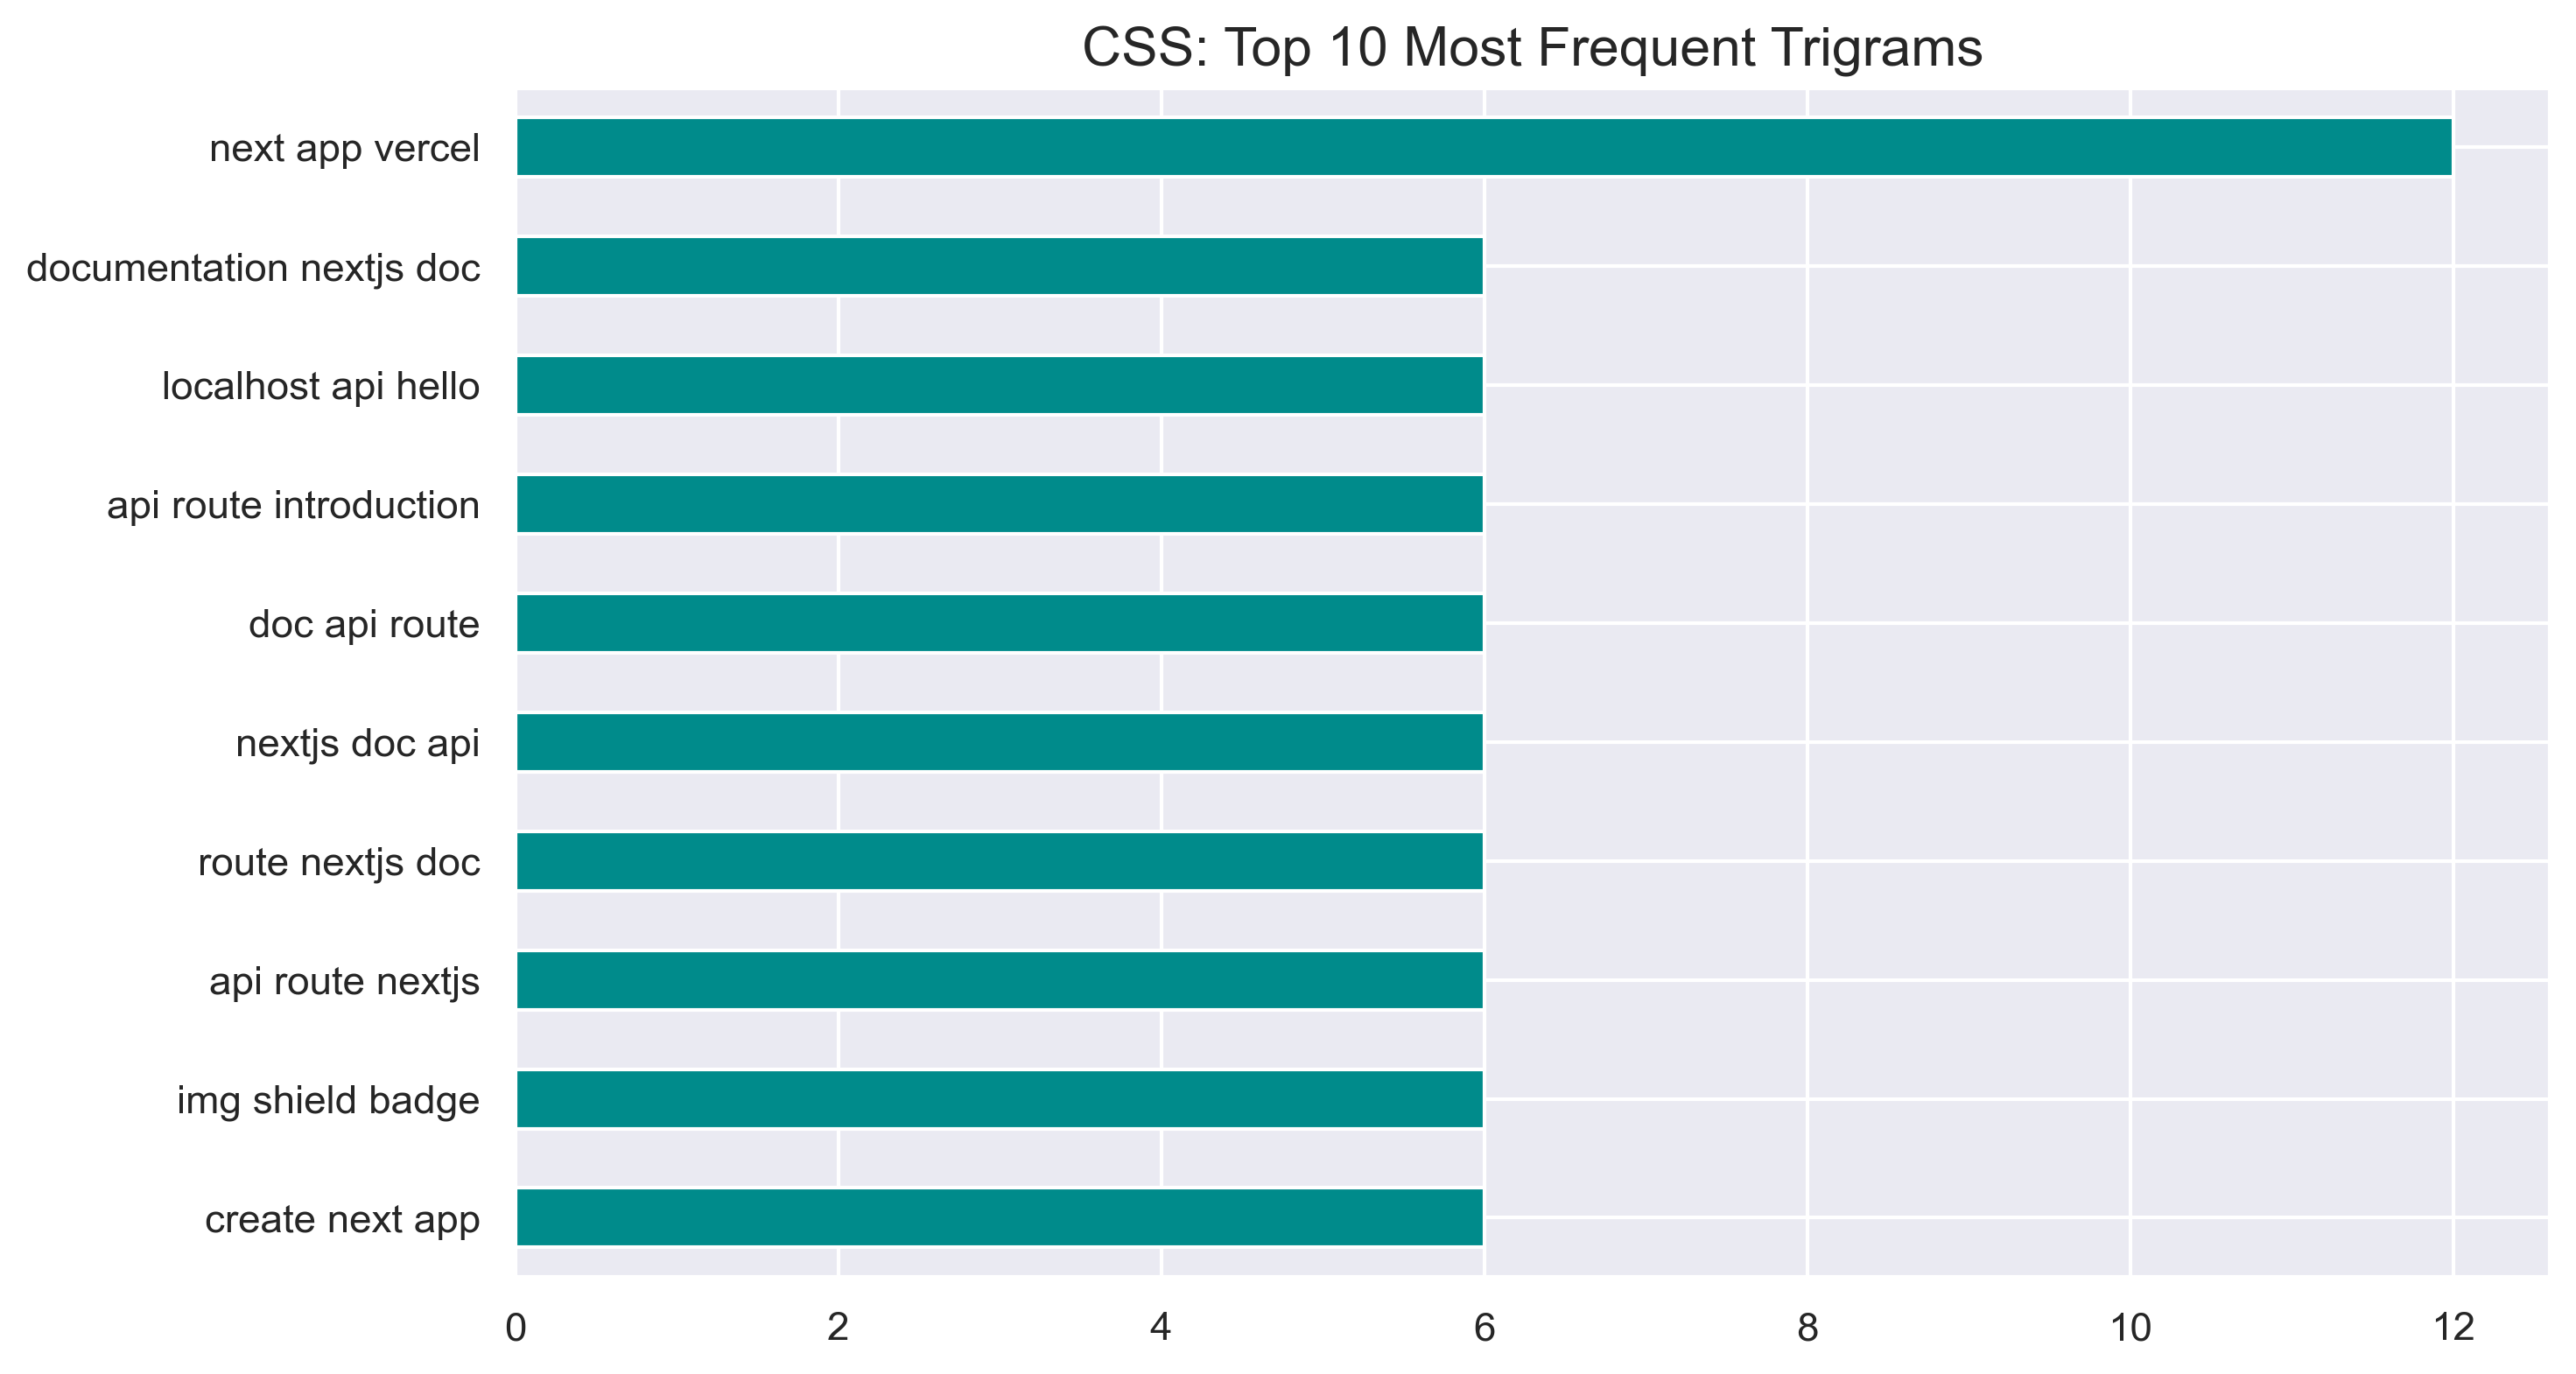

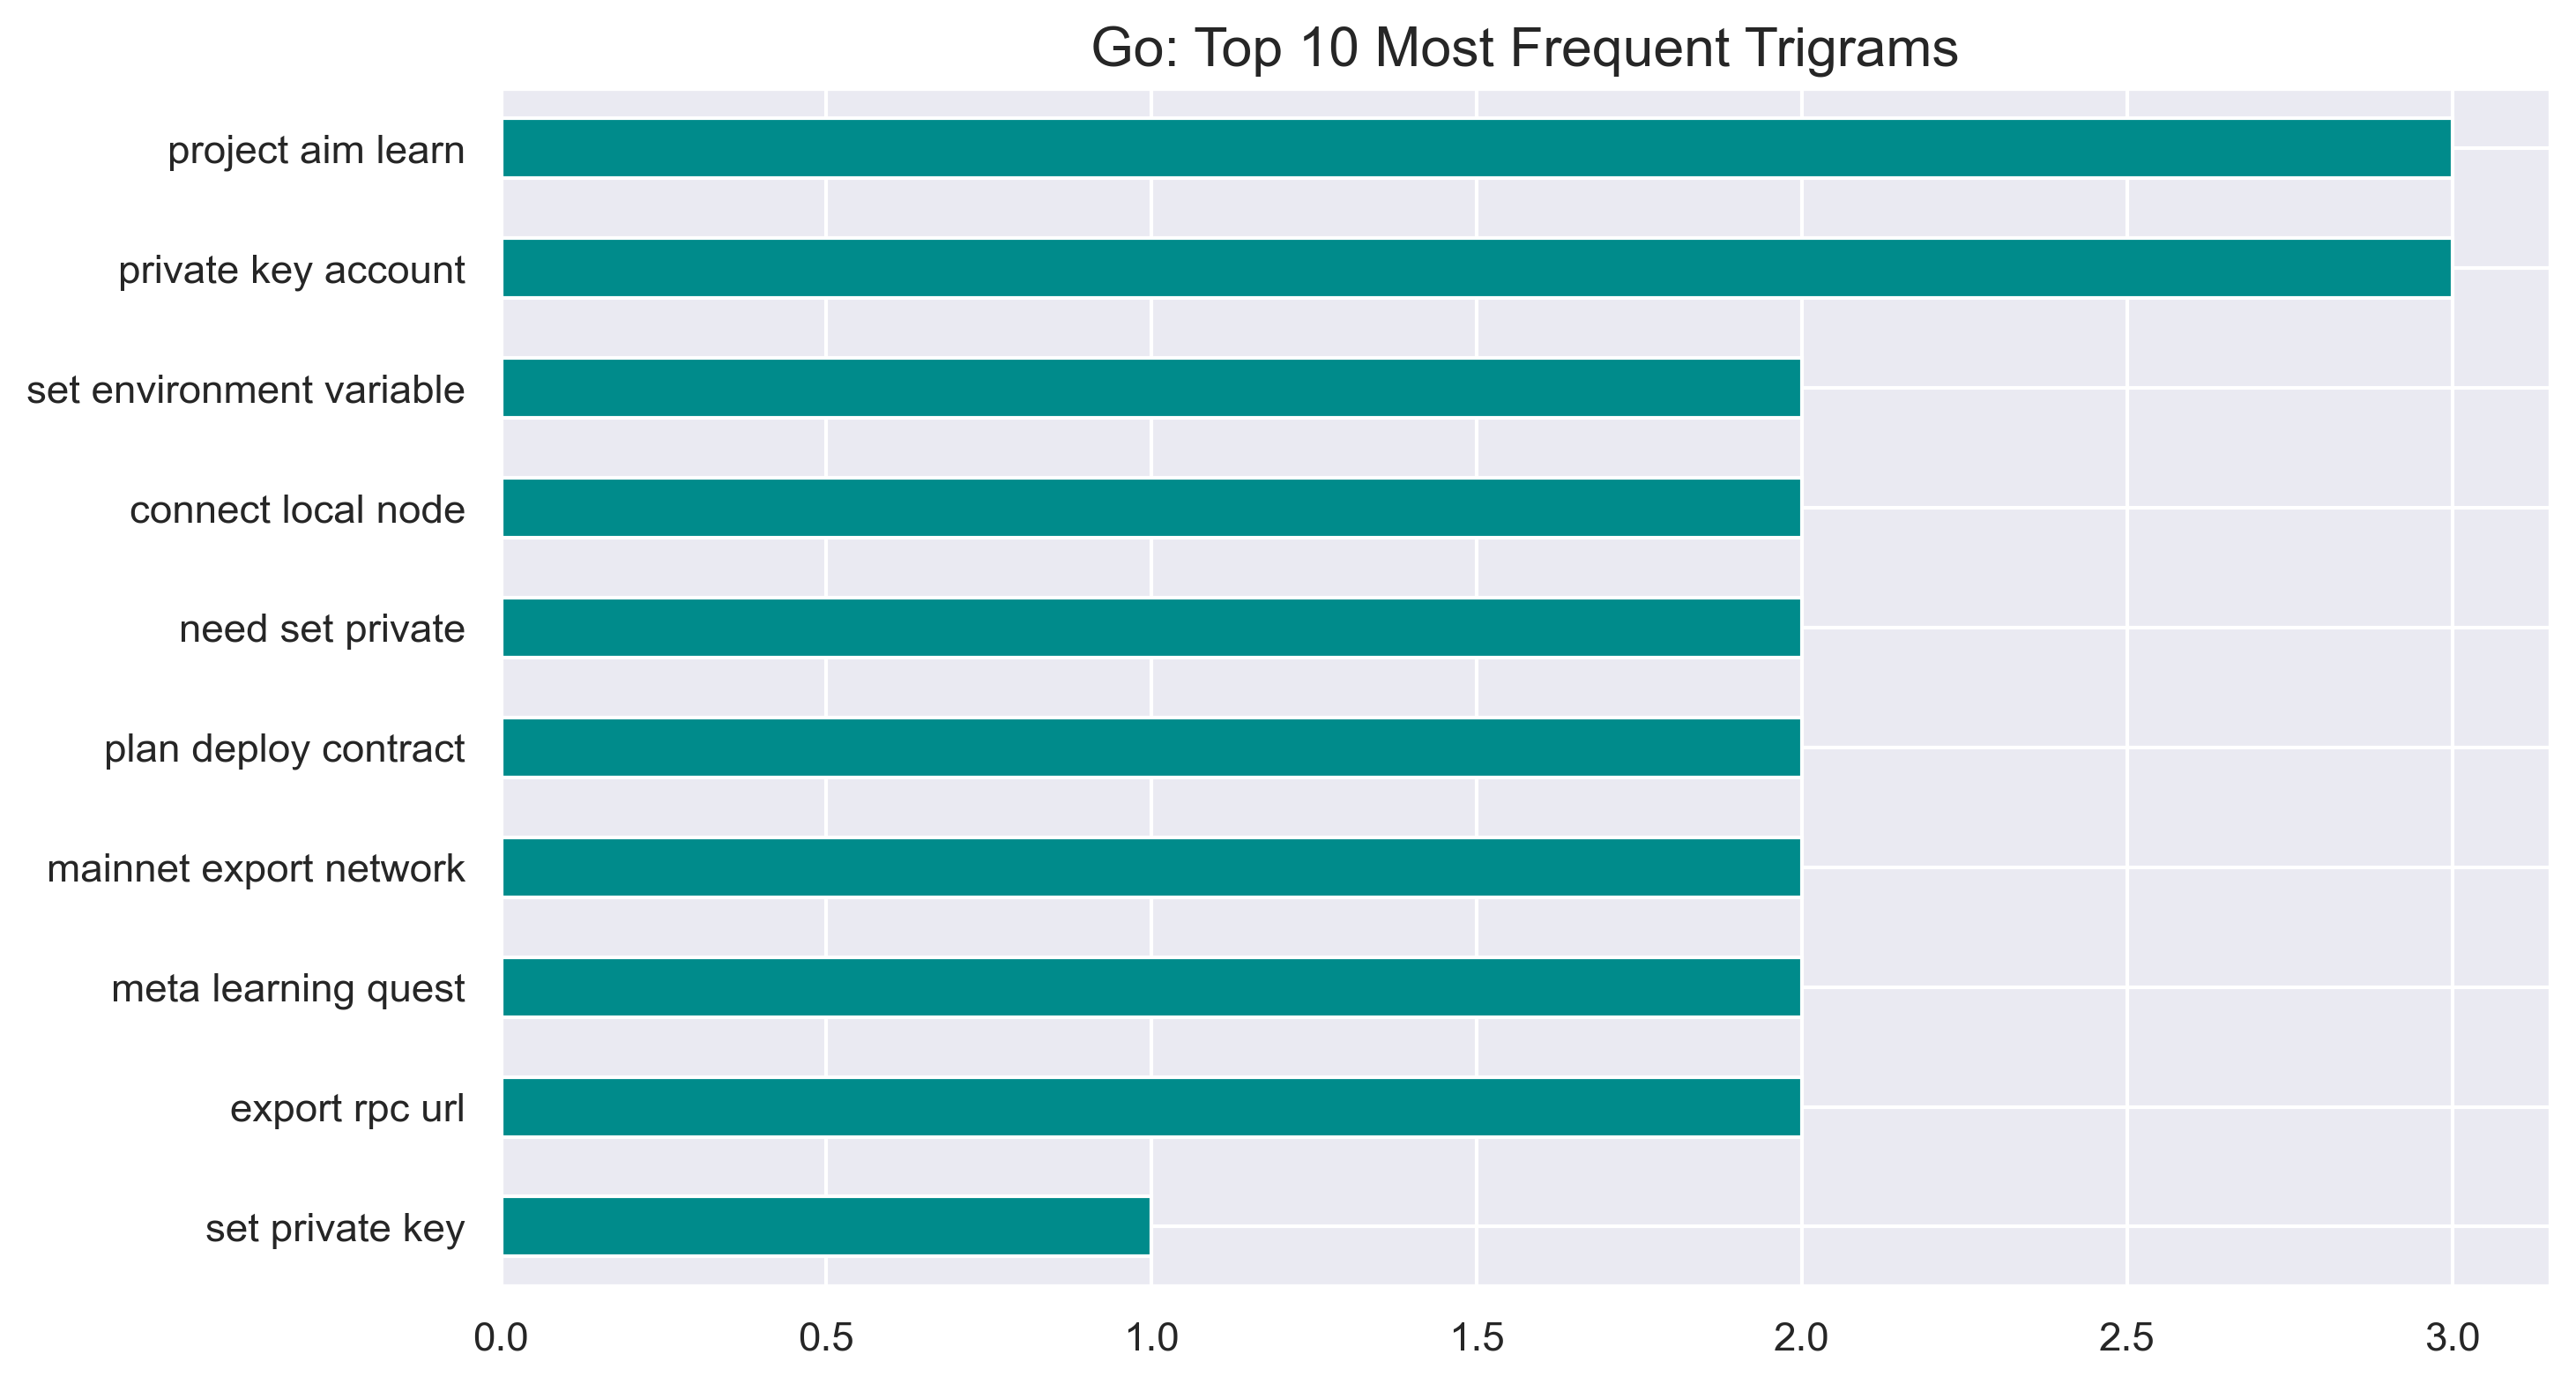

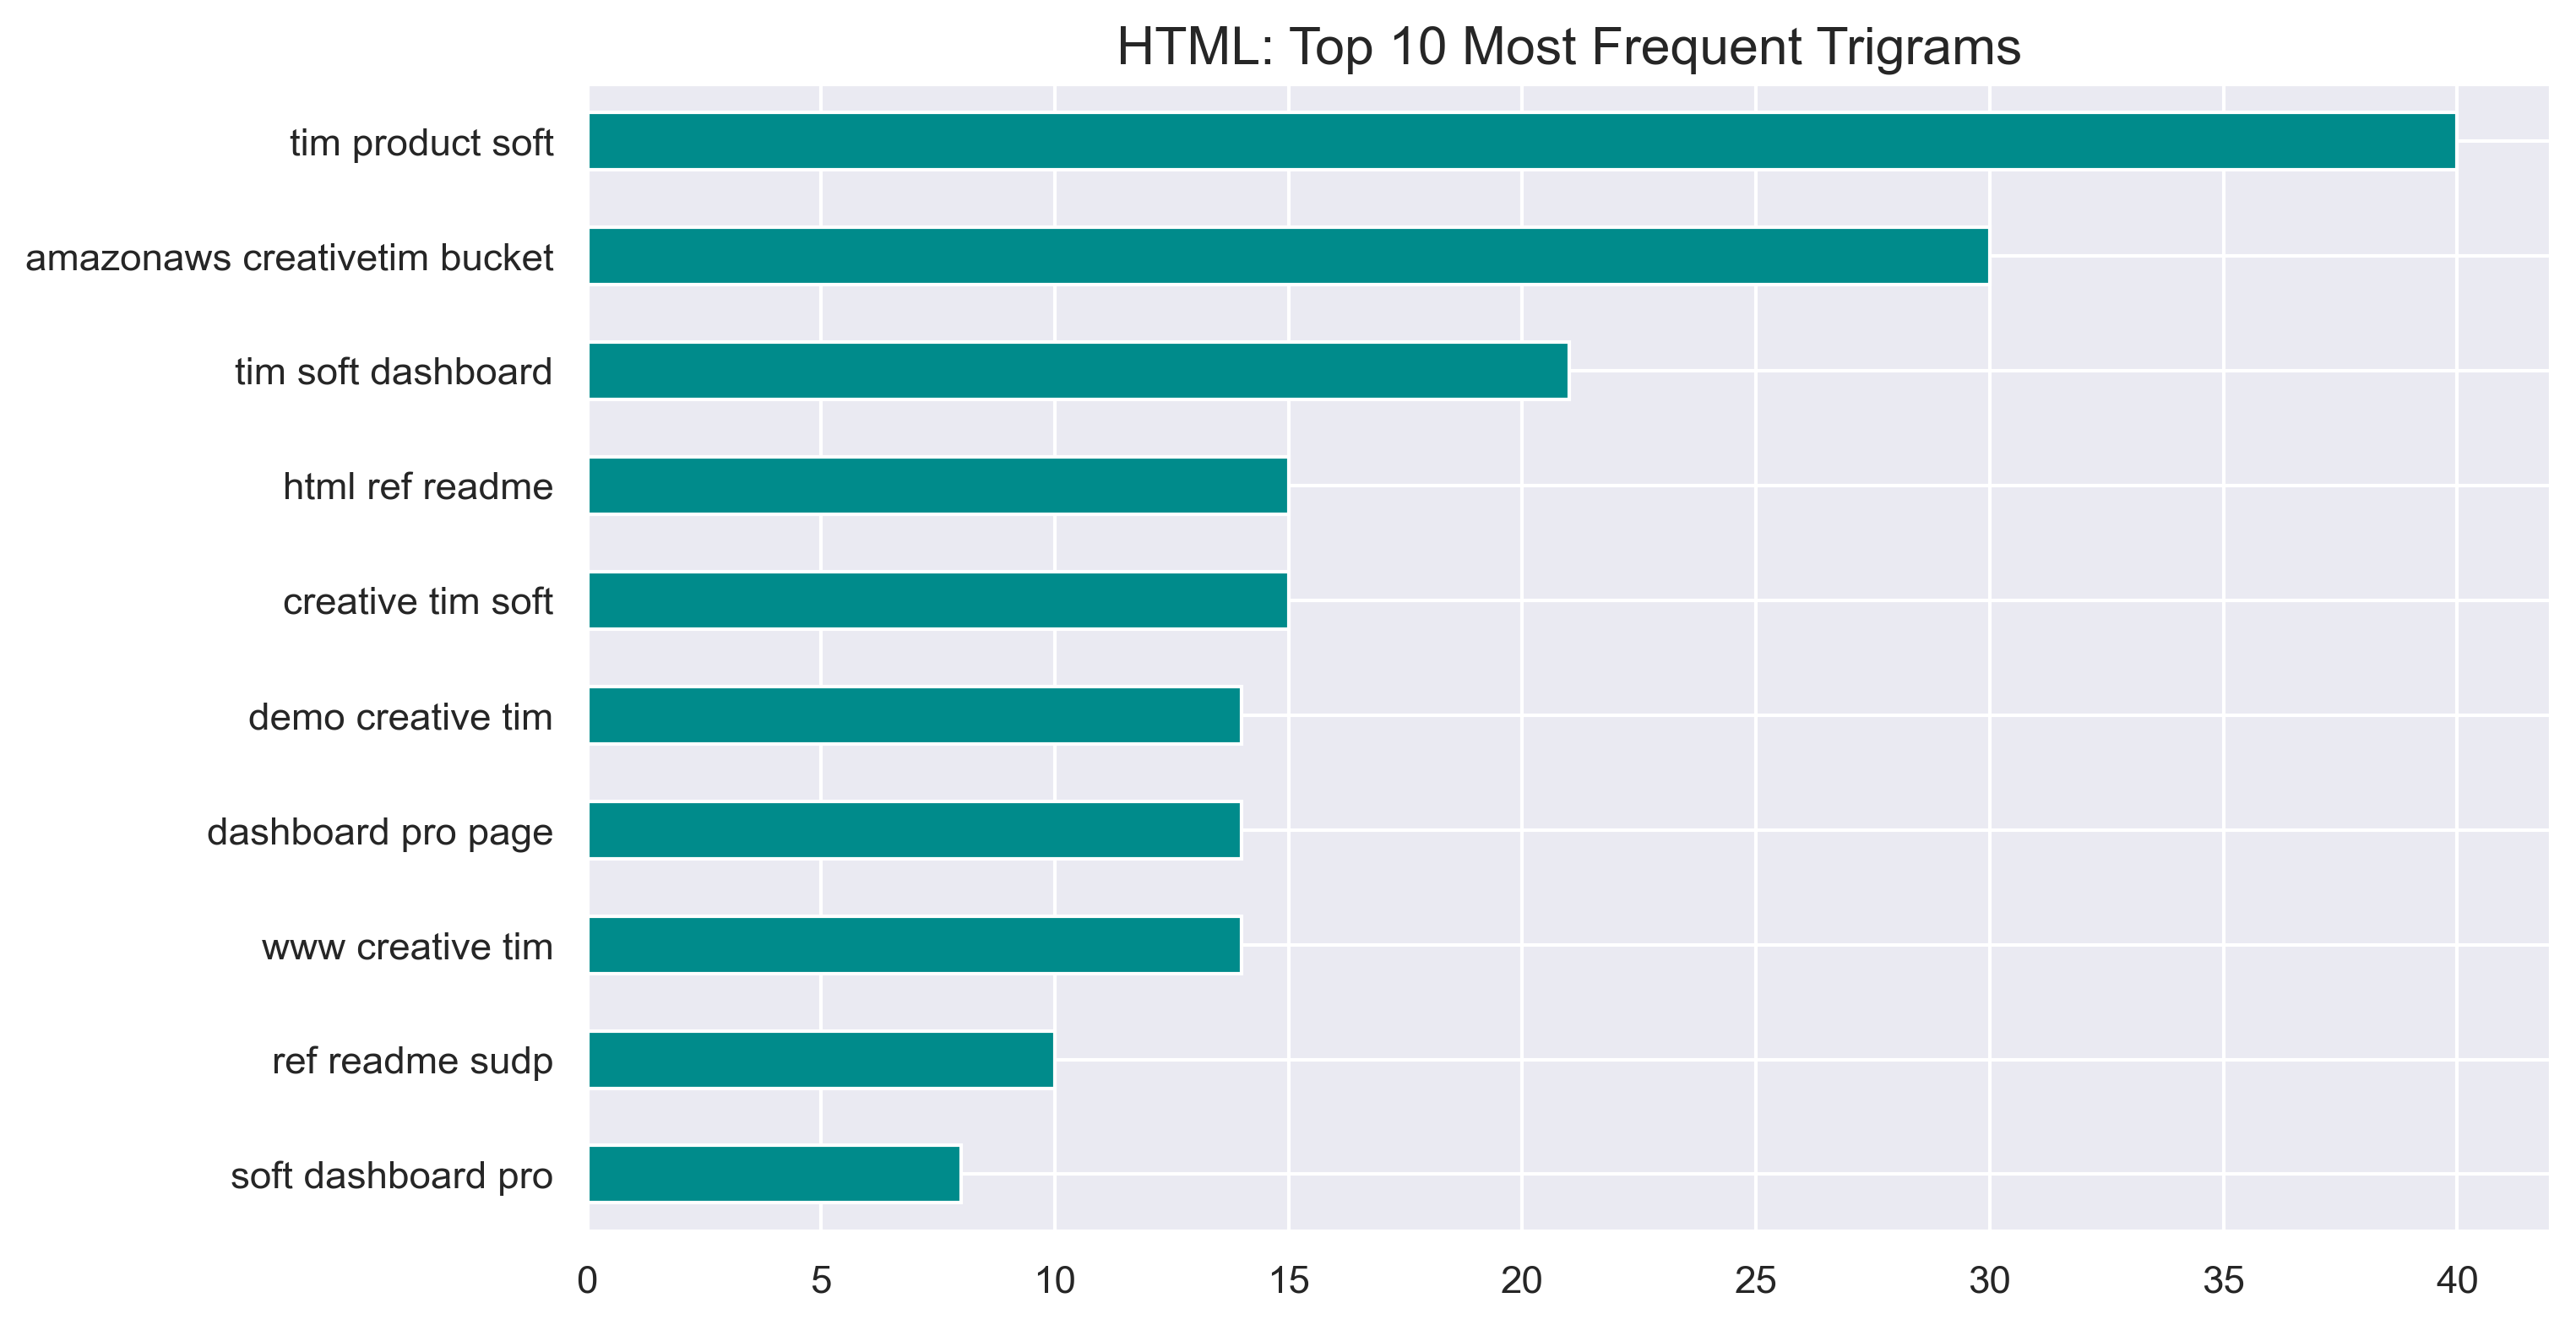

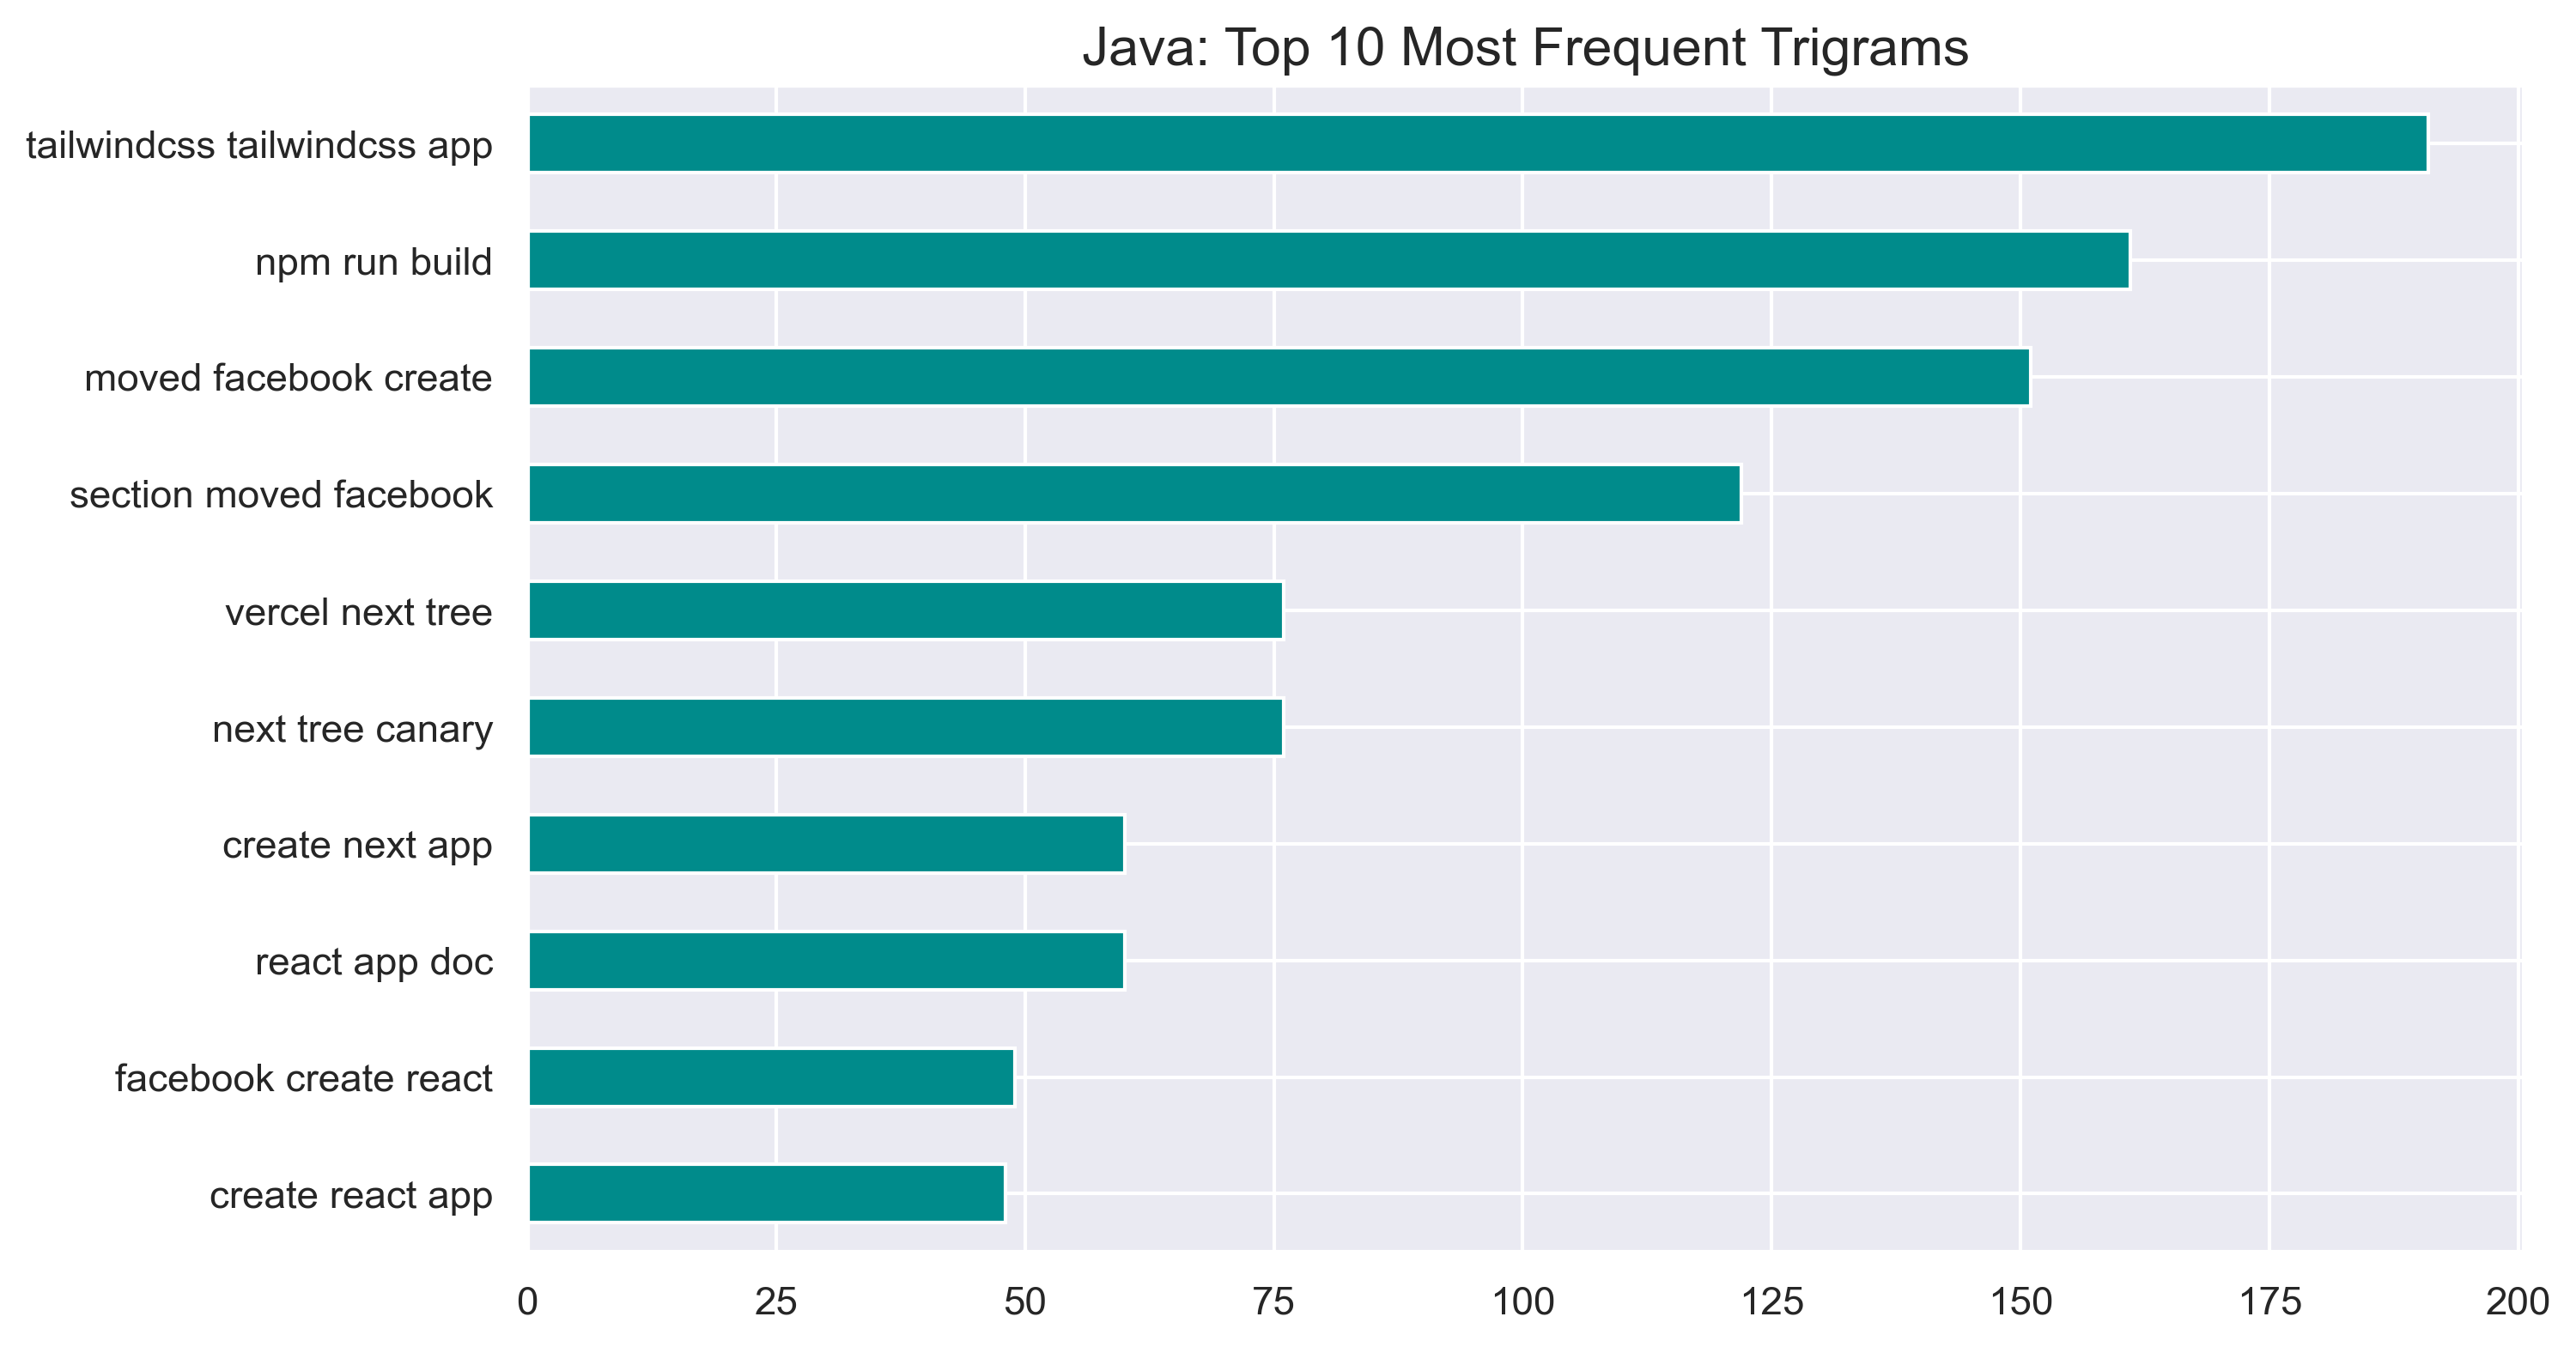

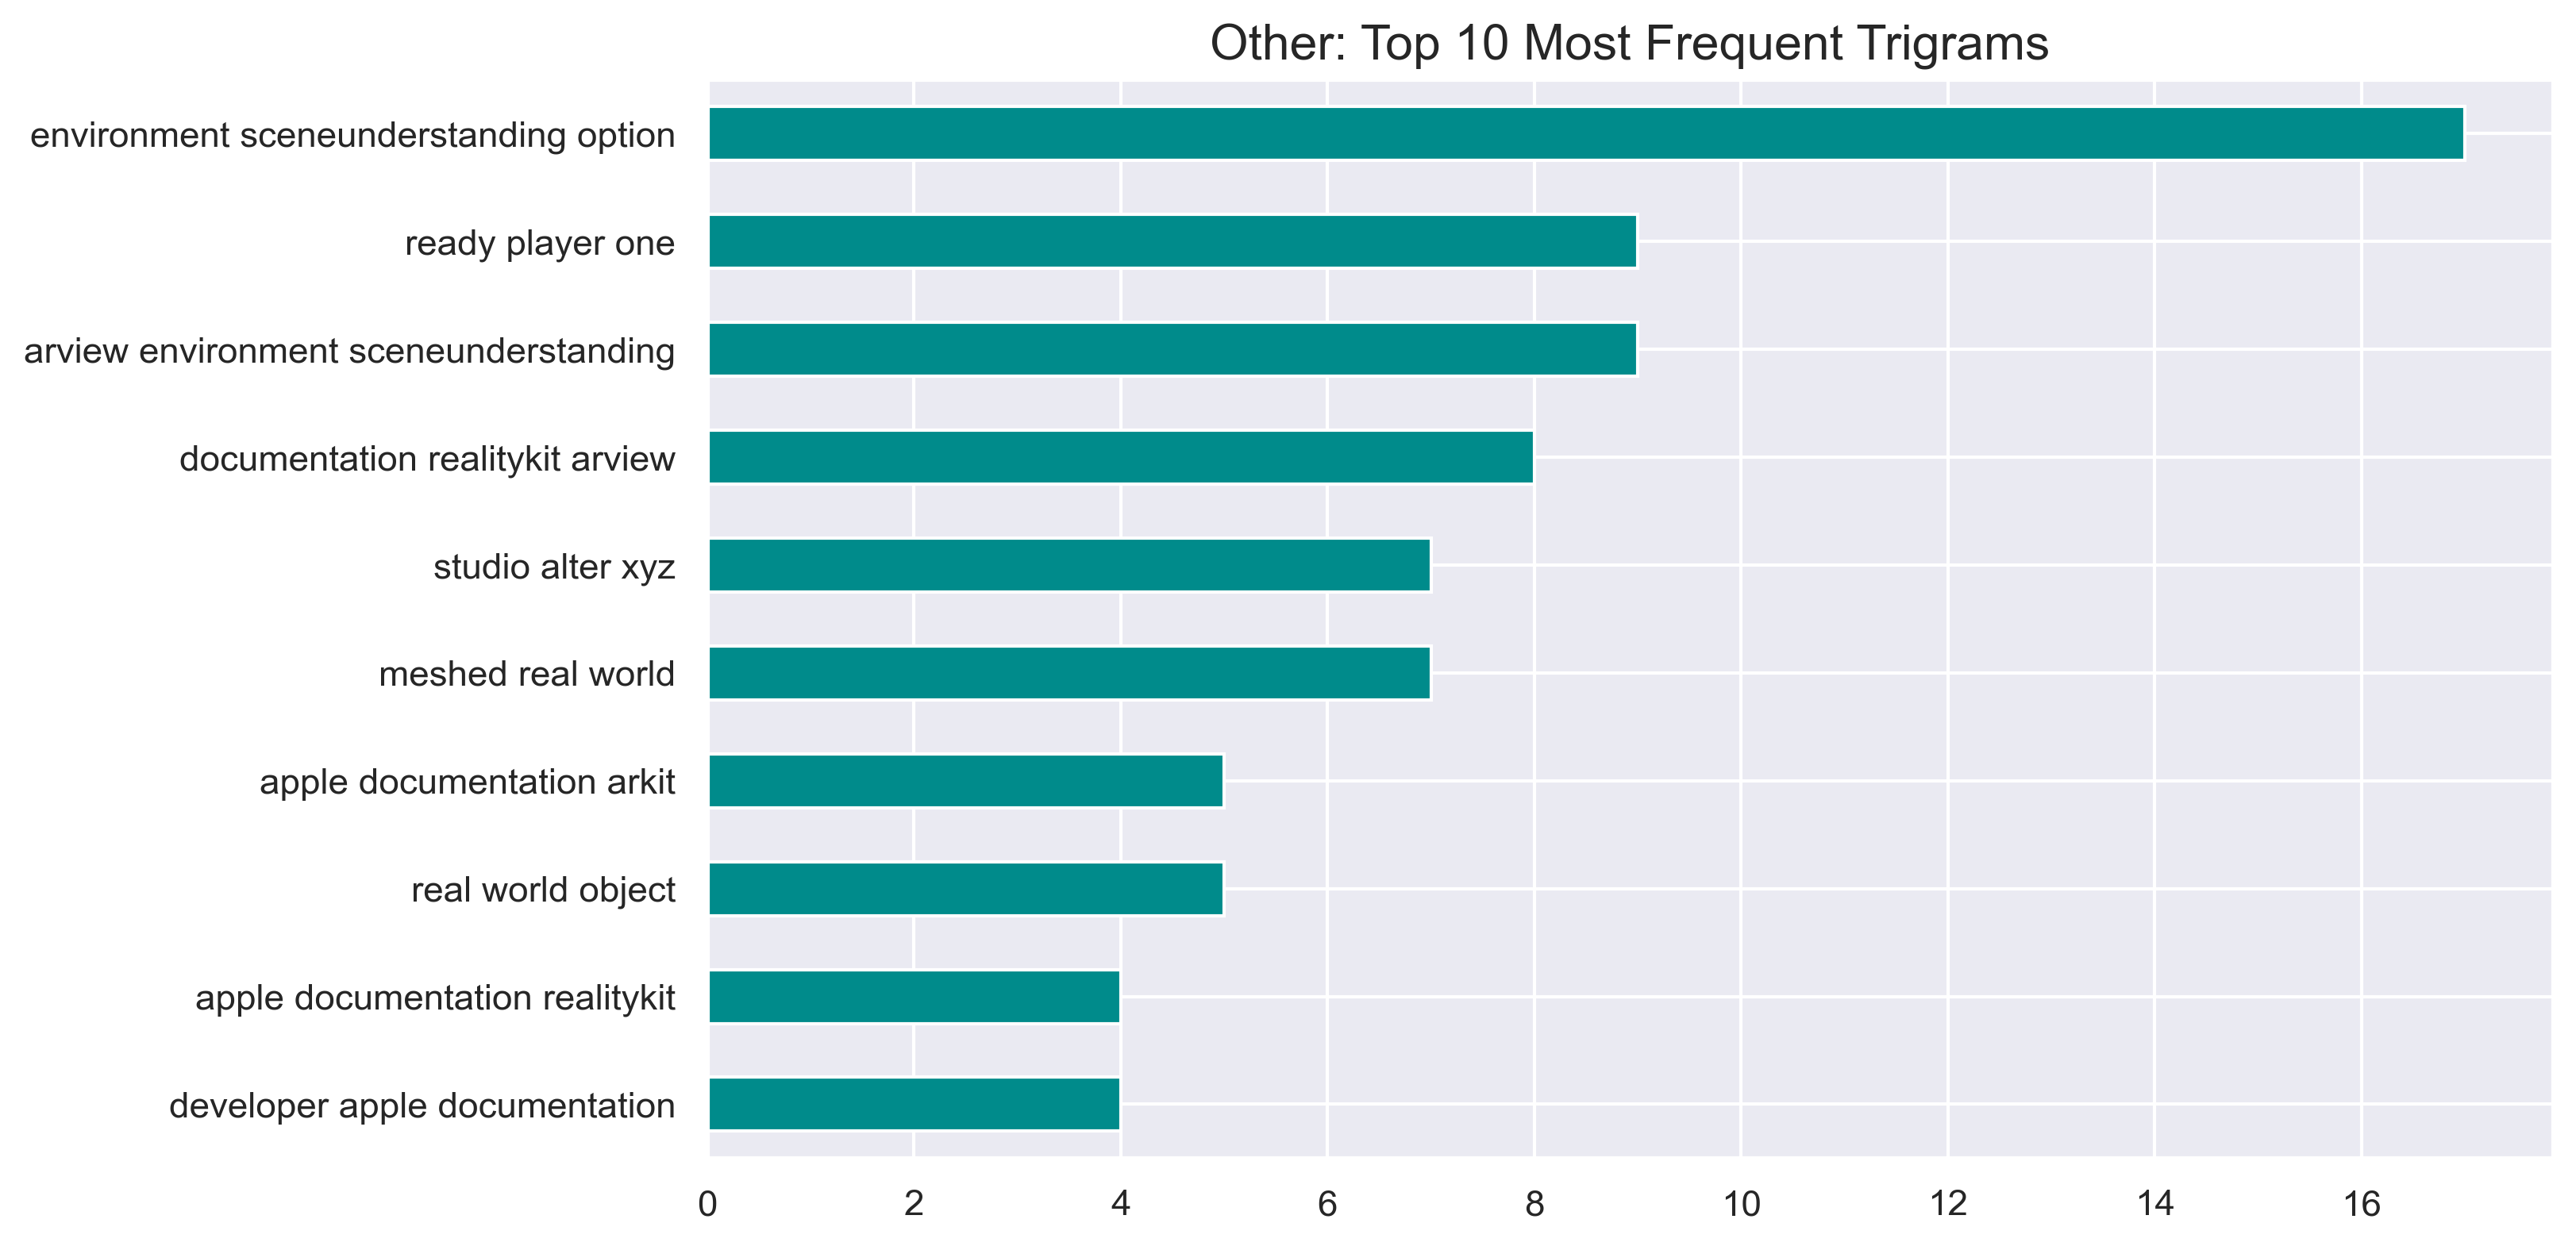

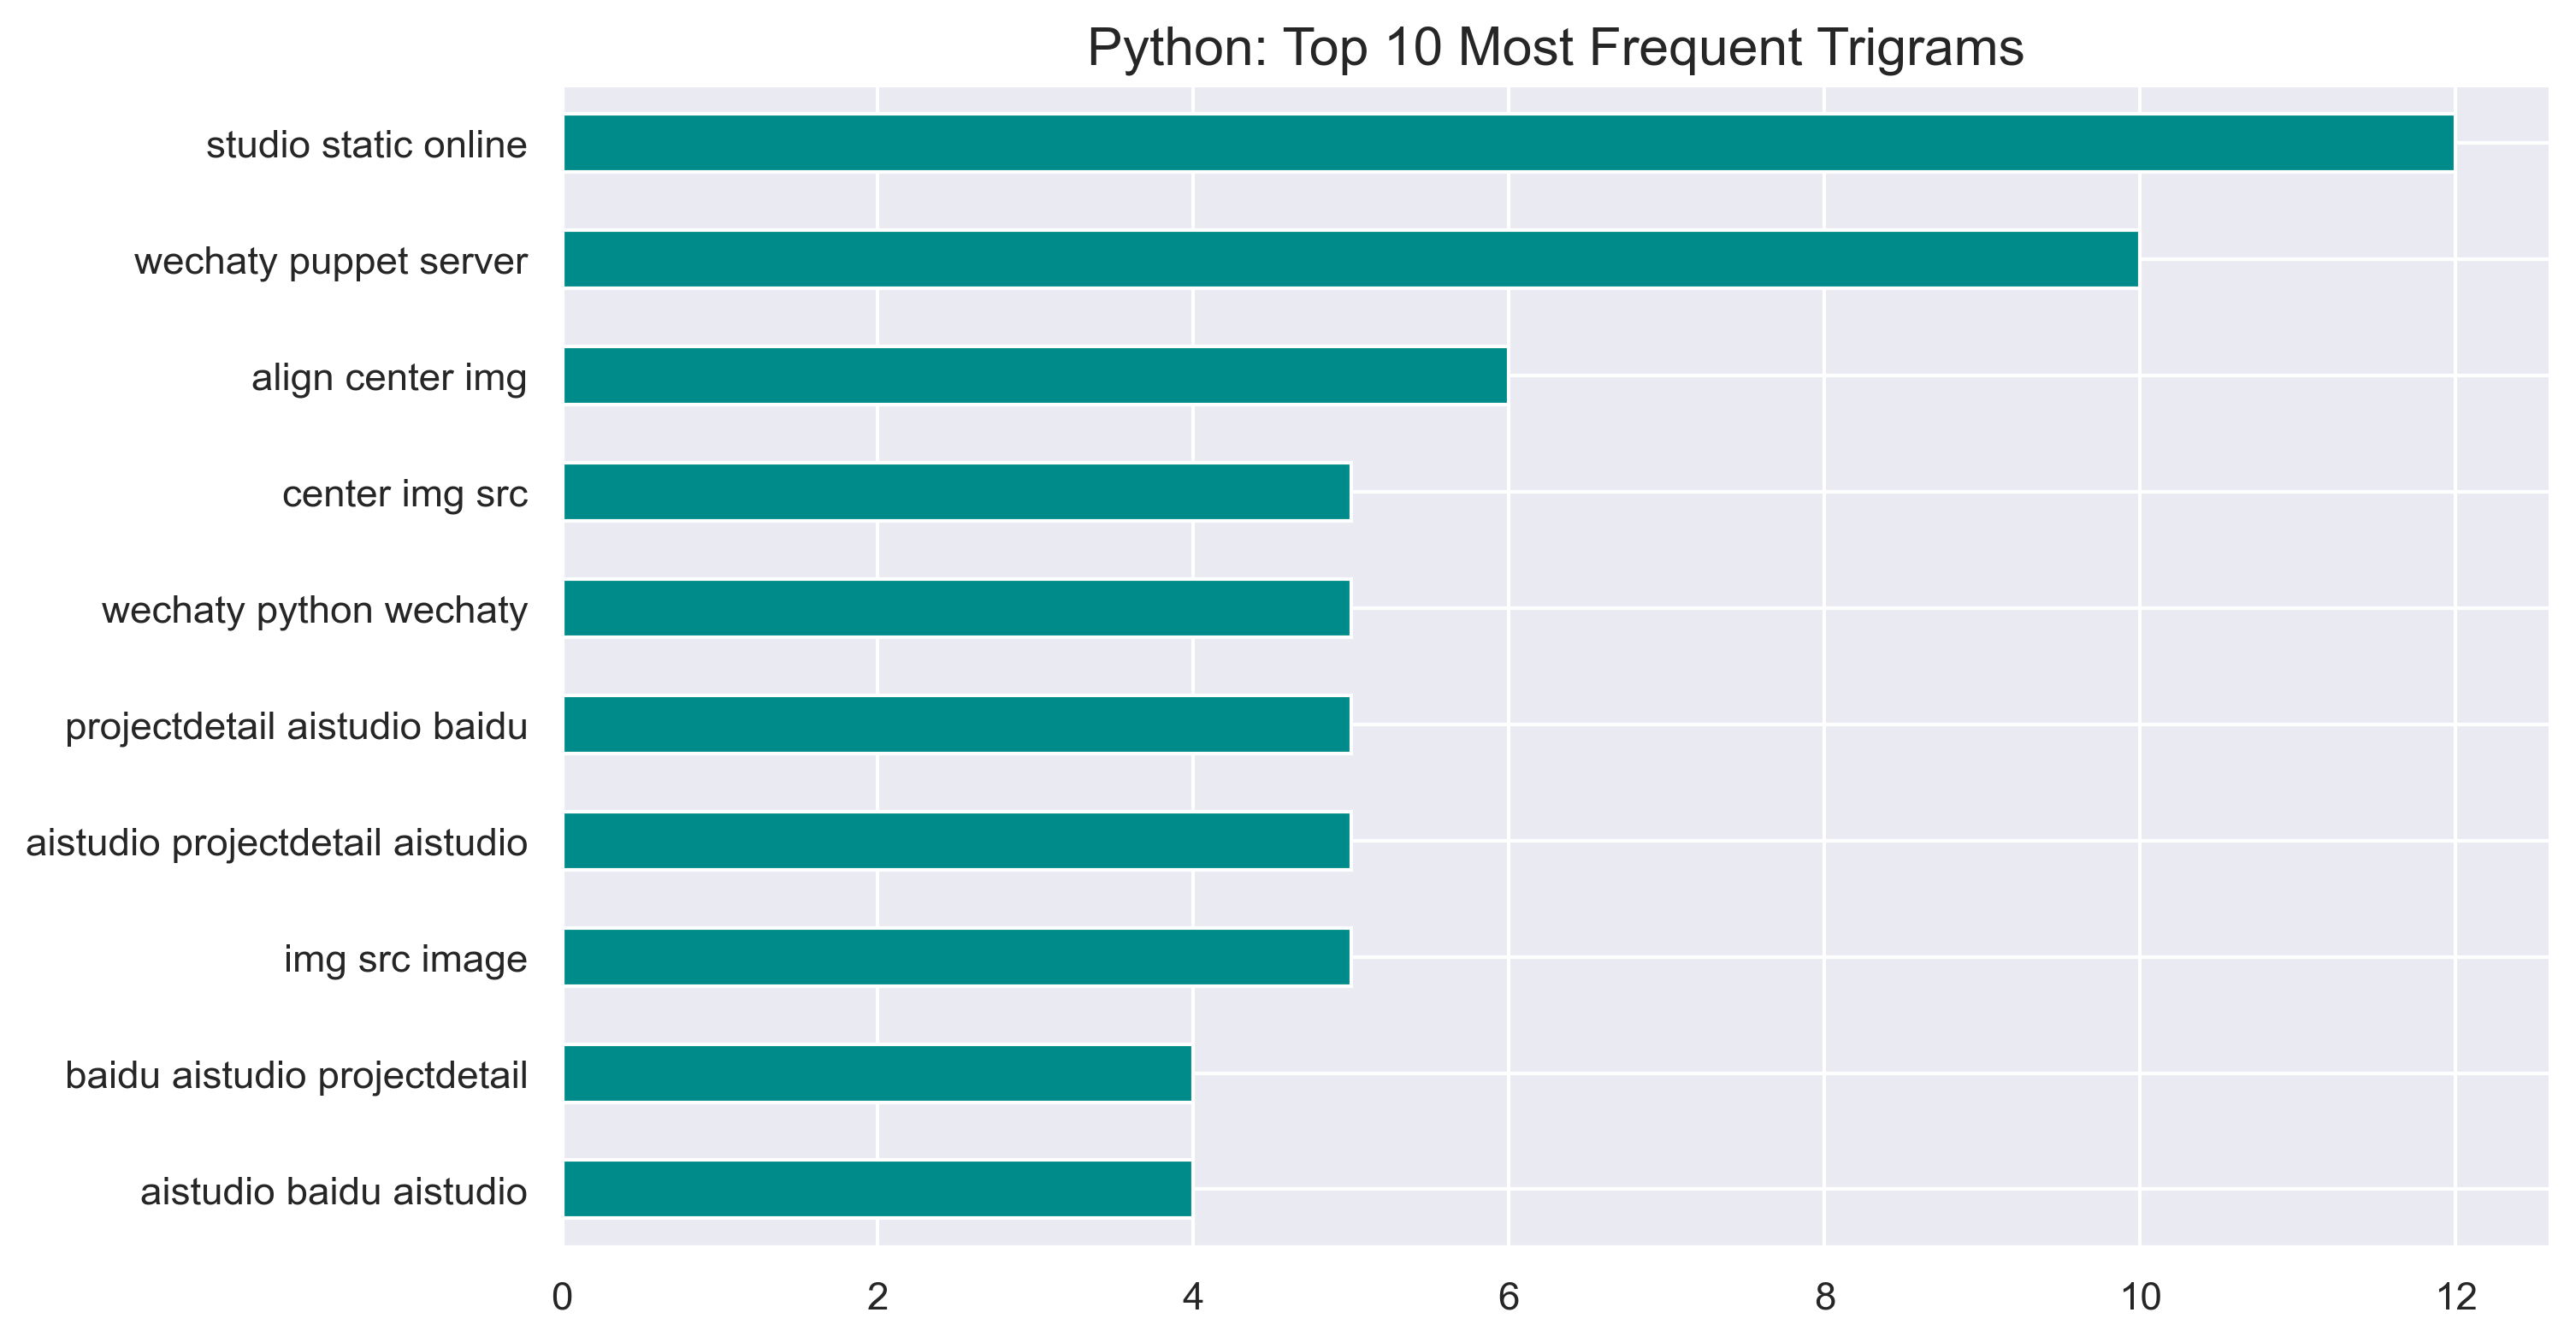

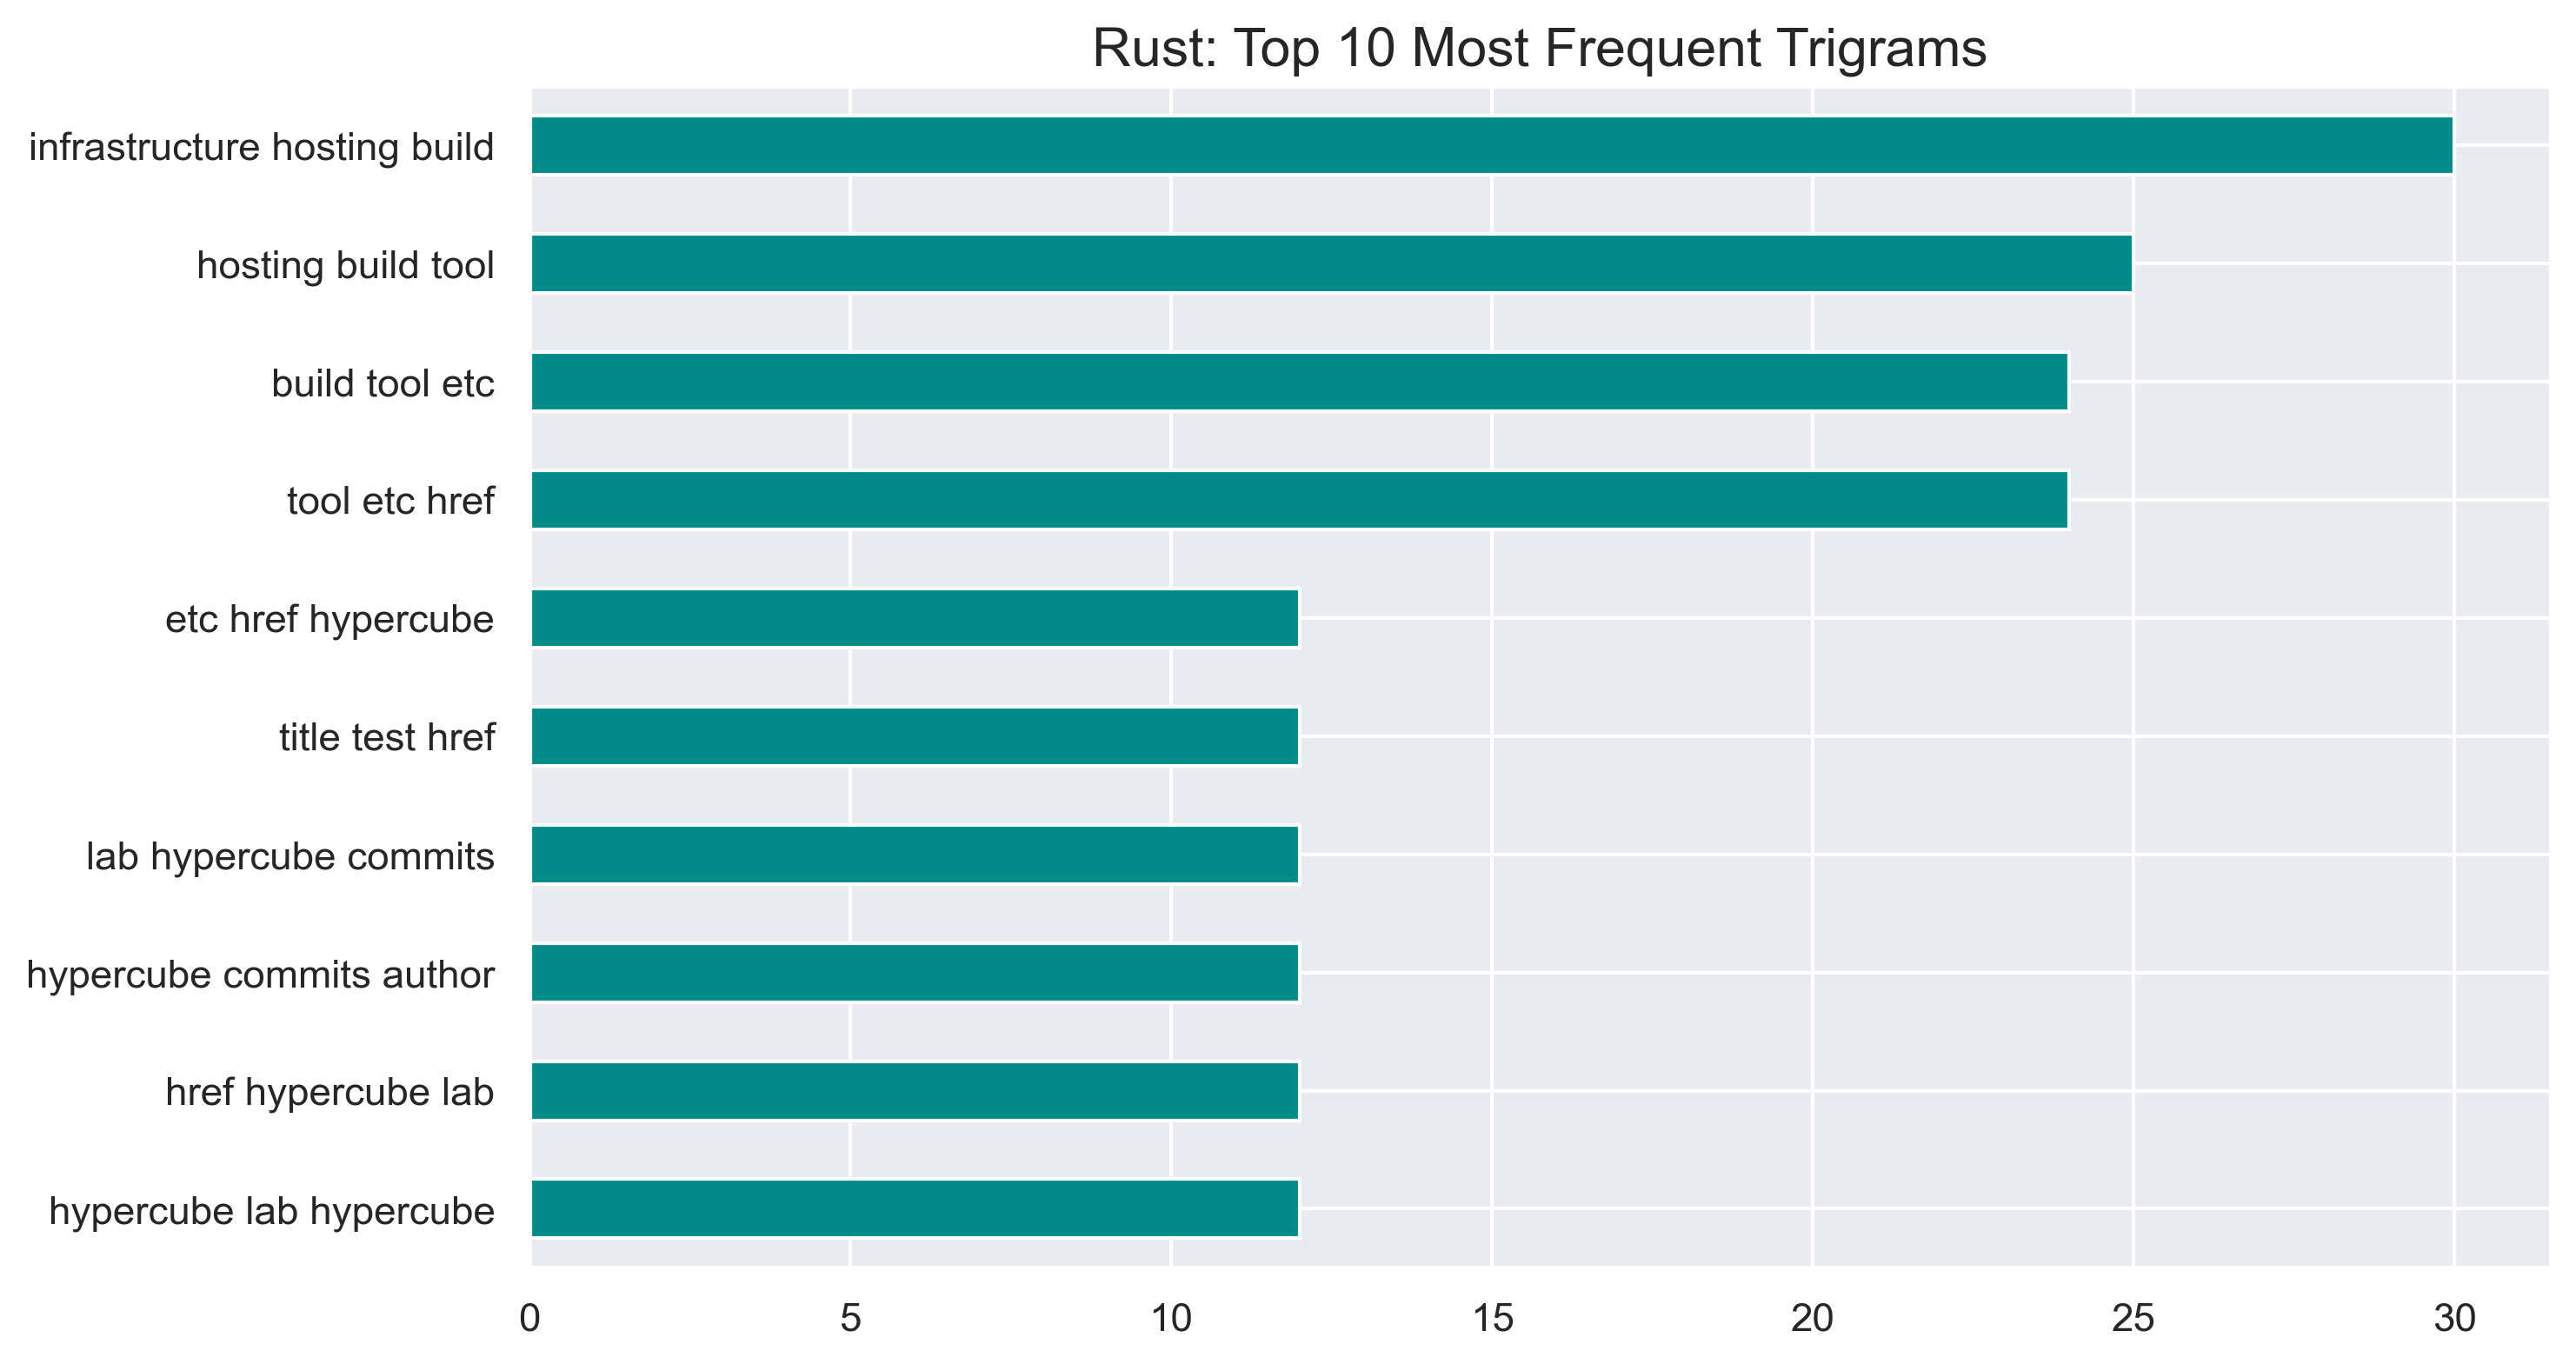

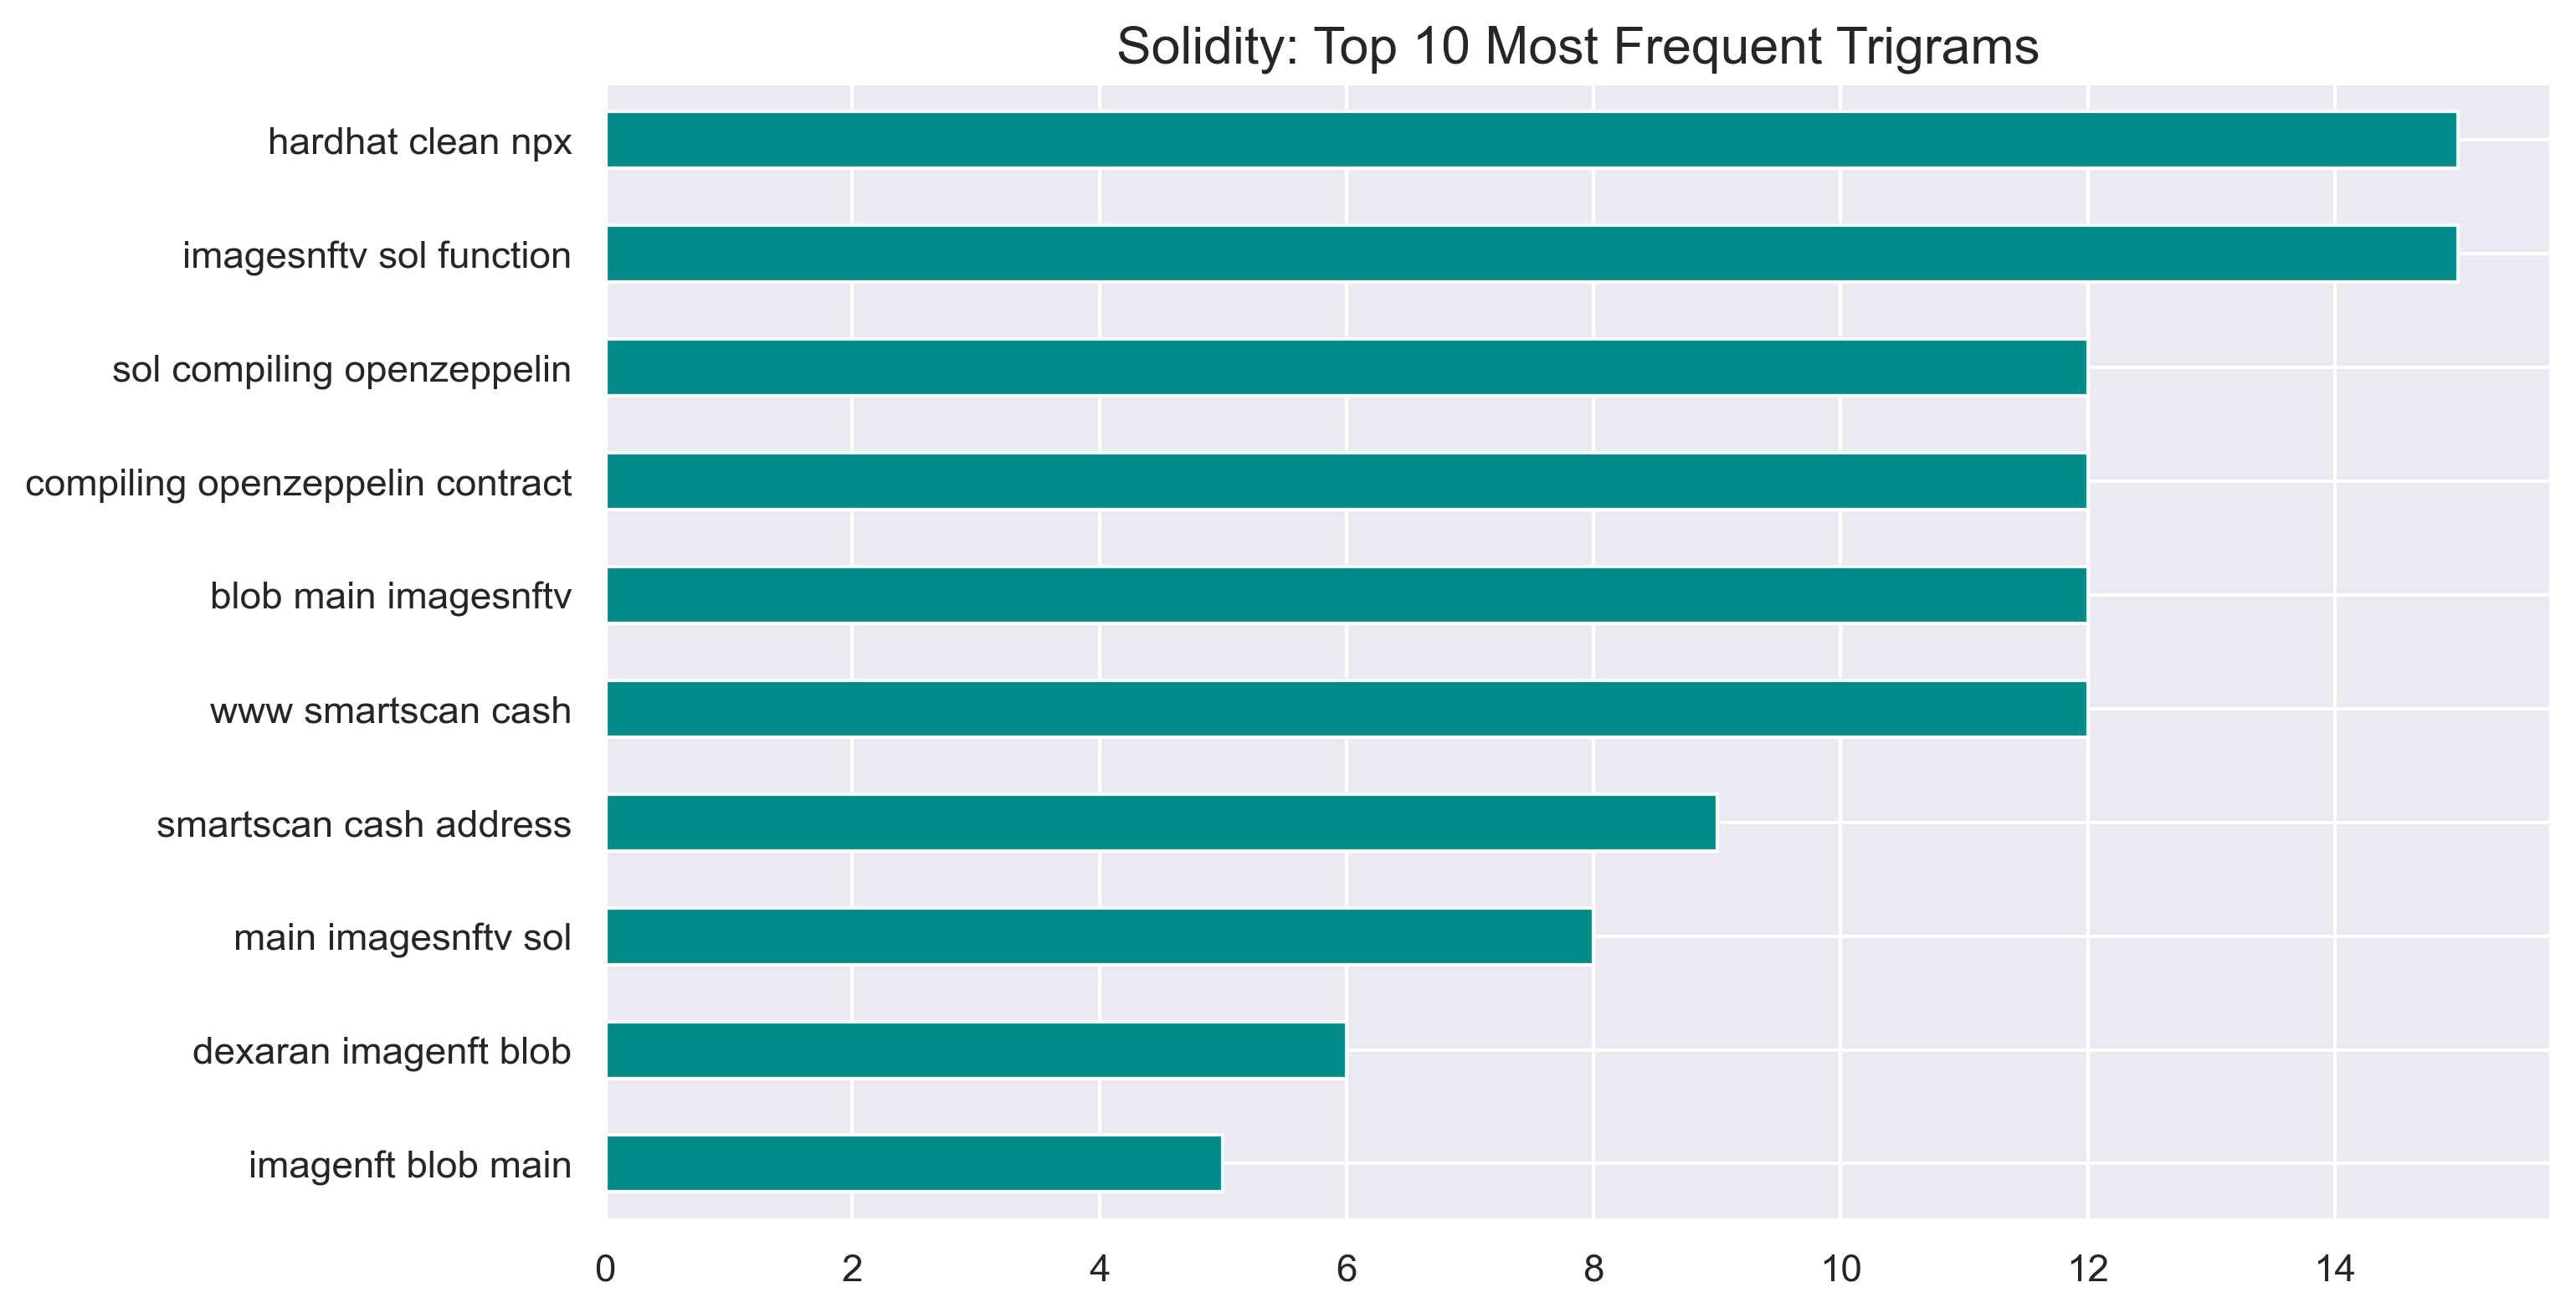

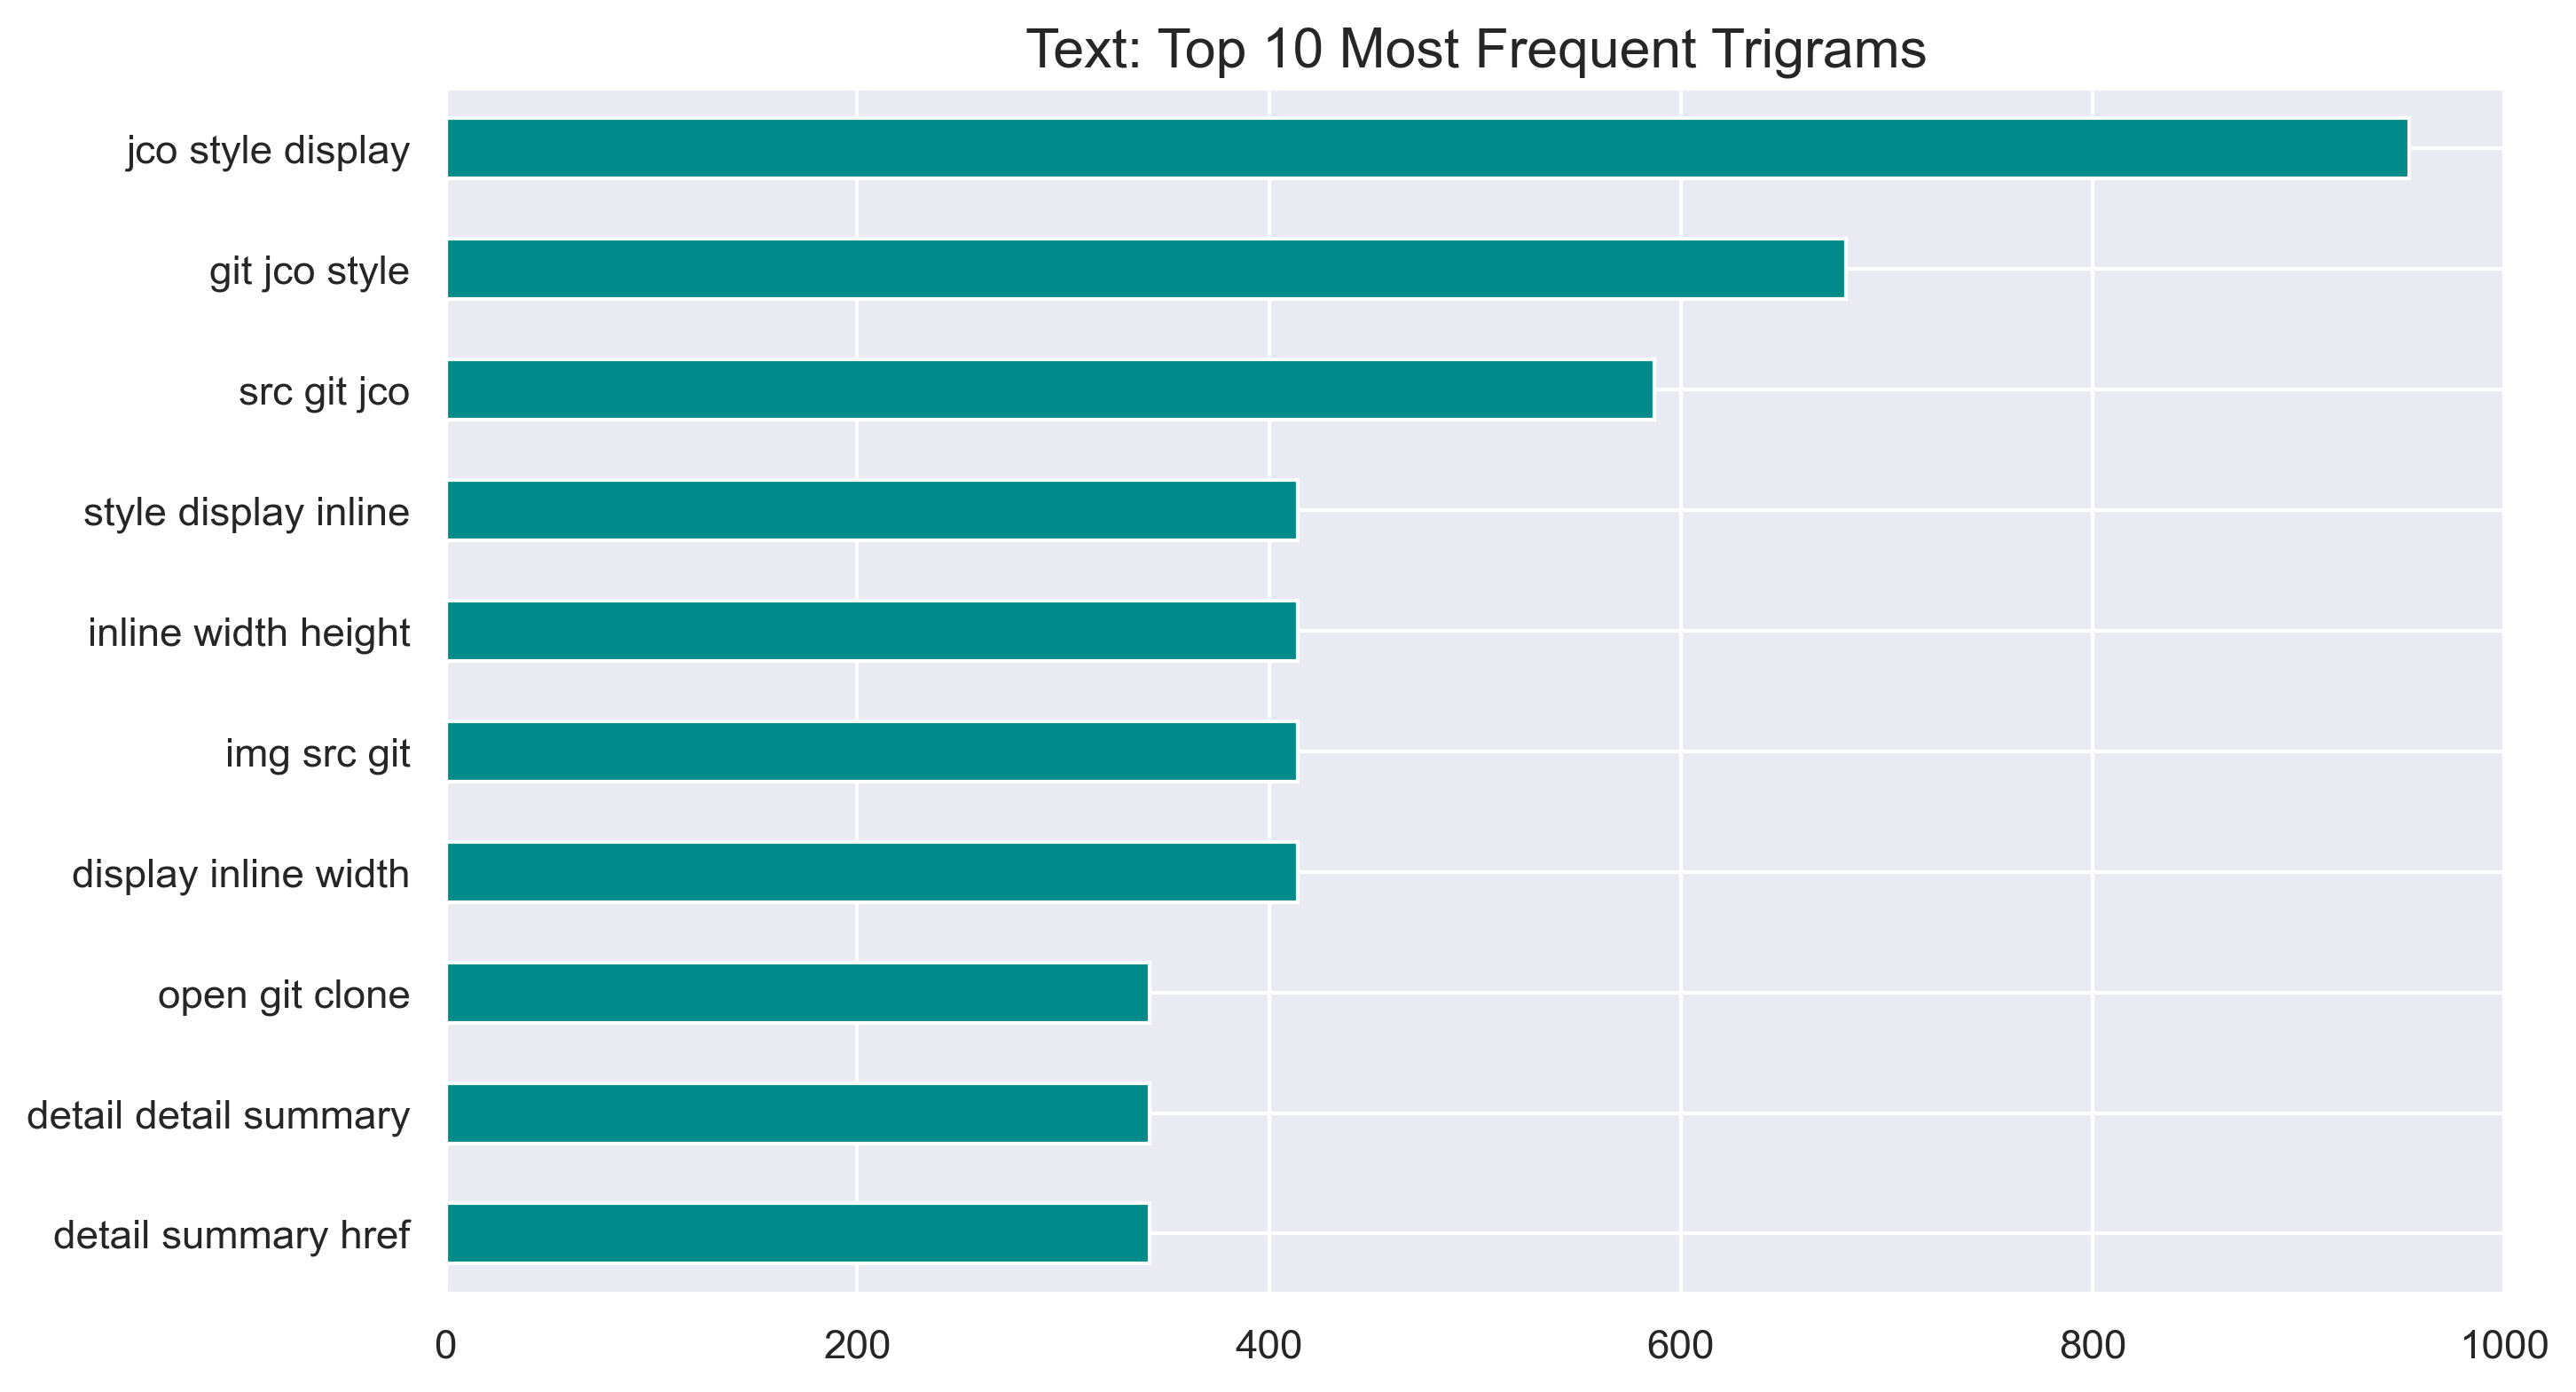

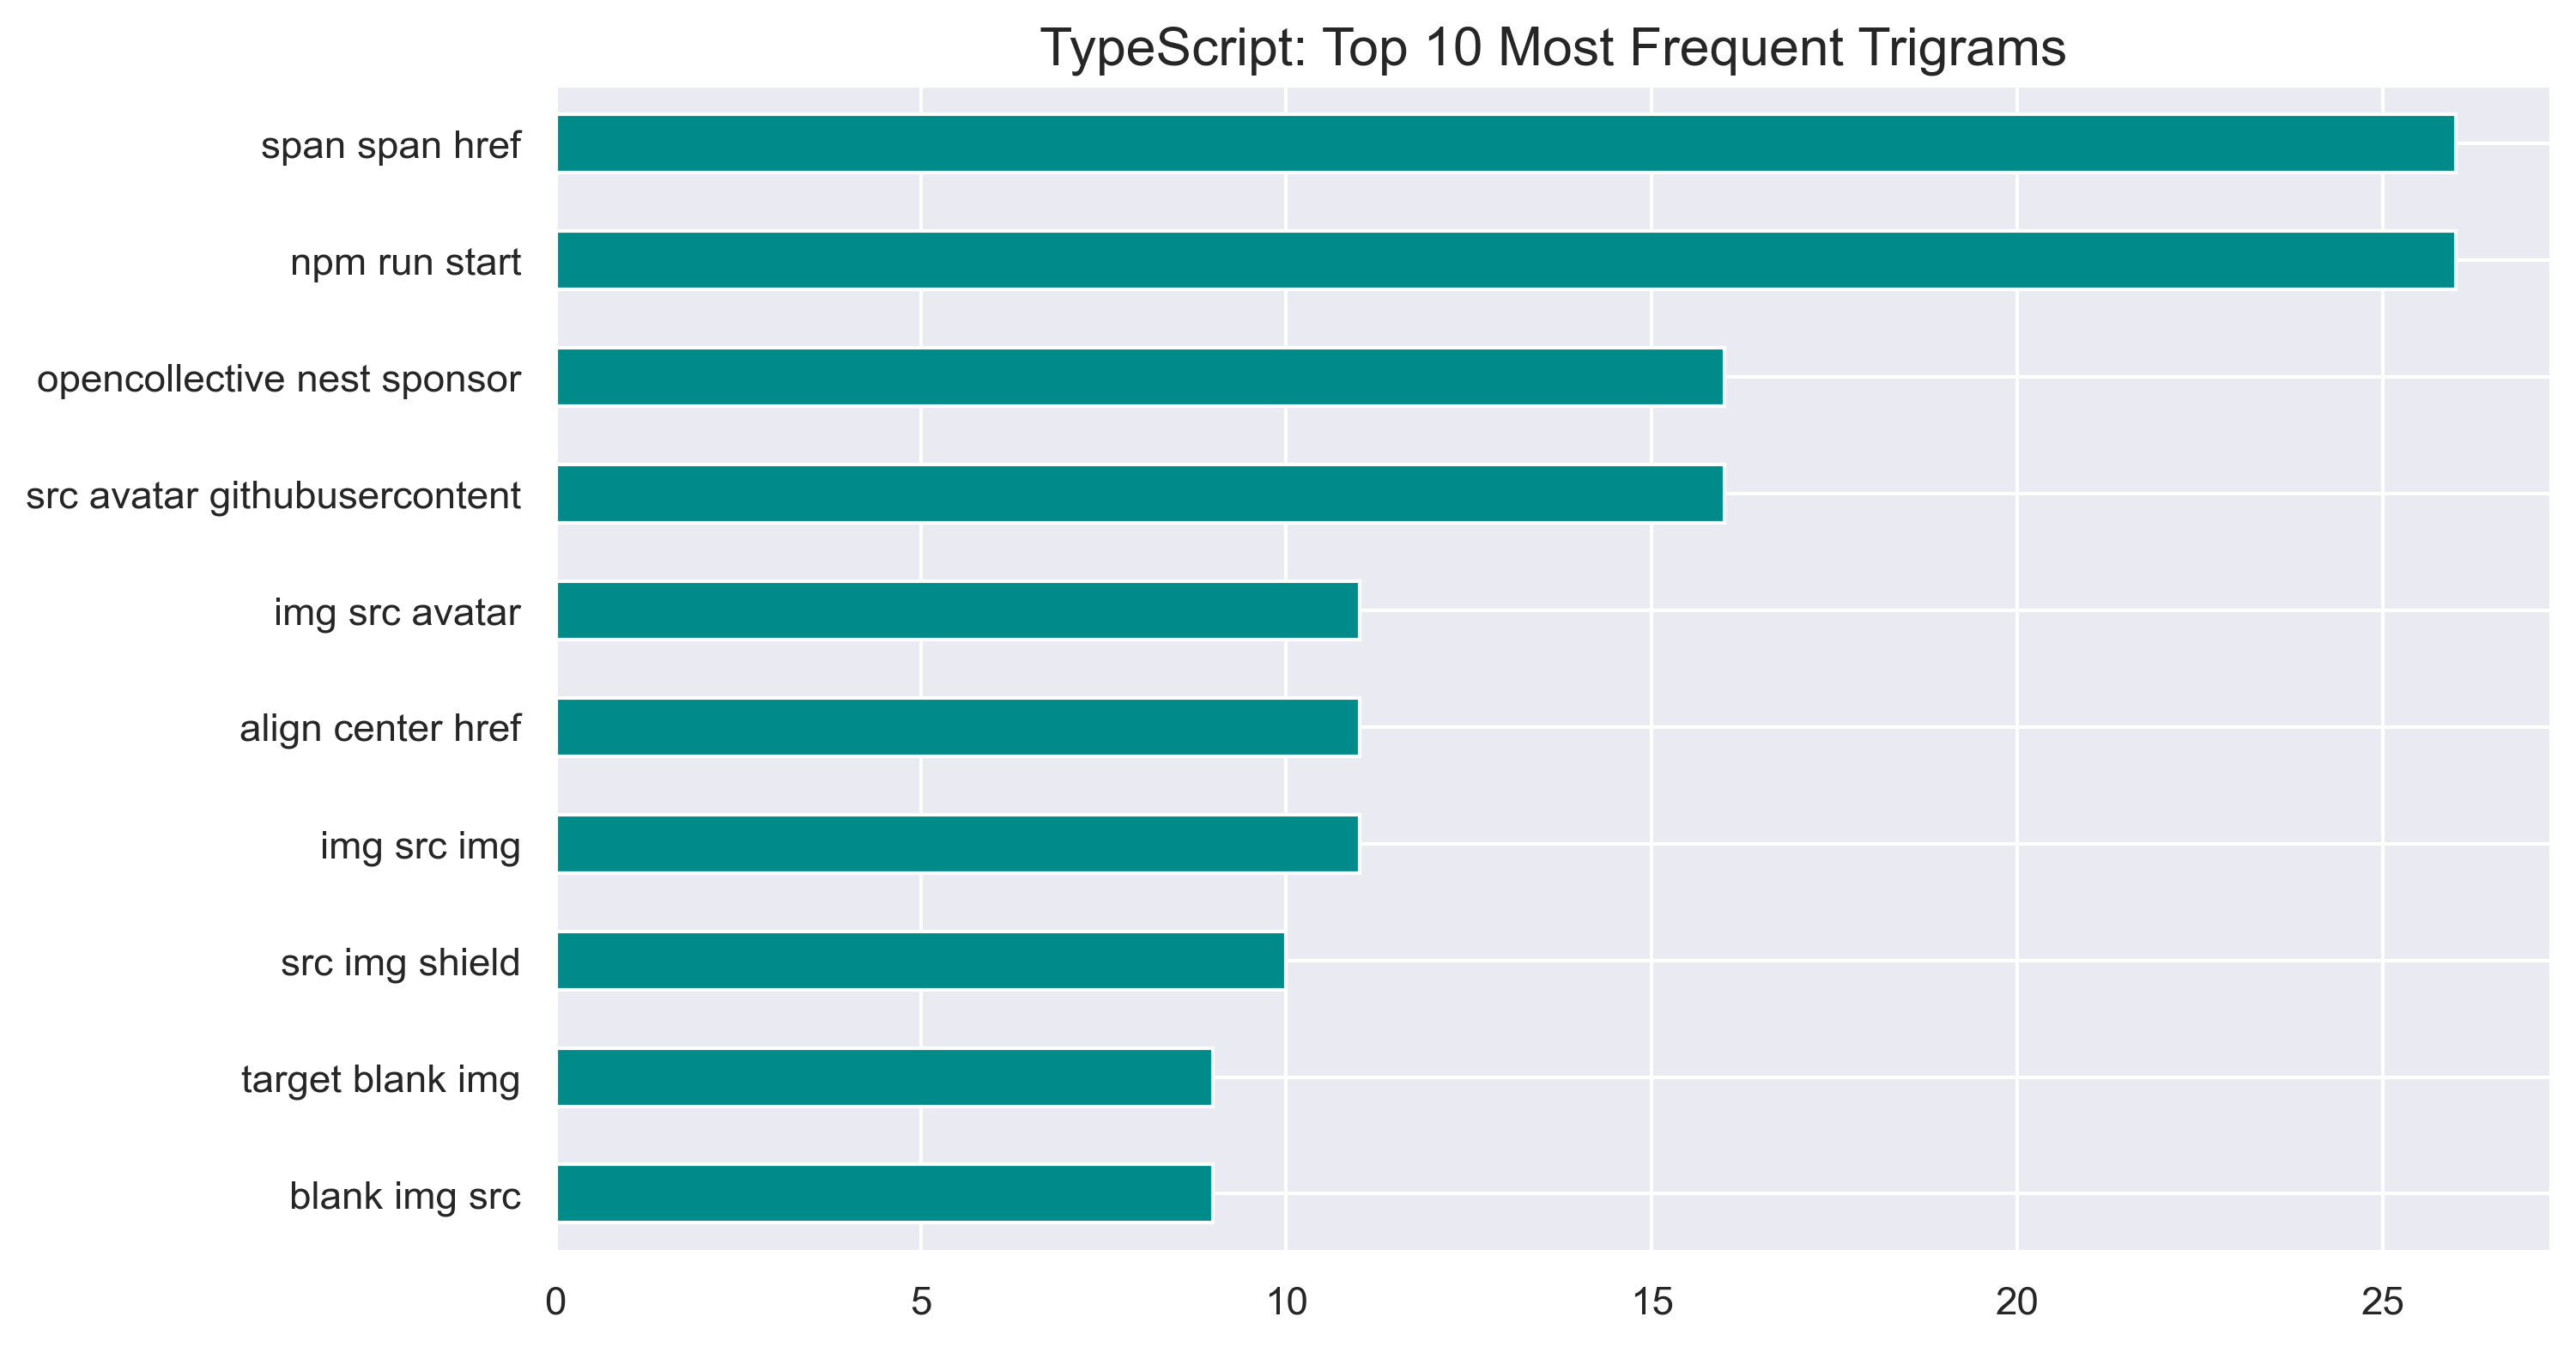

In [42]:
# what about trigrams?
# visualizing trigrams by programming language

frames = [
        all_words, 
        C_words, 
        css_words, 
        go_words, 
        html_words, 
        java_words, 
        other_words, 
        python_words, 
        rust_words, 
        solidity_words,
        text_words,
        typescript_words]

counter = 0

for frame in frames:
    # creating the top 10 trigrams for ea. program language
    trigrams = (pd.Series(nltk.ngrams(frame, 3))
                .value_counts()
                .head(10))

    # sorting and plotting the trigrams
    trigrams.sort_values().plot.barh(figsize=(10, 6), color = "darkcyan")

    plt.title(f'{languages[counter]}: Top 10 Most Frequent Trigrams', fontsize = 15)
    plt.ylabel(None)
    plt.xlabel(None)

    # cleaning the labels
    ticks, _ = plt.yticks()
    labels = trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
    _ = plt.yticks(ticks, labels)

    # update counter 
    counter += 1

    plt.show()

In [43]:
# wordclouds!

frames = [
        all_words, 
        C_words, 
        css_words, 
        go_words, 
        html_words, 
        java_words, 
        other_words, 
        python_words, 
        rust_words, 
        solidity_words, 
        text_words,
        typescript_words]

languages = [ 
    'All Words',
    'C',
    'CSS',
    'Go',
    'HTML',
    'Java',
    'Other',
    'Python',
    'Rust',
    'Solidity',
    'Text',
    'TypeScript']

# for i in range(len(frames)):
        
#     # creating the top 20 trigrams for ea. program language
#     top_20_trigrams = (pd.Series(nltk.ngrams(frames[i], 3))
#                 .value_counts()
#                 .head(20))
   
#     # extracting top 3 simulataneously seen words in ea. language dataset         
#     data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_trigrams.to_dict().items()}
    
#     img = WordCloud(
#         background_color='white',
#         collocations = False, 
#         colormap = "BuPu_r", 
#         width=3000, height=2000).generate_from_frequencies(data)

#     plt.title(languages[i], loc = "left", fontsize = 10, color = "darkred")
#     plt.imshow(img)
#     plt.axis('off')
#     plt.show()


----
### ``Word Clouds``

In [44]:
# creating datasets of mass repo text (not sure why I do this again?)

C_words = (" ".join(train[train["language"] == "C"]["readme_contents"]))
css_words = (" ".join(train[train["language"] == "CSS"]["readme_contents"]))

go_words = (" ".join(train[train["language"] == "Go"]["readme_contents"]))
html_words = (" ".join(train[train["language"] == "HTML"]["readme_contents"]))

java_words = (" ".join(train[train["language"] == "Java"]["readme_contents"]))
other_words = (" ".join(train[train["language"] == "Other"]["readme_contents"]))

python_words = (" ".join(train[train["language"] == "Python"]["readme_contents"]))
rust_words = (" ".join(train[train["language"] == "Rust"]["readme_contents"]))

solidity_words = (" ".join(train[train["language"] == "Solidity"]["readme_contents"]))
typescript_words = (" ".join(train[train["language"] == "TypeScript"]["readme_contents"]))

text_words = (" ".join(train[train["language"] == "text"]["readme_contents"]))
all_words = (" ".join(train.readme_contents))

In [45]:
# creating word cloud object and iterating through programming language frequency words

tfidf = TfidfVectorizer()

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

frames = [
        all_words, 
        C_words, 
        css_words, 
        go_words, 
        html_words, 
        java_words, 
        other_words, 
        python_words, 
        rust_words, 
        solidity_words, 
        text_words,
        typescript_words]

languages = [
            "All Words",
            'C',
            'CSS',
            'Go',
            'HTML',
            'Java',
            'Other',
            'Python',
            'Rust',
            'Solidity',
            'Text',
            'TypeScript']

counter = 0

# for frame in frames:

#     # creating the object
#     # set the wordcloud background color to white
#     # set max_words to 1000
#     # set width and height to higher quality, 3000 x 2000
#     wordcloud = WordCloud(
#         font_path = '/Library/Fonts/NunitoSans-SemiBold.ttf', 
#         collocations = False,
#         colormap = "BuPu_r", 
#         background_color = "white", 
#         width = 3000, height = 2000).generate(frame)

#     # set the word color to black
#     # wordcloud.recolor(color_func = black_color_func)

#     plt.title(f'{languages[counter]}', fontsize = 15, loc = "left", color = "darkred")
#     plt.imshow(wordcloud, interpolation = "bilinear")
#     plt.axis("off")

#     # update counter
#     counter += 1
#     plt.savefig(f'word_cloud{counter}.jpeg')
   
#     plt.show()

----
#### ``1. What are the most common words in READMEs?``


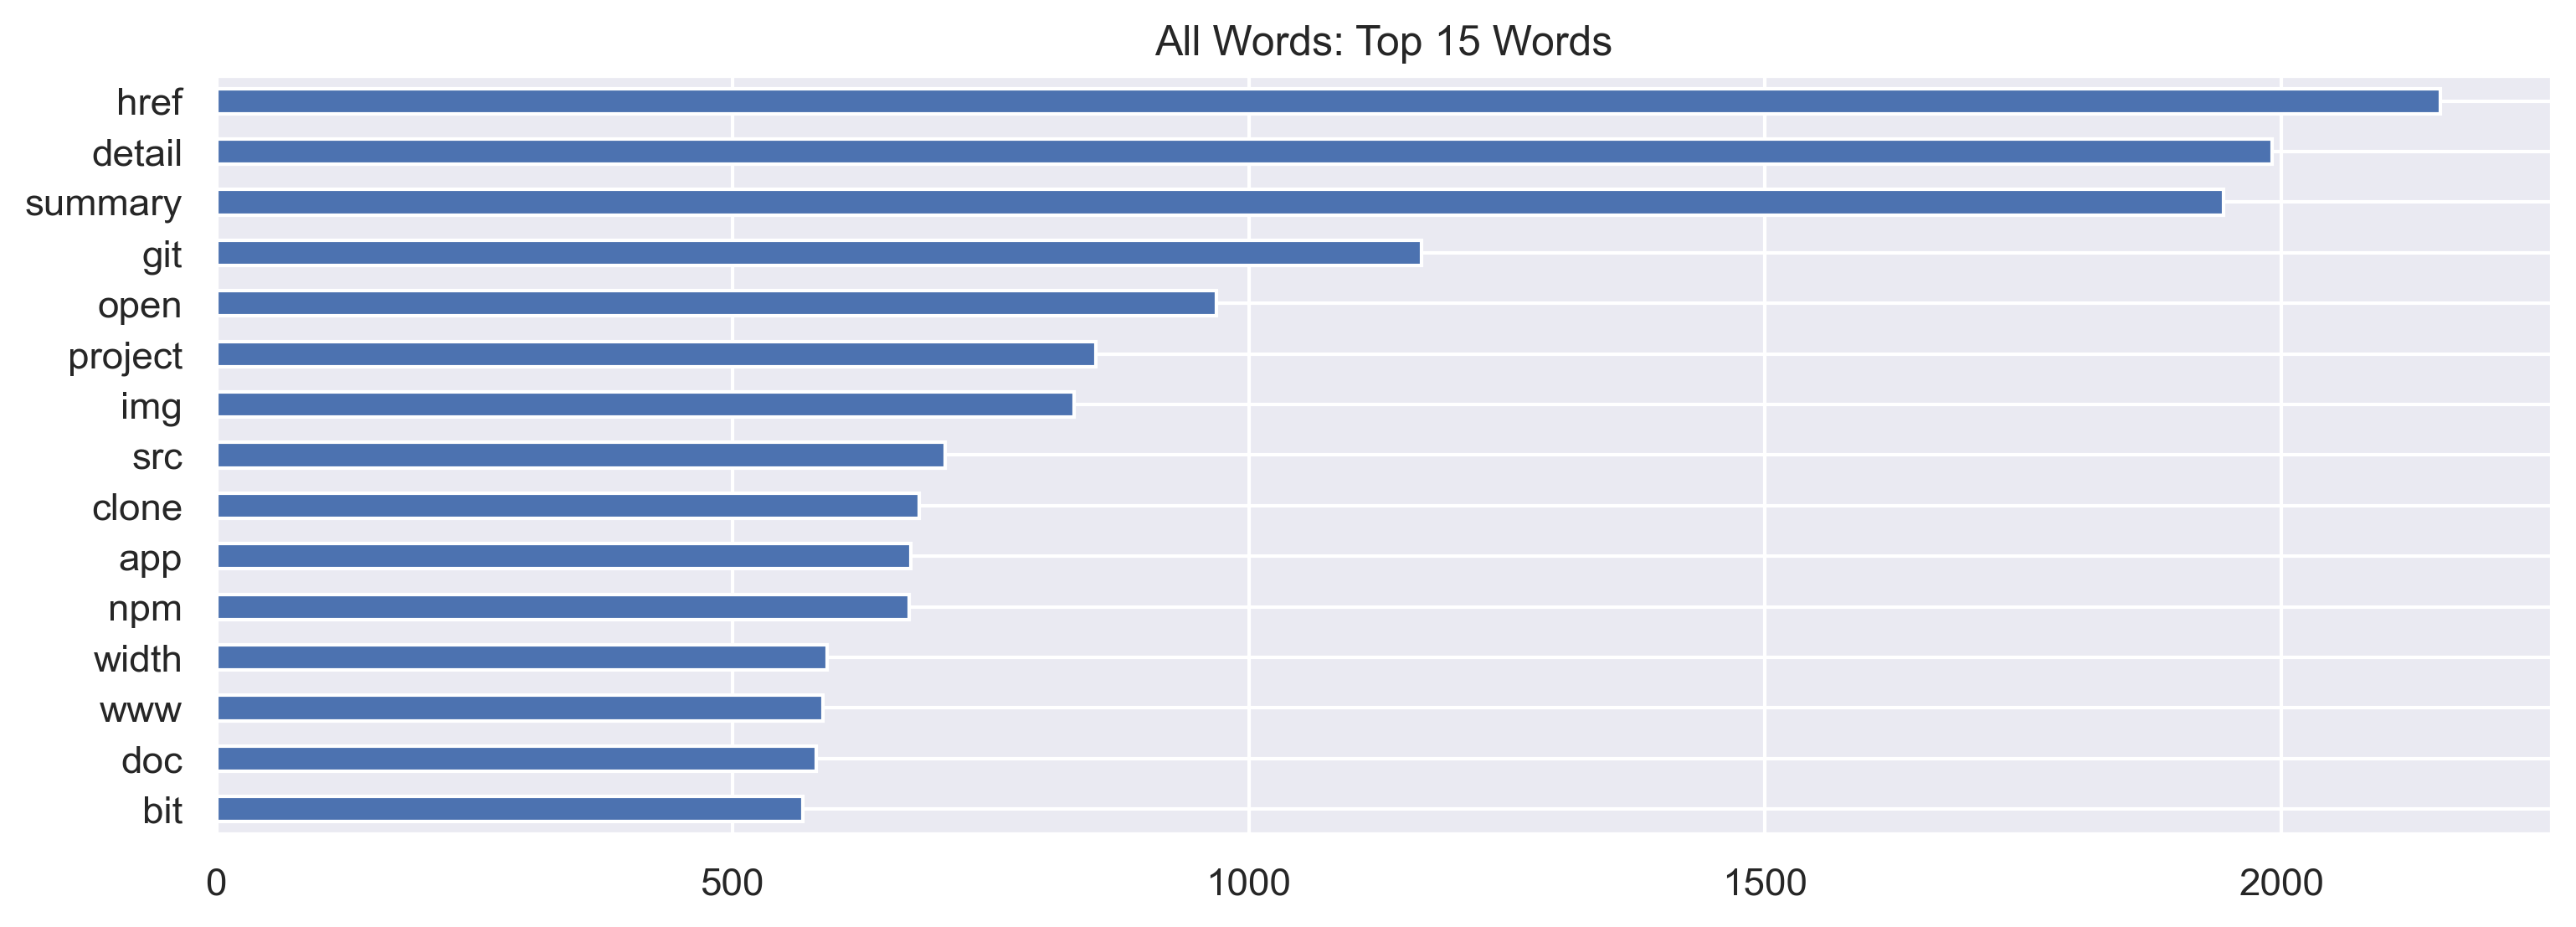

Language: All Words
Top 15 Words:
--------------------
href       2154
detail     1991
summary    1944
git        1167
open        969
project     852
img         831
src         706
clone       681
app         673
npm         671
width       592
www         588
doc         581
bit         568
Name: all, dtype: int64


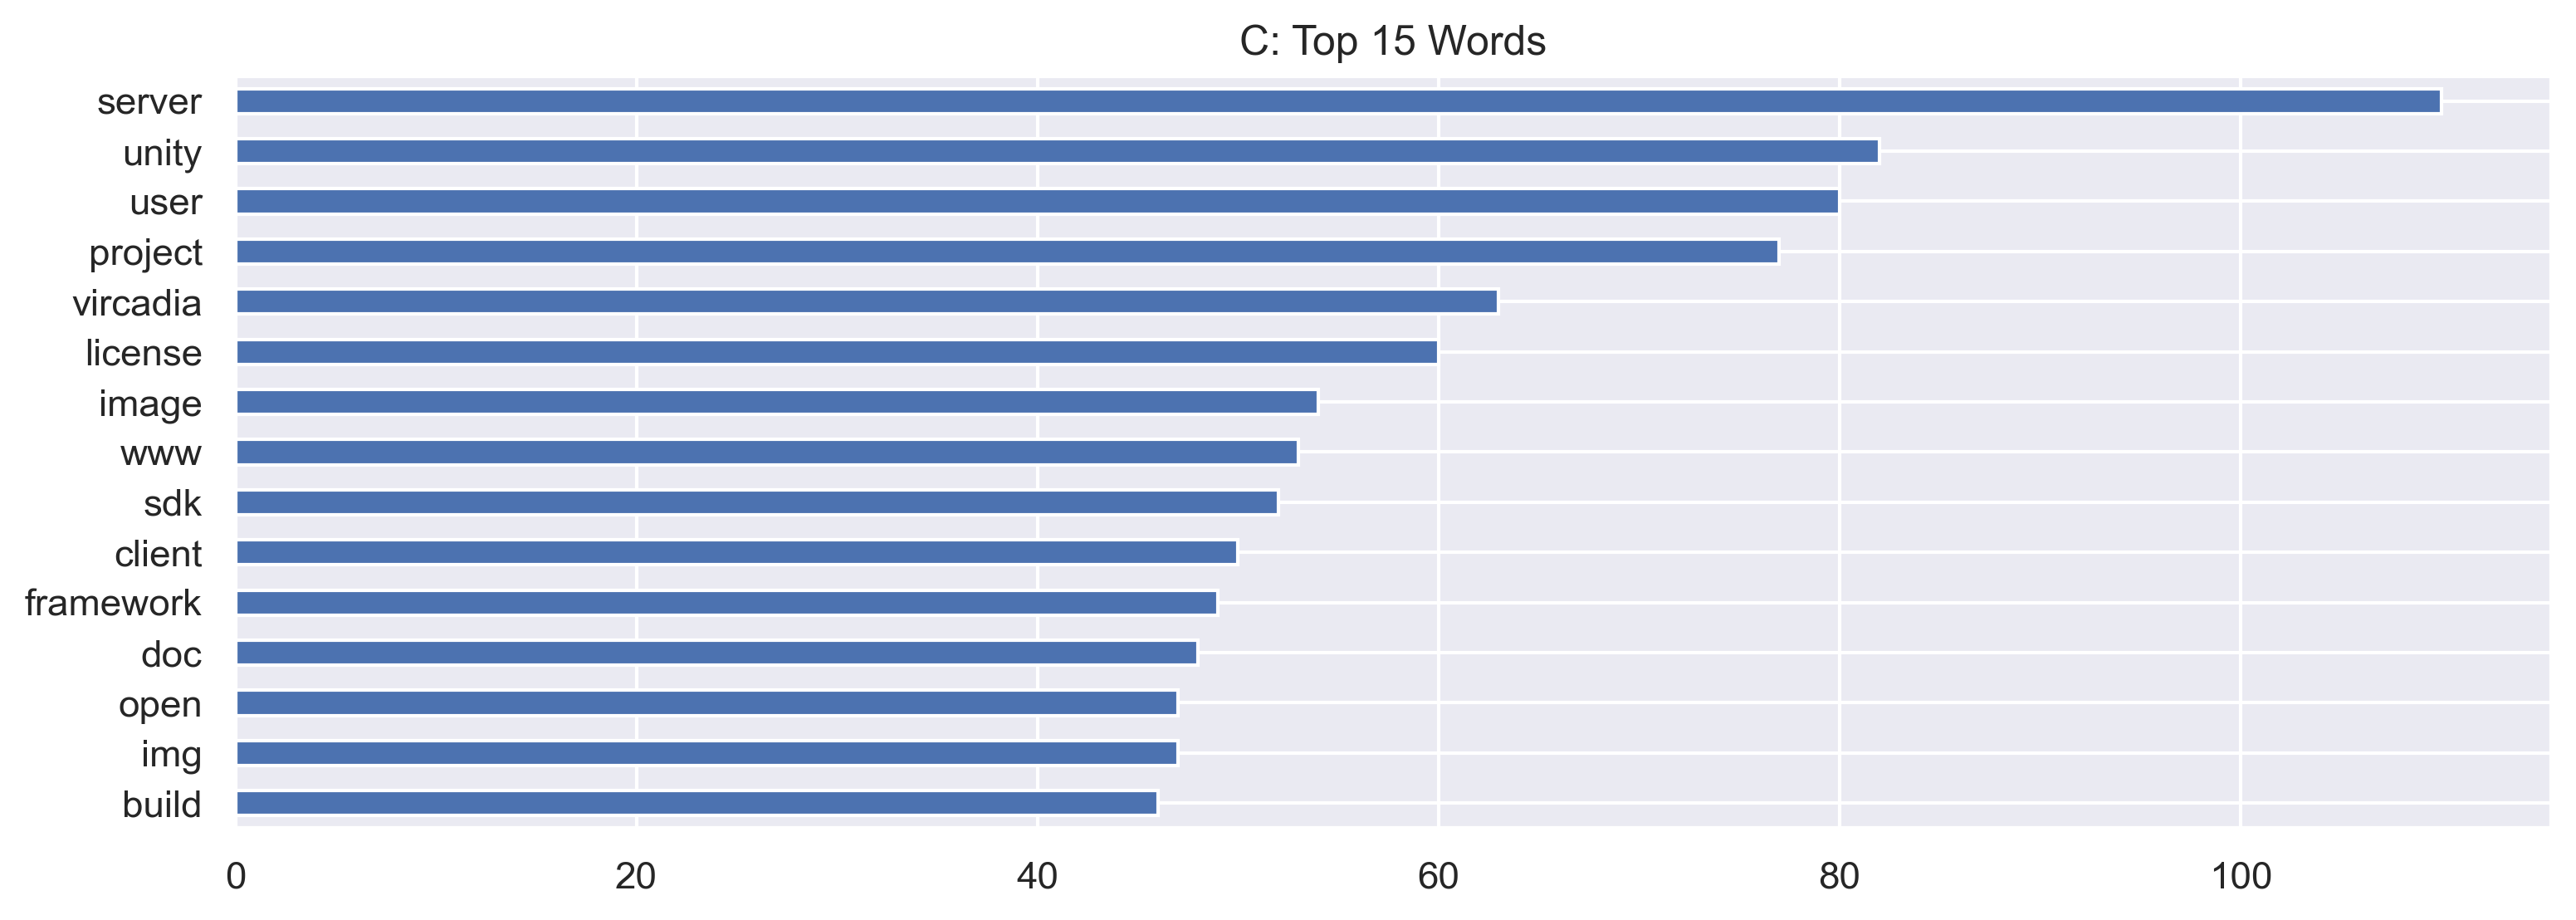

Language: C
Top 15 Words:
--------------------
server       110
unity         82
user          80
project       77
vircadia      63
license       60
image         54
www           53
sdk           52
client        50
framework     49
doc           48
img           47
open          47
build         46
Name: C, dtype: int64


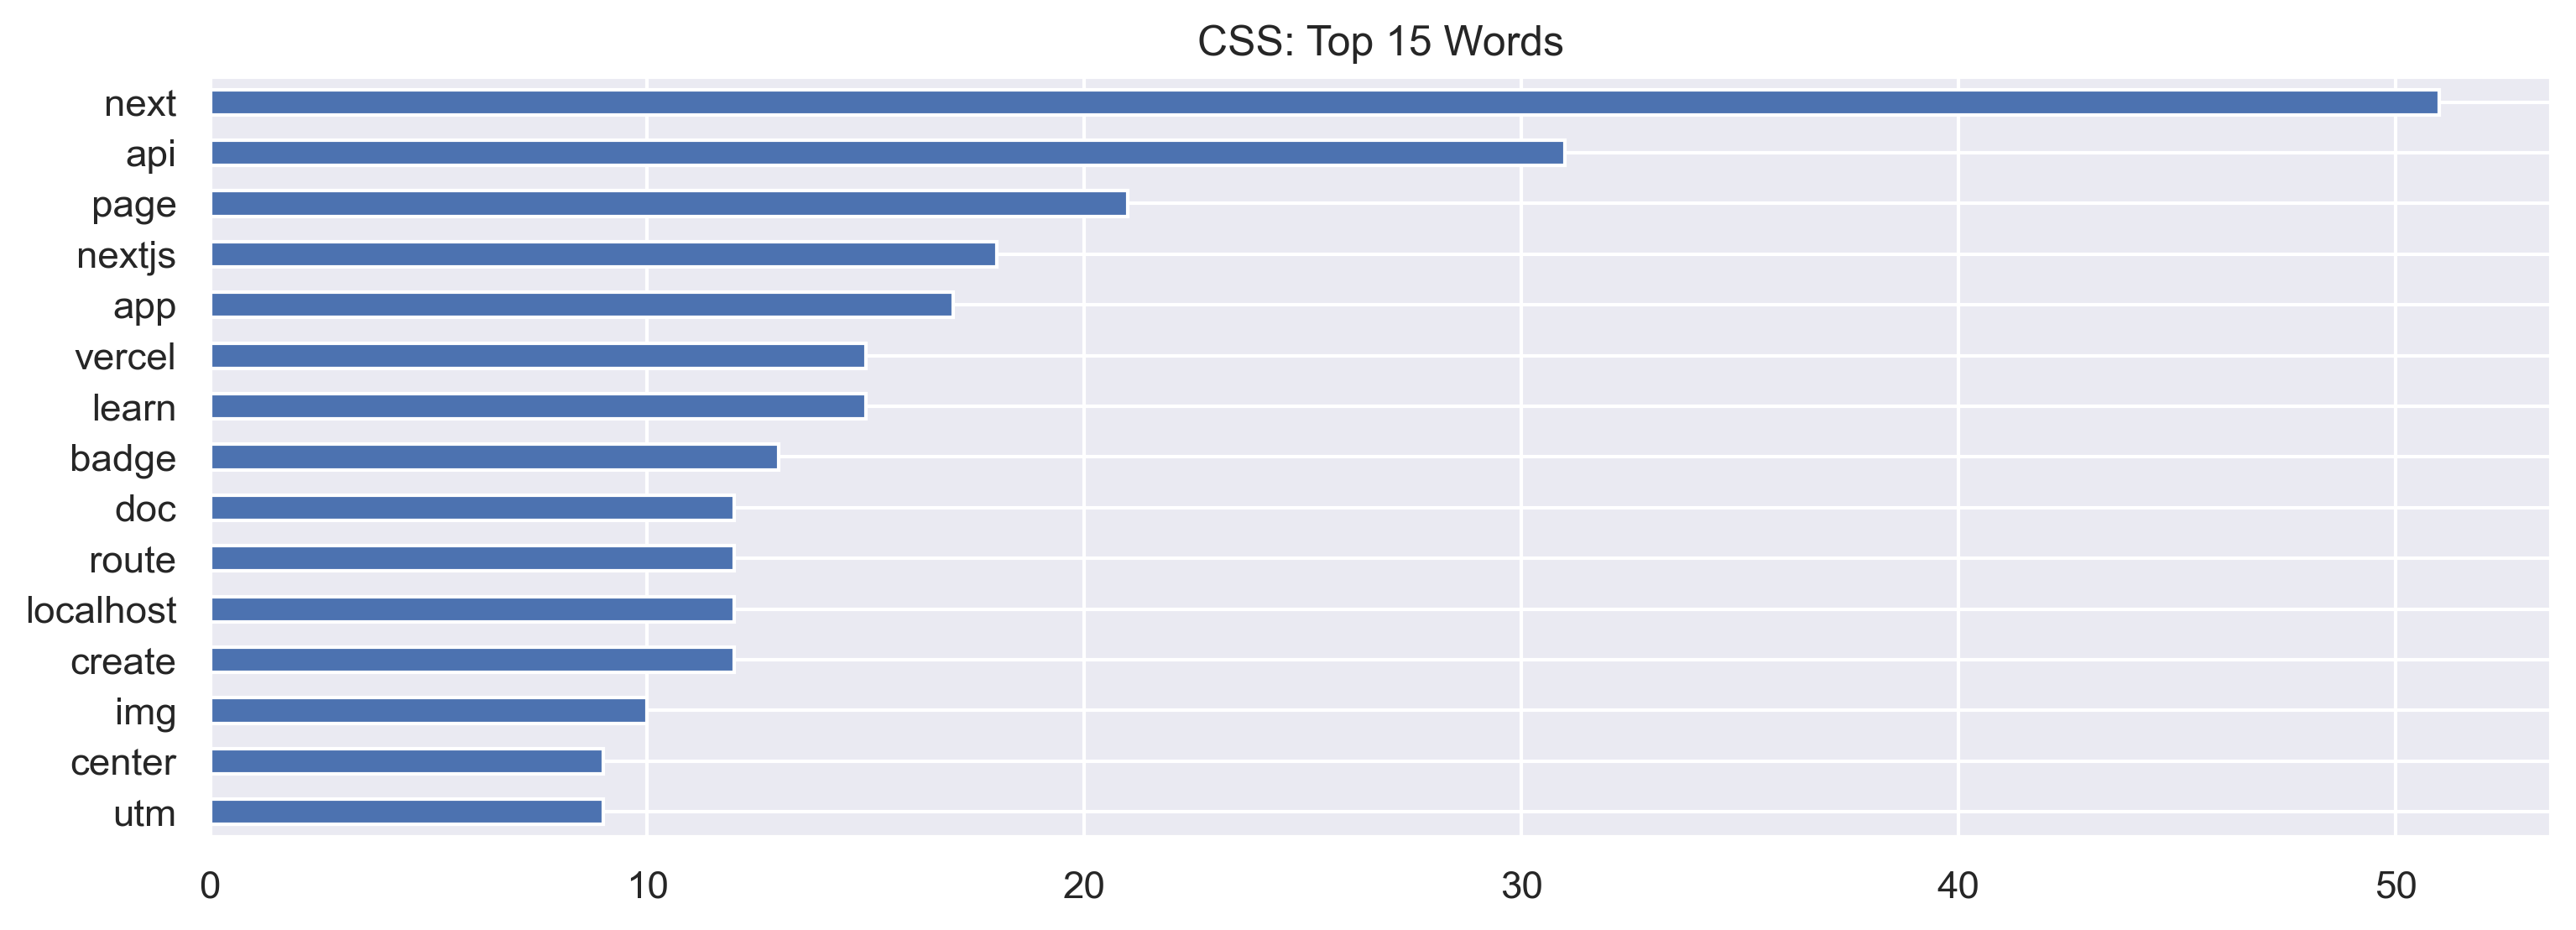

Language: CSS
Top 15 Words:
--------------------
next         51
api          31
page         21
nextjs       18
app          17
learn        15
vercel       15
badge        13
create       12
localhost    12
route        12
doc          12
img          10
utm           9
center        9
Name: CSS, dtype: int64


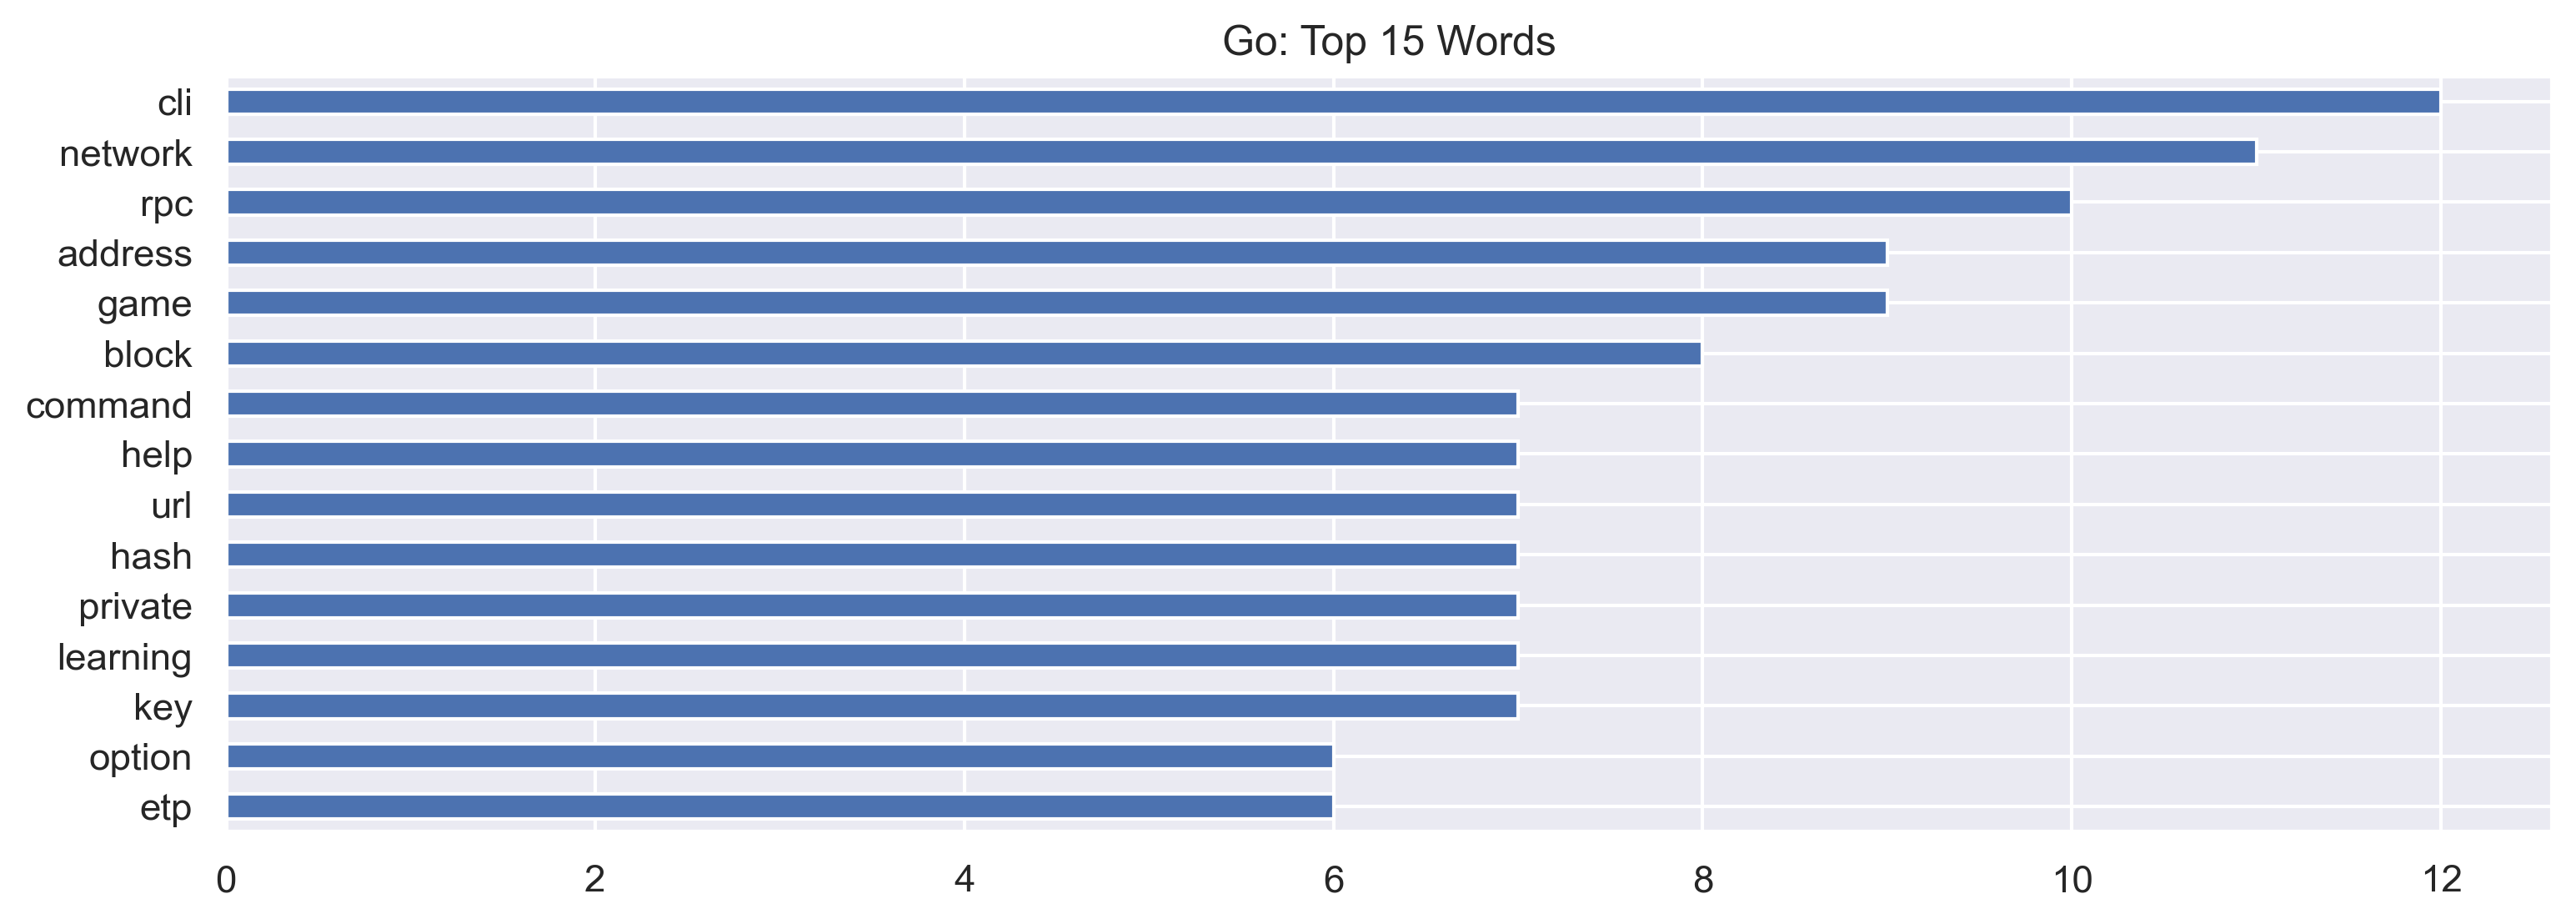

Language: Go
Top 15 Words:
--------------------
cli         12
network     11
rpc         10
game         9
address      9
block        8
key          7
learning     7
private      7
hash         7
url          7
help         7
command      7
etp          6
option       6
Name: Go, dtype: int64


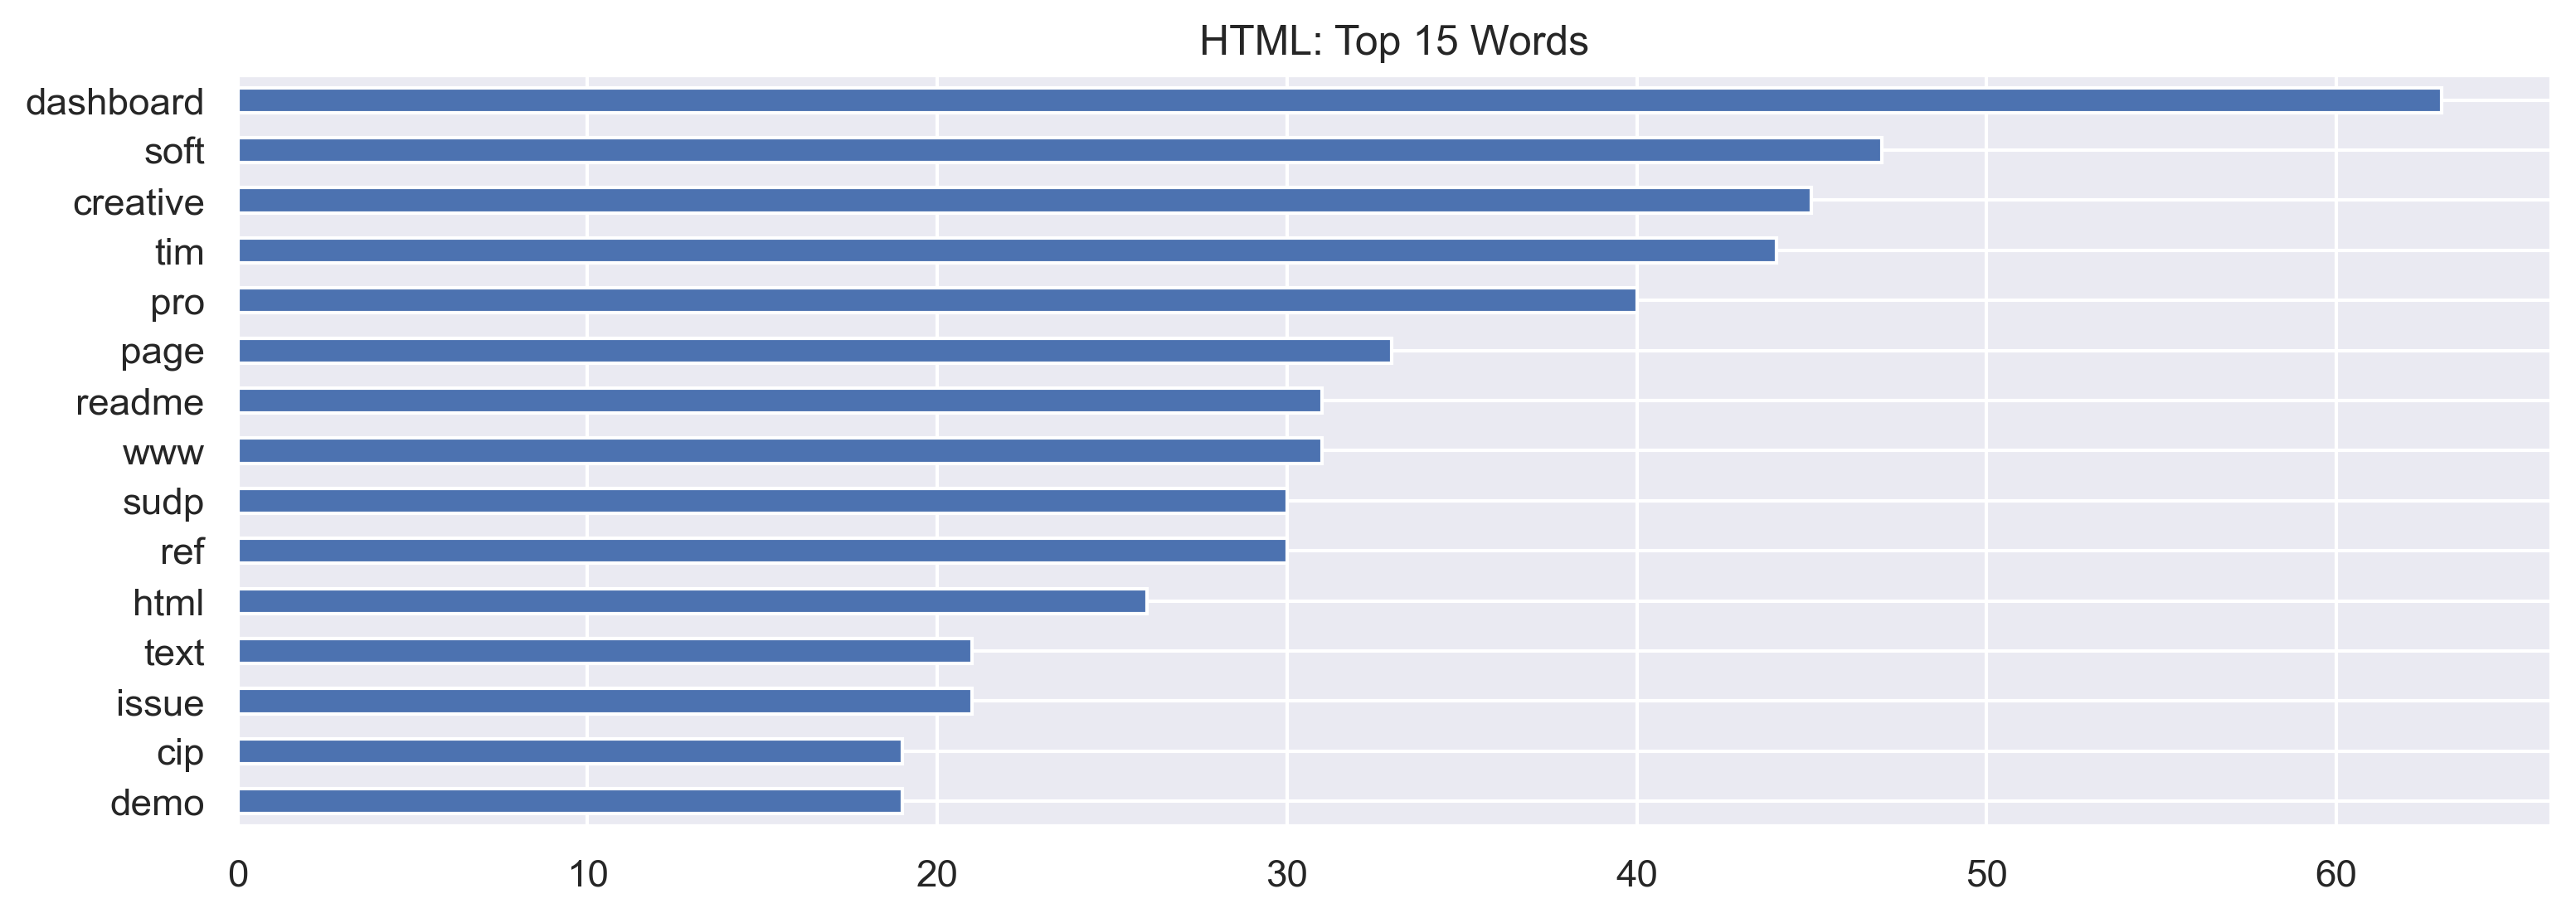

Language: HTML
Top 15 Words:
--------------------
dashboard    63
soft         47
creative     45
tim          44
pro          40
page         33
www          31
readme       31
ref          30
sudp         30
html         26
issue        21
text         21
demo         19
cip          19
Name: HTML, dtype: int64


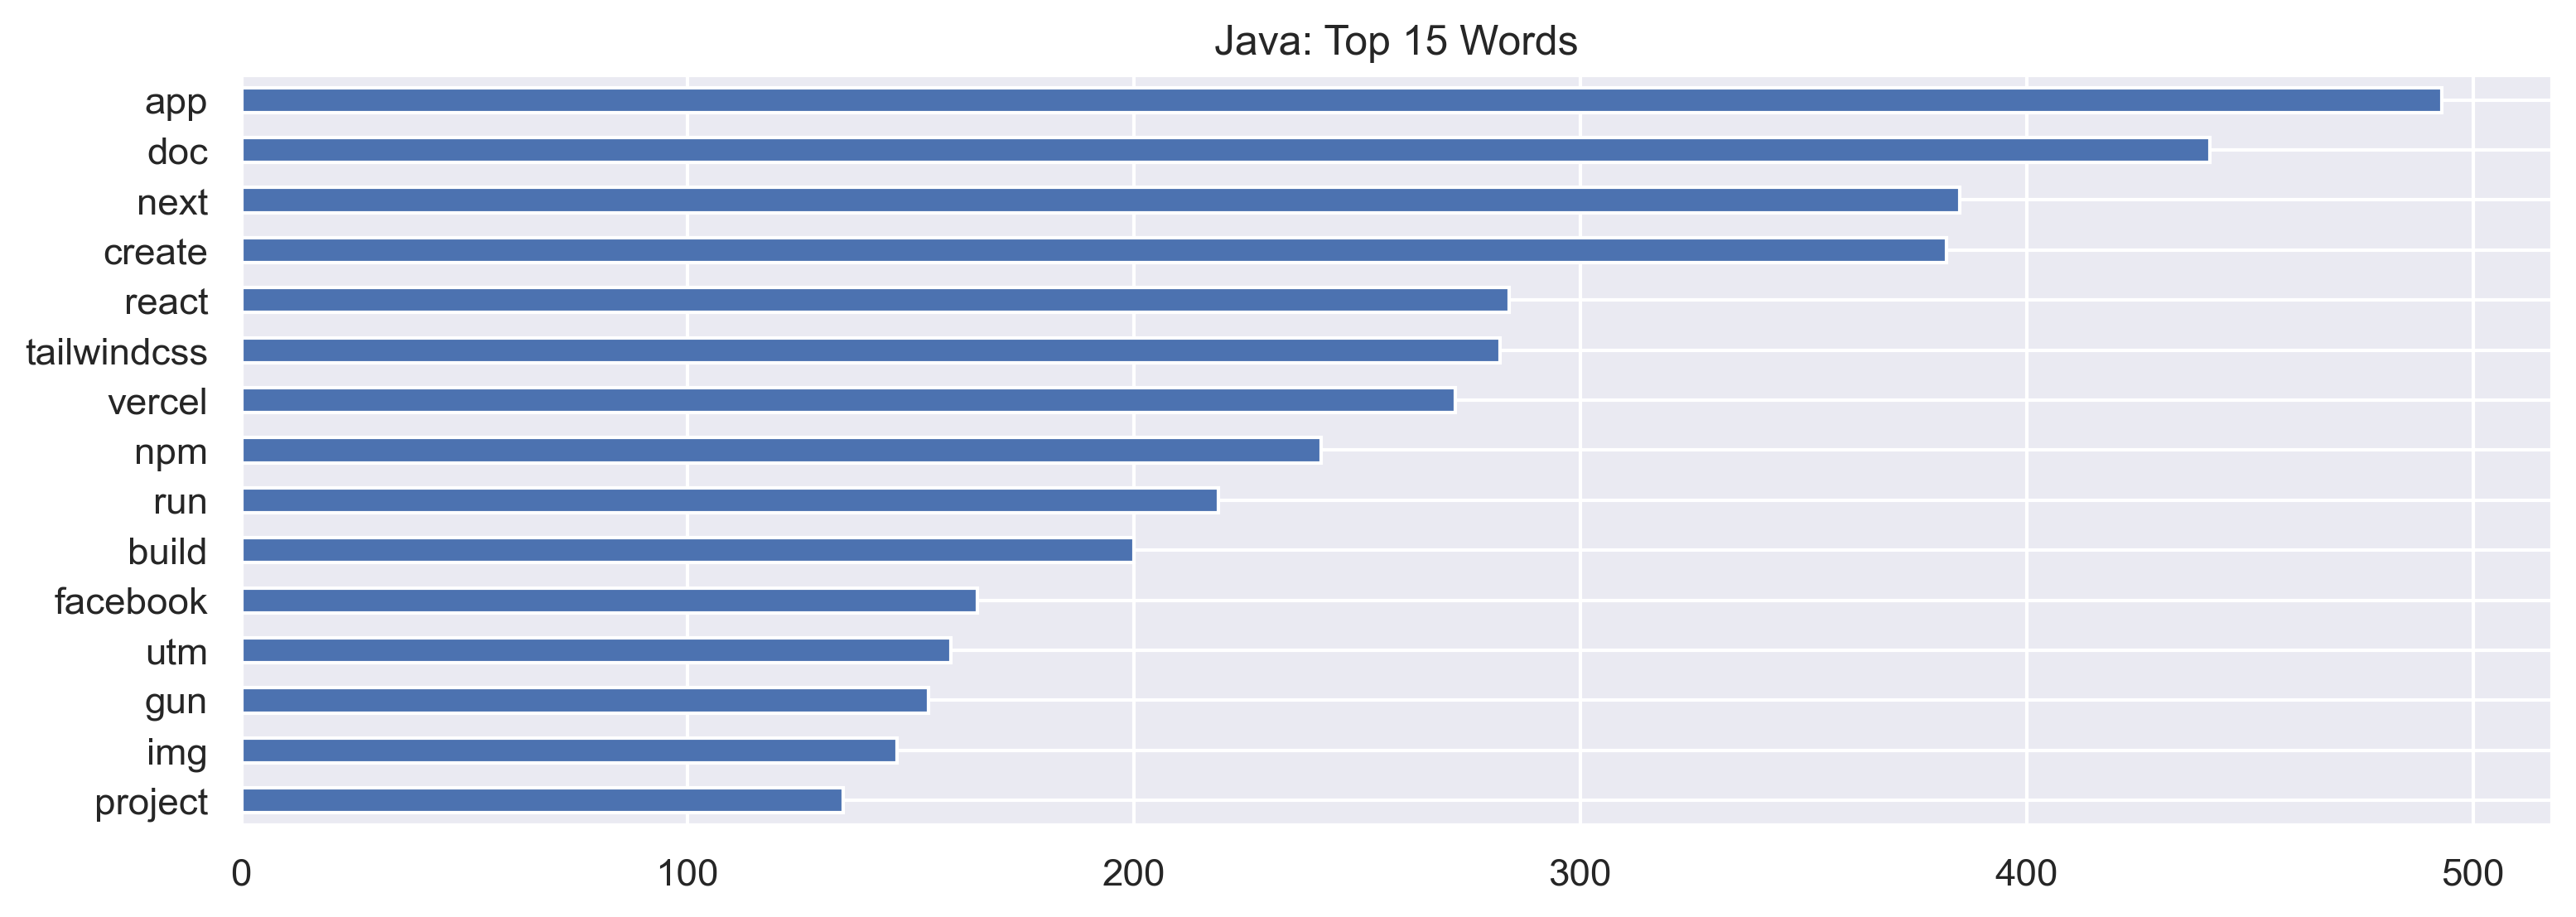

Language: Java
Top 15 Words:
--------------------
app            493
doc            441
next           385
create         382
react          284
tailwindcss    282
vercel         272
npm            242
run            219
build          200
facebook       165
utm            159
gun            154
img            147
project        135
Name: Java, dtype: int64


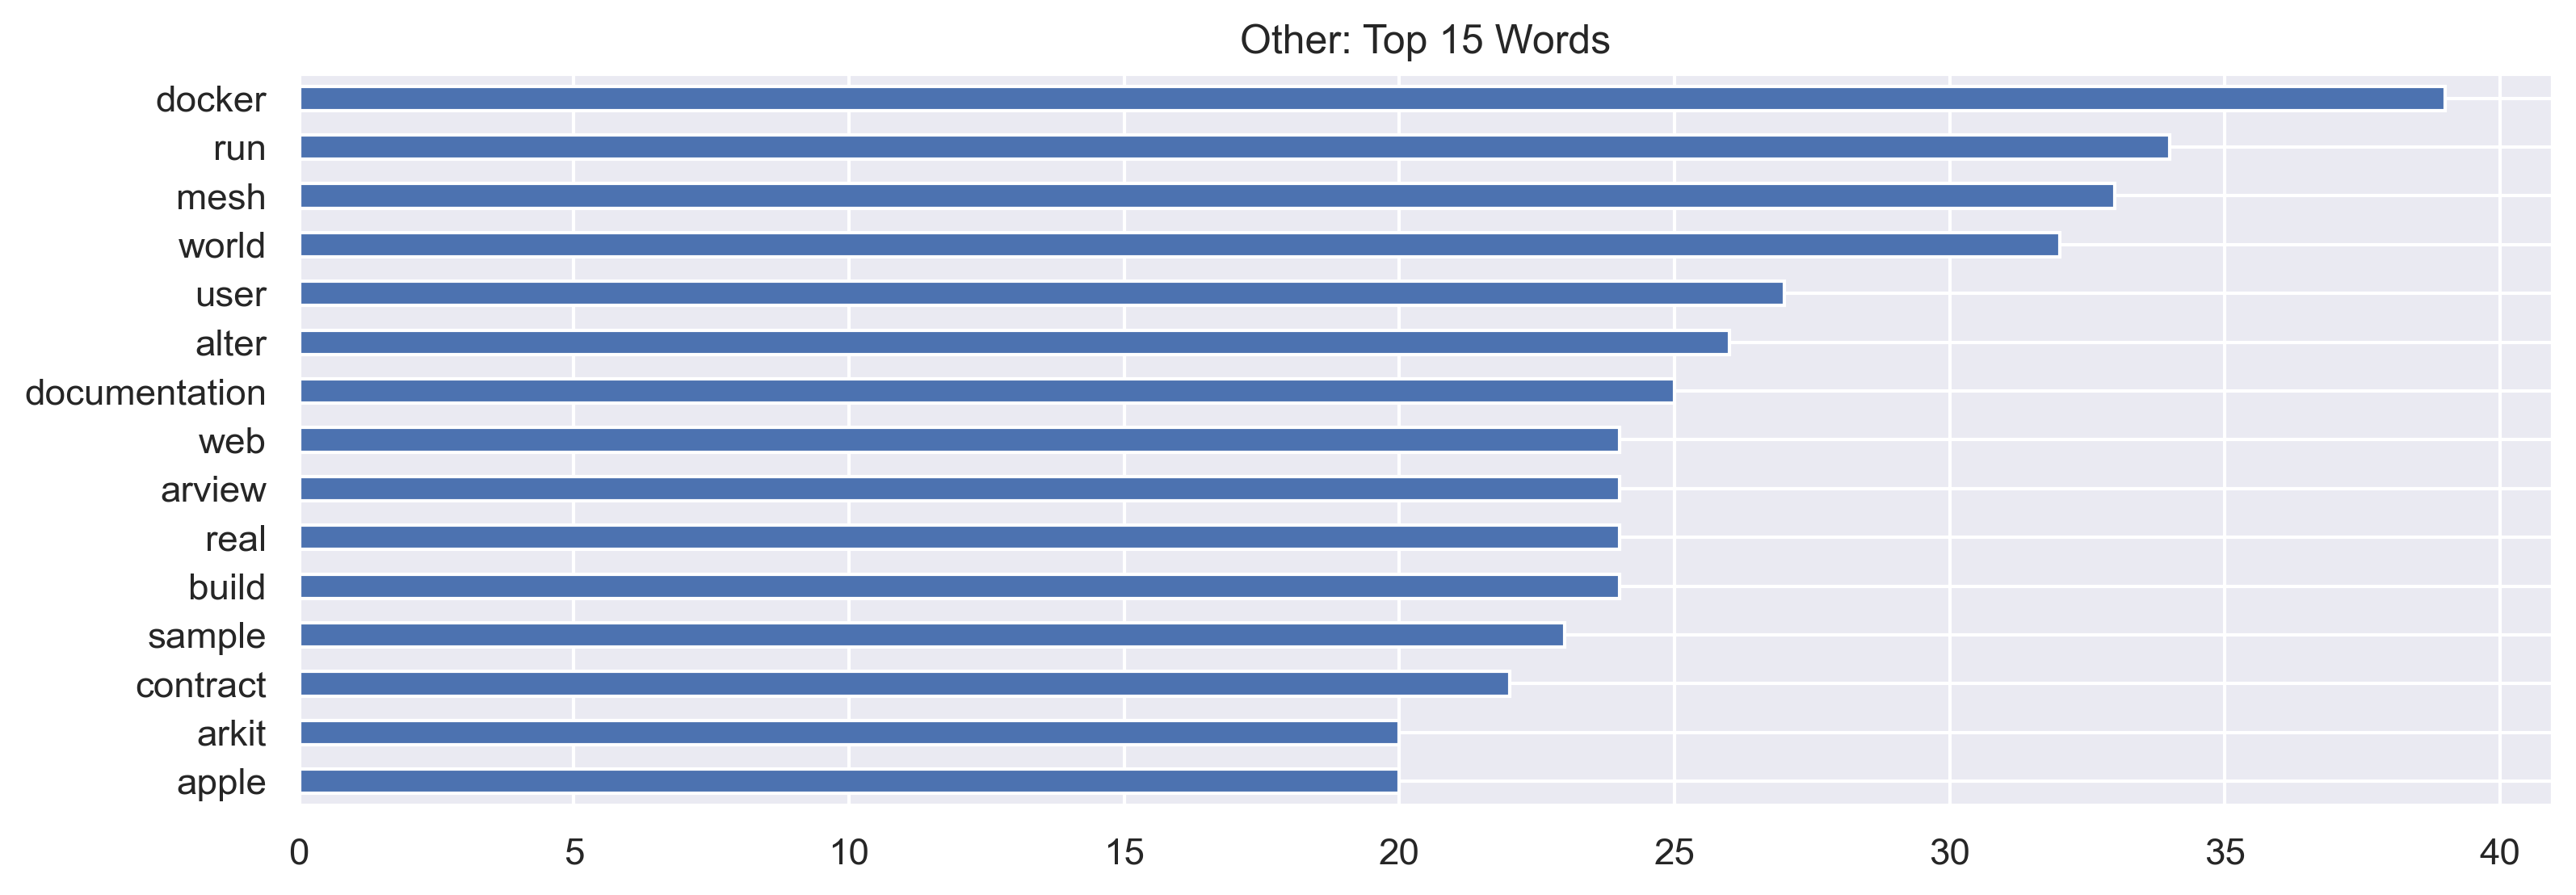

Language: Other
Top 15 Words:
--------------------
docker           39
run              34
mesh             33
world            32
user             27
alter            26
documentation    25
build            24
real             24
arview           24
web              24
sample           23
contract         22
apple            20
arkit            20
Name: Other, dtype: int64


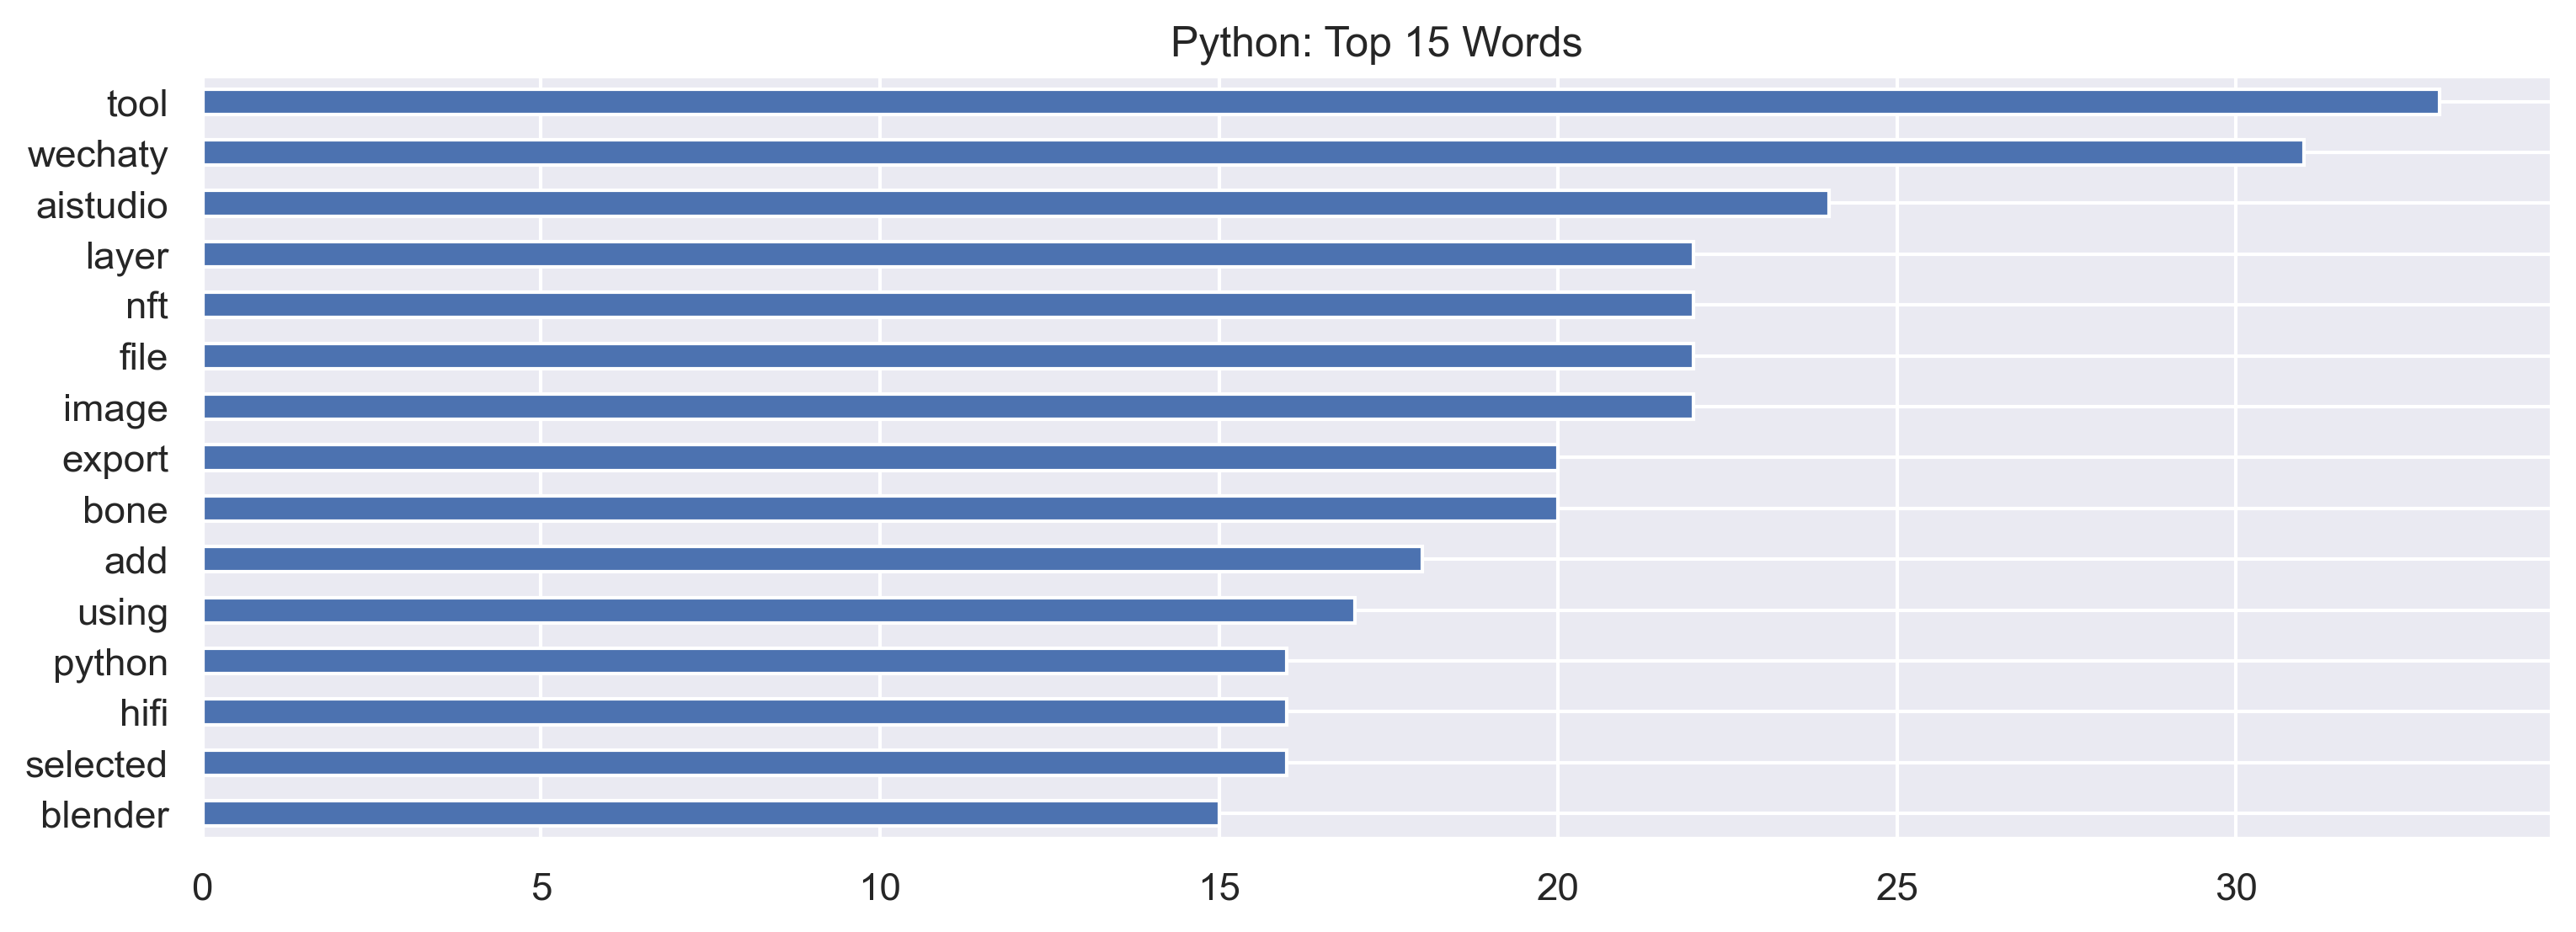

Language: Python
Top 15 Words:
--------------------
tool        33
wechaty     31
aistudio    24
image       22
file        22
nft         22
layer       22
bone        20
export      20
add         18
using       17
selected    16
hifi        16
python      16
blender     15
Name: Python, dtype: int64


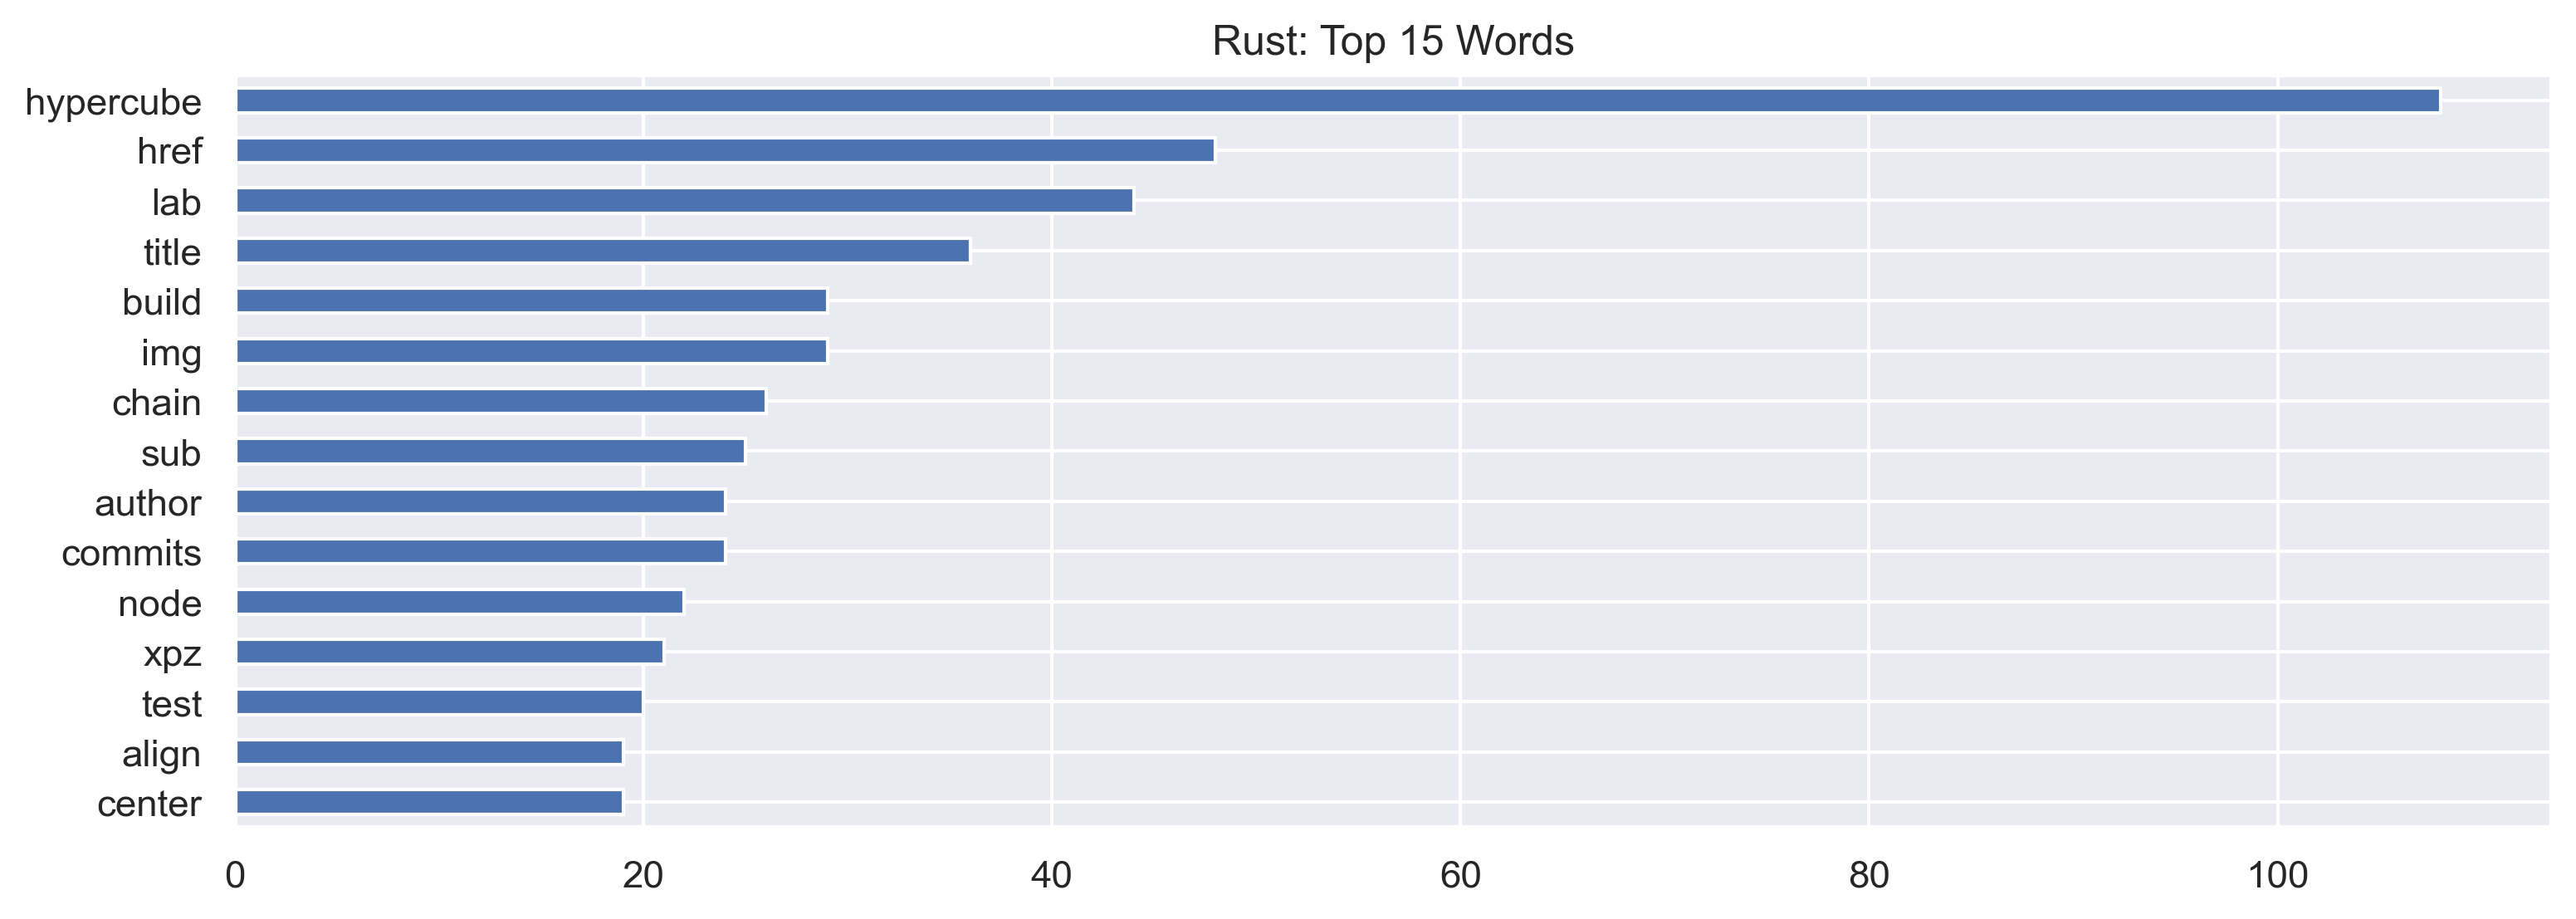

Language: Rust
Top 15 Words:
--------------------
hypercube    108
href          48
lab           44
title         36
img           29
build         29
chain         26
sub           25
commits       24
author        24
node          22
xpz           21
test          20
center        19
align         19
Name: Rust, dtype: int64


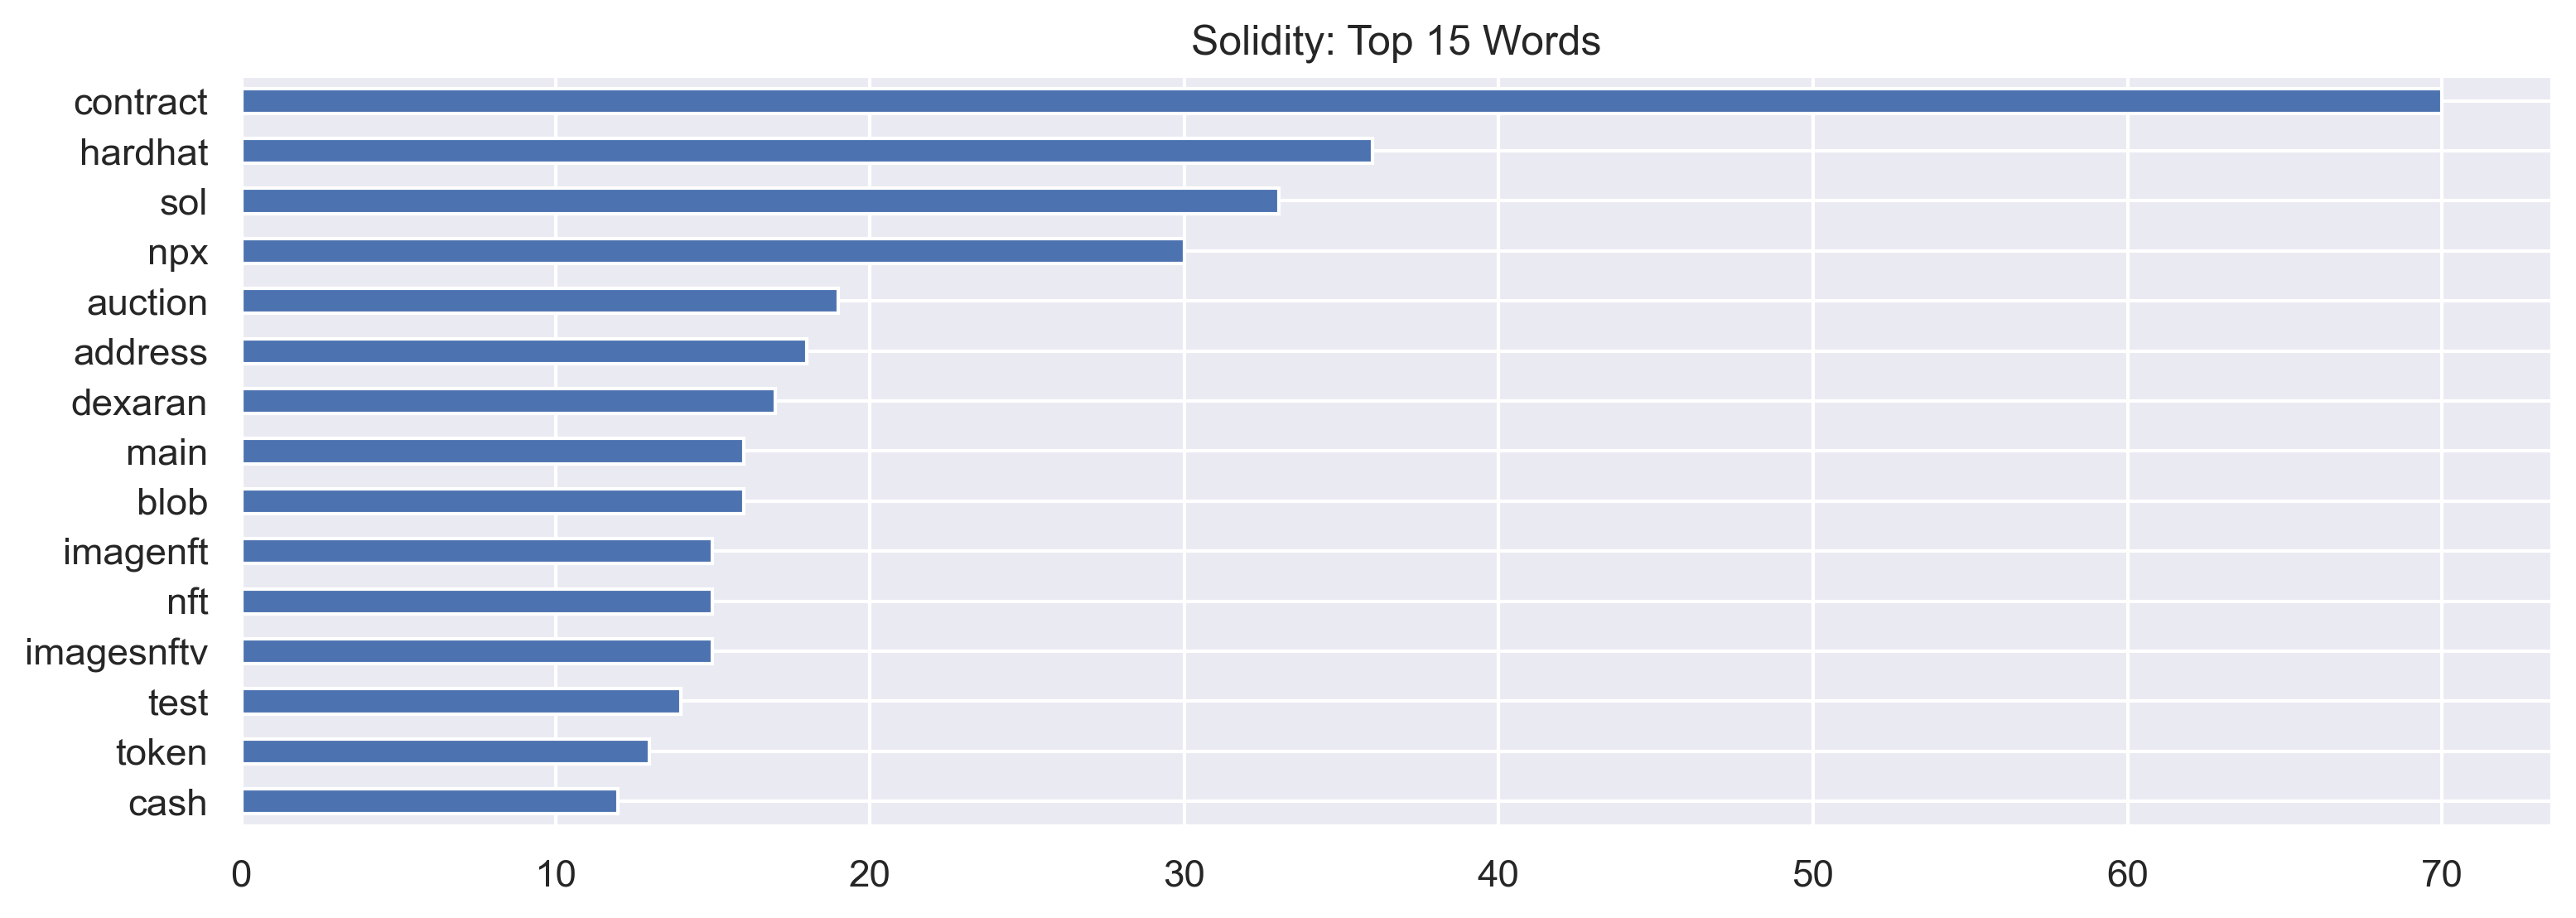

Language: Solidity
Top 15 Words:
--------------------
contract      70
hardhat       36
sol           33
npx           30
auction       19
address       18
dexaran       17
blob          16
main          16
imagesnftv    15
nft           15
imagenft      15
test          14
token         13
cash          12
Name: Solidity, dtype: int64


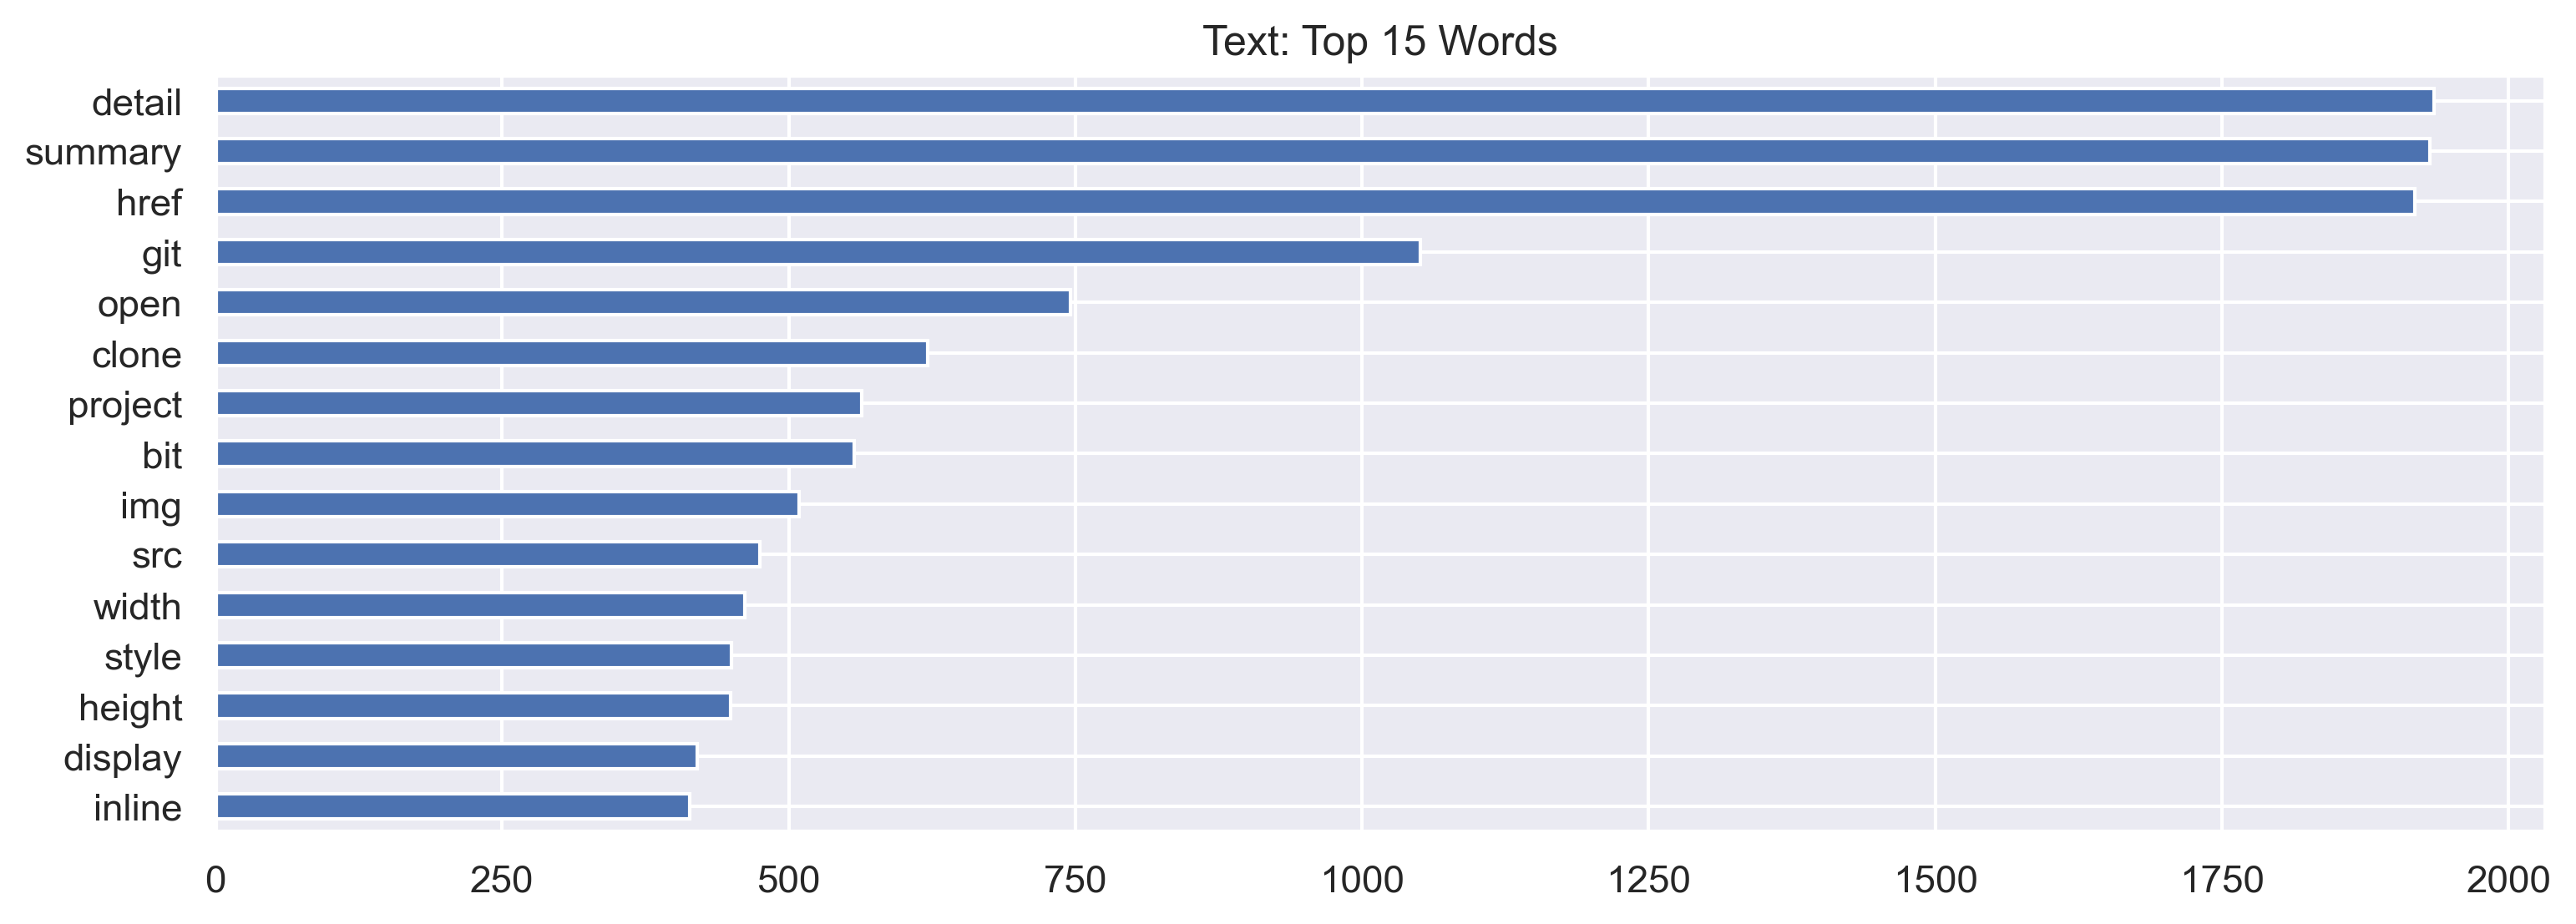

Language: Text
Top 15 Words:
--------------------
detail     1935
summary    1931
href       1918
git        1051
open        746
clone       621
project     564
bit         557
img         509
src         475
width       462
style       450
height      449
display     420
inline      414
Name: text, dtype: int64


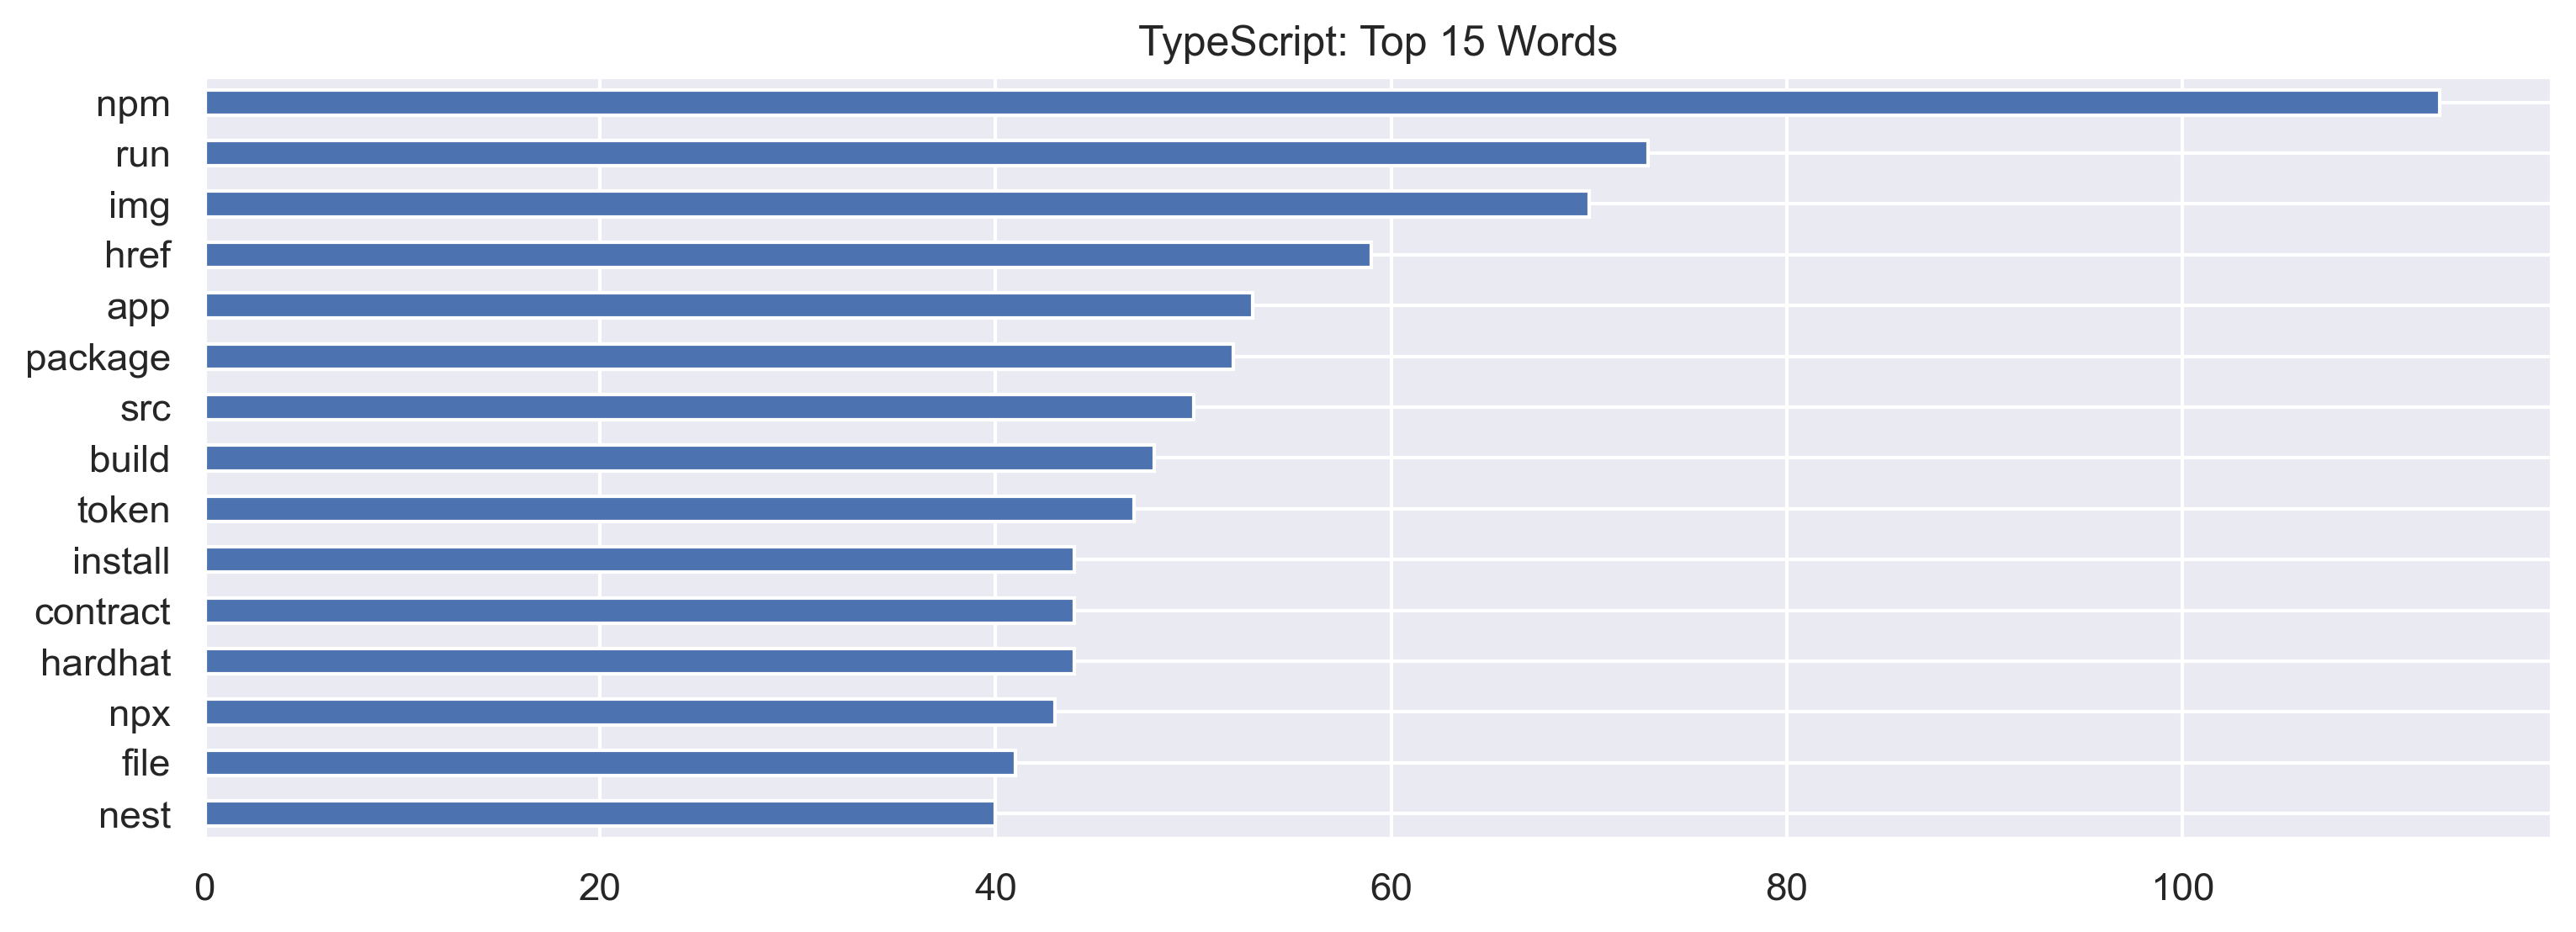

Language: TypeScript
Top 15 Words:
--------------------
npm         113
run          73
img          70
href         59
app          53
package      52
src          50
build        48
token        47
hardhat      44
contract     44
install      44
npx          43
file         41
nest         40
Name: TypeScript, dtype: int64


In [46]:
# for loop to return top words from ea. programming langugage

frames = [
    all_freq,
    C_freq,
    css_freq,
    go_freq,
    html_freq,
    java_freq, 
    other_freq,
    python_freq, 
    rust_freq,
    solidity_freq,
    text_freq,
    typescript_freq
]

languages = [
            "All Words",
            'C',
            'CSS',
            'Go',
            'HTML',
            'Java',
            'Other',
            'Python',
            'Rust',
            'Solidity',
            "Text",
            'TypeScript']

def get_top_words(frames, languages, number_of_words):

    for i in range(len(frames)):
        
        plt.figure(figsize = (12, 4))

        frame = frames[i]

        top_words = frame.head(number_of_words)
        top_words.sort_values(ascending = True).plot.barh()
        plt.title(f'{languages[i]}: Top {number_of_words} Words')

        plt.show()

        print(f'Language: {languages[i]}')
        print(f'Top {number_of_words} Words:\n--------------------\n{top_words}')


get_top_words(frames, languages, 15)

----
#### ``2. Does the length of the README vary by programming language?``

**Yes, the average length of Metaverse repositories differs by programming language. On average, the following primary programming languages tend to contain more text/content in their README files:**


- Rust
- TypeScript
- C

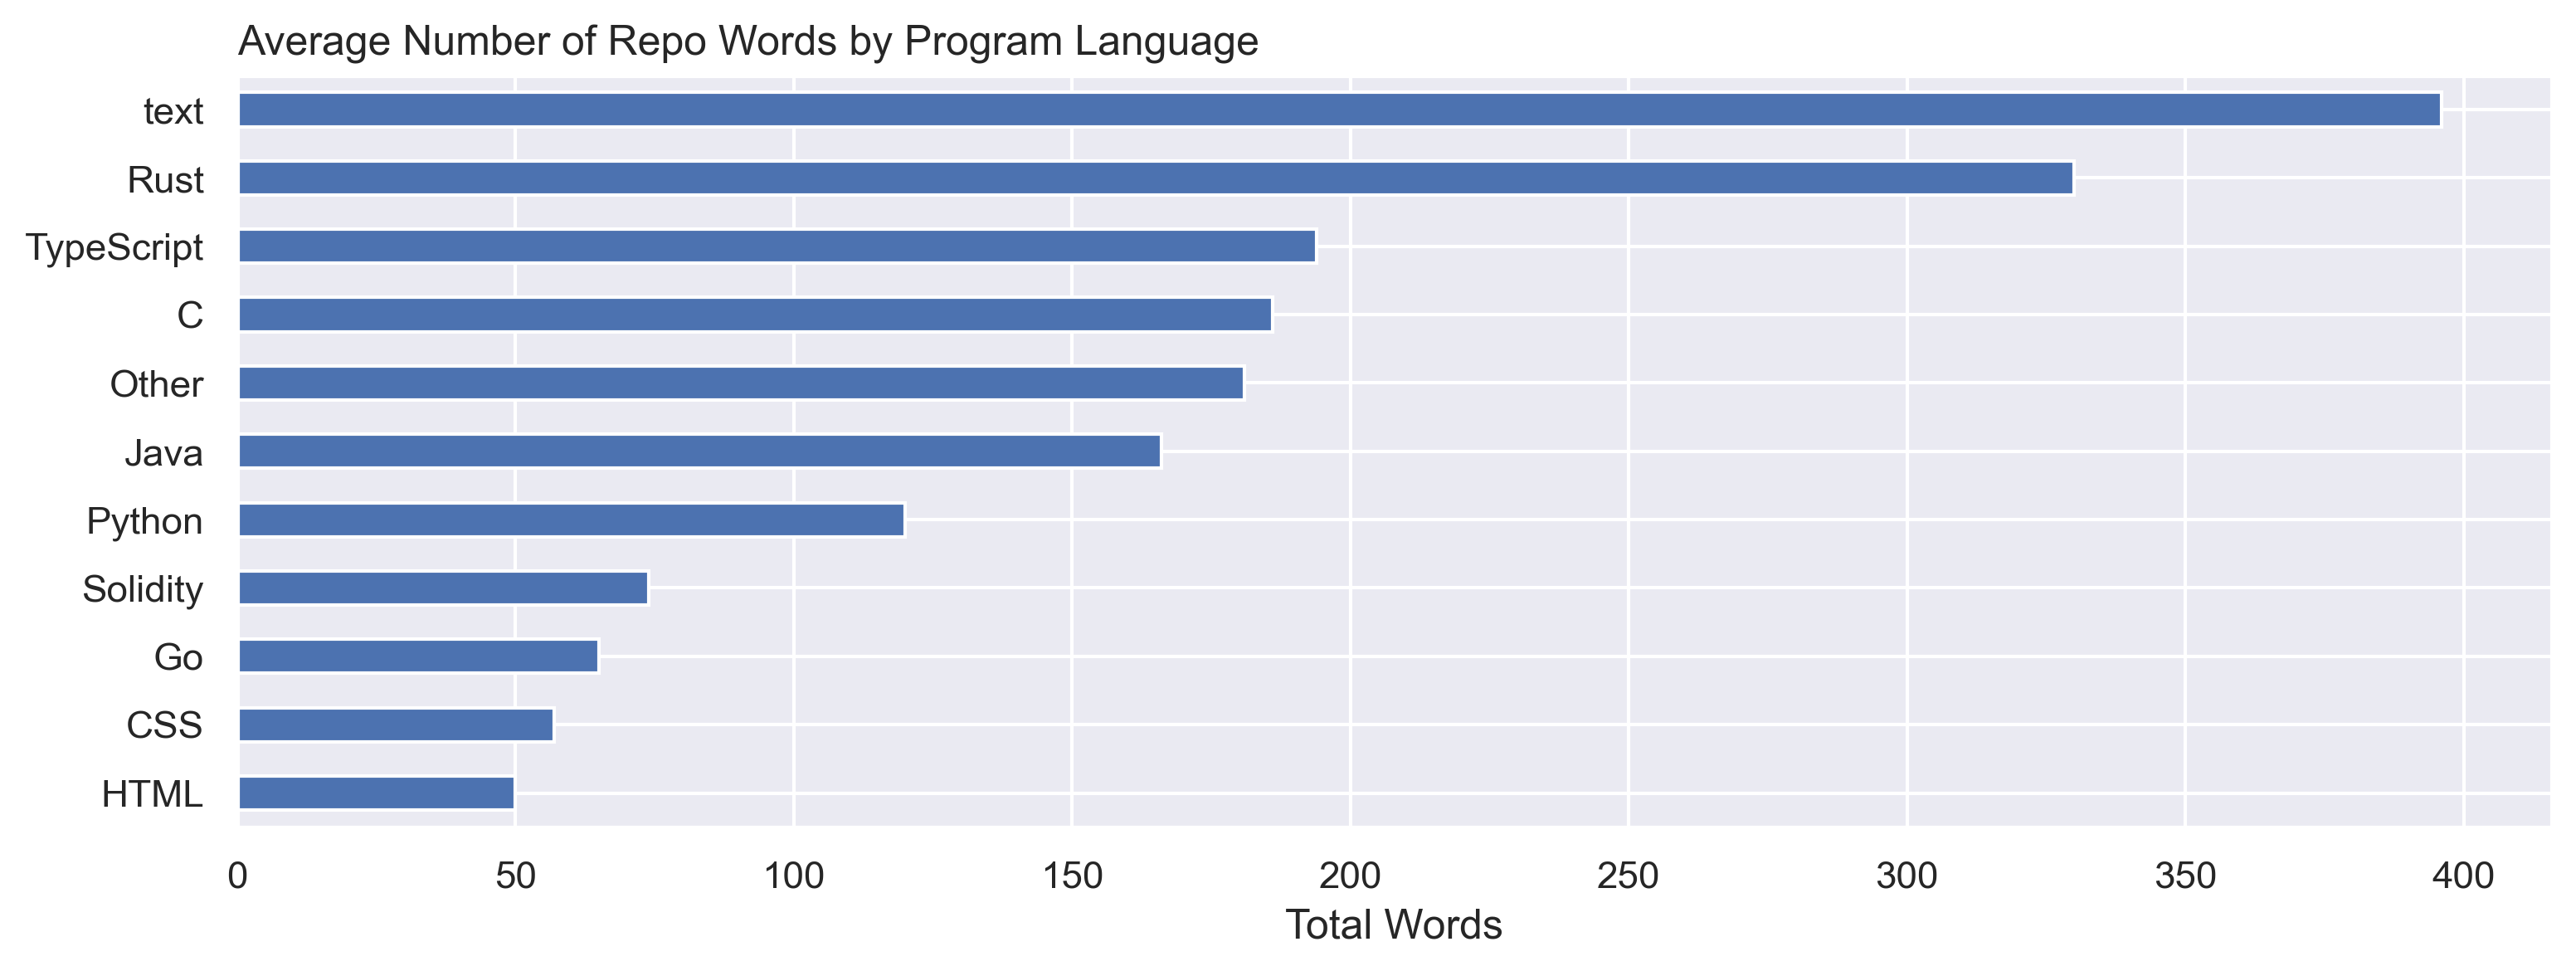

In [47]:
mean_of_words = train.groupby("language")["word_count"].agg("mean").sort_values(ascending = False).round()

plt.figure(figsize = (12, 4))
mean_of_words.sort_values(ascending = True).plot.barh()

plt.ylabel(None)
plt.xlabel("Total Words")
plt.title("Average Number of Repo Words by Program Language", loc = "left", fontsize = 12)
plt.show()

------
#### ``4. Are there any words that uniquely identify a programming language?``

**Yes, there are differences in the "quality"/unique words used across programming languages. All programming languages appeared to use unique words across the "Metaverse" README files.**

**<u>Here are some of those words:</u>**

In [48]:
# function to return unique words by program language

frames = [
    C_words,
    css_words,
    go_words,
    html_words,
    java_words, 
    other_words,
    python_words, 
    rust_words,
    solidity_words,
    text_words,
    typescript_words
]

# Python code to find frequency of each word
def find_unique_words(out_sample, frames):

    # returning unique words in ea. dataset

    frames = [df for df in frames if df != out_sample]
    
    # container to hold unique values
    container = []

    words = out_sample.split()

    for i in range(len(frames)):
        # setting the words to compare againgst
        compare_words = frames[i].split()

        # looping through ea. unique programmatic language
        for word in words:

            # iterating through compare words
            if word in compare_words:

                # remove words that arent unique in larger pool and continue iteration(s)
                words.remove(word)
    
    # returning the count of unique words
    return pd.Series(words)

In [49]:
# testing the function
find_unique_words(python_words, frames)

0                                            weronikazak
1                                                   nf3d
2                                           weronikawzak
3                                               weronika
4                                                    zak
5                                             buildquest
6                                             buildquest
7                                               hakathon
8                                            boilerplate
9                                           manipulating
10                                              modelled
11                                                 bored
12                                                   ape
13                                              covalent
14                                             accepting
15                                             thumbnail
16                                            buildquest
17                             

In [50]:
# comparing list against lists inside of a list

lst_a = ["apple", "banana", "mango", "pear"]

lst_b = ["apple"]
lst_c = ["mango", "apple"]

lst_x = [lst_a, lst_b, lst_c]

# desired output num1
new_lst = [lst_b, lst_c]

# desired output num2
new_lst = ["pear"]

In [51]:
# testing the function works
find_unique_words(python_words, frames).nunique() # checks out!

0     weronikazak
1            nf3d
2    weronikawzak
3        weronika
4             zak
5      buildquest
6      buildquest
7        hakathon
8     boilerplate
9    manipulating
dtype: object

In [59]:
# unique words by programming language

languages = [
 'C',
 'CSS',
 'Go',
 'HTML',
 'Java',
 'Other',
 'Python',
 'Rust',
 'Solidity',
 'Text',
 'TypeScript']

for i in range(len(languages)):
    # creating an object to analyze
    obj = find_unique_words(frames[i], frames)
    top_10 = obj.unique()[0:11]

    print("Language:", languages[i])
    print(f'Total Unique Words: {obj.nunique()}')
    print("\n".join(top_10))
    print('----------------------')

Language: C
Total Unique Words: 1231
20200824
shoulder
generous
newtonsoft
bcrypt
damien
miller
djm
mindrot
jbcrypt
ryan
----------------------

Language: CSS
Total Unique Words: 52
projeto
feita
partir
autor
por
rafael
morais
entre
tgmarinho
moraisrafaa
faael
----------------------

Language: Go
Total Unique Words: 39
integer
hexadecimal
receipt
passed
0xabc123
myaddress
0xaddress
shorthand
testnet'
verbose
9933
----------------------

Language: HTML
Total Unique Words: 193
metaversity
university
multicreator
cips
gitter
initiate
cip
gamecredits
discussed
awaiting
governs
----------------------

Language: Java
Total Unique Words: 2339
lifescope
accidentally
committing
'config'
'default
'dev'
kustomize
lifescopelabs
containerize
containerizing
containerized
----------------------

Language: Other
Total Unique Words: 532
minh'
simmer
minhrose
minh
wrench
eb0
notion
c9e0e8c497e94046a945f5790f75fede
101281380
159196833
0e91b1f8
----------------------

Language: Python
Total Unique Words: 